# Project 2: Ames (Iowa) Housing Price Regression

# Content (Part 2)

#### Part 1 - Data Preparation
- [1A Data Preparation](#1A-Data-Preparation)
- [1B Data Cleaning](#1B-Data-Cleaning)
- [2A Correlation - Multi-collinearity](#2A-Correlation:-Multi-collinearity)
- [2B Correlation of X Variables against Saleprice](#2B-Correlation-of-X-Variables-against-Saleprice)

#### Part 2 - Regression & Summary
- [3 Preparation of Data for Modelling](#3-Preparation-of-Data-for-Modelling)
- [4 Regression Modelling](#4-Regression-Modelling)
    - Model 1: Regression with All Regressors (Top-down Filtering)
    - Model 2: Dropping columns that have been made zero by lasso regression in Model 1 (Top-down Filtering)
    - Model 3: Top 40 ranked Absolute Lasso Coefficients Based on Model 1 (Bottom-up)
    - Model 4: Top 20 ranked Absolute Lasso Coefficients Based on Model 1 (Bottom-up)
    - Model 5: Tuning Model 2 to remove multi-collinear variables (Top-down Filtering)
    - Model 6: Picking Regressors with the Highest Correlation to Saleprice (Bottom-up)
    - Model 7: Using Statistic Summary to Remove Regressors from Model 5 (Top-down Filtering)
        - Model 7A: Tuning Model 5 - Removal of Statistically Insignificant Variables (high p-values)
        - Model 7B: Tuning Model 5 - Removal of Variables with High Standard Errors
        - Model 7C: Tuning Model 5 - Removal of Variables that are statistically insignificant or has high standard errors
- [5 Interaction and Polynomial Variables](#5-Interaction-and-Polynomial-Variables)
    - Model 8A: Including the four interaction terms on top of Model 7A
    - Model 8B: Including the List of Filtered Interaction Terms on top of Model 8A
    - Model 9: Further fine-tuning of Model 8B using statistical evaluation
        - Model 9A: Tuning Model 8B - Removal of Statistically Insignificant Variables (high p-values)
        - Model 9B: Tuning Model 8B - Removal of Variables with High Standard Errors
        - Model 9C: Tuning Model 8B - Removal of Variables that are statistically insignificant or has high standard errors
    - Model 10: Fine Tuning Model 9A
        - Model 10A: Removal of regressors that were 'eliminated' by lasso regression
        - Model 10B: Removal of regressors due to MLR assumption evaluation
- [6 Preparing Test Data for Price Prediction](#6-Preparing-Test-Data-for-Price-Prediction)
- [7 Model Predictions](#7-Model-Predictions)
- [8 Kaggle Submissions & Results](#8-Kaggle-Submissions-&-Results)
- [9 Conclusions and Summary](#9-Conclusion-and-Summary)

### Overview of all models:

|Model|Approach|Description|Regression Type|Precedent Model|Adj R-square|RMSE|
|-|-|-|-|-|-|-|
|Model 1|Top Down|Regression with All Regressors|Lasso|Independent|0.8815|24878|
|Model 2|Top Down|Dropping columns that have been made zero by lasso regression|Lasso|Model 1|0.8904|24614|
|Model 3|Bottom Up|Top 40 ranked Absolute Lasso Coefficients|Ridge|Model 1|0.9008|24475|
|Model 4|Bottom Up|Top 20 ranked Absolute Lasso Coefficients|Ridge|Model 1|0.8983|26237|
|Model 5|Top Down|Removal multi-collinear variables|Lasso|Model 2|0.8907|24670|
|Model 6|Bottom Up|Picking Regressors with the Highest Correlation to Saleprice|Ridge|Independent|0.8435|32461|
|Model 7A|Top Down|Removal of Statistically Insignificant Variables (high p-values)|Ridge|Model 5|0.9041|24398|
|Model 7B|Top Down|Removal of Variables with High Standard Errors|Lasso|Model 5|0.8655|28517|
|Model 7C|Top Down|Removal of Variables that are statistically insignificant or has high standard errors|Ridge|Model 5|0.9039|24473|
|Model 8A|Polynomial/Interactions|Including the four interaction terms|Ridge|Model 7A|0.9114|23347|
|Model 8B|Polynomial/Interactions|Including the List of Filtered Interaction Terms|Ridge|Model 8A|0.9263|21954|
|**Model 9A**|**Polynomial/Interactions**|**Removal of Statistically Insignificant Variables (high p-values)**|**Ridge**|**Model 8B**|**0.9276**|**21762**|
|Model 9B|Polynomial/Interactions|Removal of Variables with High Standard Errors|Lasso|Model 8B|0.9207|23468|
|Model 9C|Polynomial/Interactions|Removal of Variables that are statistically insignificant or has high standard errors|Ridge|Model 8B|0.9265|21940|
|**Model 10A**|**Polynomial/Interactions**|**Removal of regressors that were 'eliminated' by lasso regression**|**Ridge**|**Model 9A**|**0.9243**|**22682**|
|Model 10B|Polynomial/Interactions|Removal of regressors due to MLR assumption evaluation|Ridge|Model 9A|0.9127|23908|

- Note that Precedent Model indicates the model that the current model is built on top of.
- Models that are selected for Kaggle submission are as highlighted: Model 9A and Model 10A

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

#Stylistic Choice:
plt.style.use('bmh')
sns.set_palette("RdBu_r")

# modeling imports
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict,KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

In [2]:
train = pd.read_csv('data/train_cleaned.csv')
test = pd.read_csv('data/test_cleaned.csv')

**Adapted from Part 1 - Data Preparation**

In [3]:
ordinal = ['extercond', 'bsmtcond', 'heatingqc', 'fireplacequ', 'garagequal',
       'garagecond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'garagefinish', 'fence', 'landslope', 'lotshape', 'overallqual',
       'overallcond']
numerical = ['lotarea', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf',
       '1stflrsf', 'grlivarea', 'totalhalfbaths', 'totalfullbaths',
       'bedroomabvgr', 'kitchenabvgr', 'fireplaces', 'garagearea',
       'wooddecksf', 'saleprice', 'houseage', 'yearsafterremod']
nominal = ['mssubclass', 'mszoning', 'landcontour', 'lotconfig', 'neighborhood',
       'condition1', 'bldgtype', 'housestyle', 'roofstyle', 'exterior2nd',
       'masvnrtype', 'foundation', 'electrical', 'functional', 'garagetype',
       'paveddrive', 'saletype', 'pool', 'centralair', 'porch']

train_no = train[nominal]
train_num = train[numerical]
train_ord = train[ordinal]

train.reset_index(drop=True,inplace=True)

union = (set(train_no.columns) | set(train_num.columns) | set(train_ord.columns))
total = set(train.columns)
print(total-union)
print(union-total)

{'id'}
set()


**Defining Data Visualisation Subplot Functions**

In [4]:
def subplot_regplot(dataframe,list_of_columns, suptitle, list_of_titles,datafigsize,yvariable):
    fig, ax = plt.subplots((len(list_of_columns)//4)+1, 4,figsize= datafigsize) 
    fig.suptitle(suptitle,fontsize=30)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    plt.tight_layout(w_pad = 5.0,h_pad = 5.0,pad=5.0);    
    
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.regplot(data=dataframe,x=dataframe[column],y=yvariable,ax=ax[i]) 
        ax[i].set_title(list_of_titles[i],fontdict={'fontsize': 12}) 
        ax[i].yaxis.set_visible(True)
        ax[i].xaxis.set_visible(True)
        
def subplot_distplot(dataframe,list_of_columns, suptitle, list_of_titles,datafigsize):
    fig, ax = plt.subplots((len(list_of_columns)//4)+1, 4,figsize= datafigsize) 
    fig.suptitle(suptitle,fontsize=30)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    plt.tight_layout(h_pad = 2,pad=5);
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.distplot(dataframe[column],color="palevioletred",ax=ax[i]) 
        ax[i].set_title(list_of_titles[i],fontdict={'fontsize': 15})
        ax[i].xaxis.set_visible(False)
        ax[i].axvline(dataframe[column].mean(), color='r', linestyle='dashed', linewidth=1,label='mean')
        ax[i].axvline(dataframe[column].median(), color='b', linestyle='dashed', linewidth=1,label="median")
        ax[i].legend(loc='upper left');

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 0 to 2046
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2047 non-null   int64  
 1   mssubclass       2047 non-null   int64  
 2   mszoning         2047 non-null   object 
 3   lotarea          2047 non-null   int64  
 4   lotshape         2047 non-null   int64  
 5   landcontour      2047 non-null   object 
 6   lotconfig        2047 non-null   object 
 7   landslope        2047 non-null   int64  
 8   neighborhood     2047 non-null   object 
 9   condition1       2047 non-null   int64  
 10  bldgtype         2047 non-null   object 
 11  housestyle       2047 non-null   object 
 12  overallqual      2047 non-null   int64  
 13  overallcond      2047 non-null   int64  
 14  roofstyle        2047 non-null   object 
 15  exterior2nd      2047 non-null   int64  
 16  masvnrtype       2047 non-null   object 
 17  masvnrarea    

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 52 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               879 non-null    int64  
 1   mssubclass       879 non-null    int64  
 2   mszoning         879 non-null    object 
 3   lotarea          879 non-null    int64  
 4   lotshape         879 non-null    int64  
 5   landcontour      879 non-null    object 
 6   lotconfig        879 non-null    object 
 7   landslope        879 non-null    int64  
 8   neighborhood     879 non-null    object 
 9   condition1       879 non-null    int64  
 10  bldgtype         879 non-null    object 
 11  housestyle       879 non-null    object 
 12  overallqual      879 non-null    int64  
 13  overallcond      879 non-null    int64  
 14  roofstyle        879 non-null    object 
 15  exterior2nd      877 non-null    float64
 16  masvnrtype       879 non-null    object 
 17  masvnrarea      

#### Correcting Wrong Data

In [7]:
# Correcting for wrongly imported data:
    # MSSubClass Datatype:
train['mssubclass']=train['mssubclass'].astype(str)
test['mssubclass']=test['mssubclass'].astype(str)
    # garagetype null values:
train['garagetype'].fillna(value="NA",inplace=True)
    # exterior2nd: Change to string object
train['exterior2nd']=train['exterior2nd'].astype(str)
test['exterior2nd']=test['exterior2nd'].astype(str)

In [8]:
train['garagetype'].value_counts()

Attchd     1209
Detchd      536
BuiltIn     132
NA          113
Basment      27
2Types       19
CarPort      11
Name: garagetype, dtype: int64

# 3 Preparation of Data for Modelling
### Dummy Variables

In [9]:
train.shape

(2047, 53)

In [10]:
train_dummy = pd.get_dummies(train, drop_first = True)
test_dummy = pd.get_dummies(test, drop_first = True)

print(train_dummy.shape)
print(test_dummy.shape)

(2047, 138)
(879, 132)


In [11]:
def intersection(list1, list2): 
    difference_1 = list(set(list1) - set(list2)) 
    difference_2 = list(set(list2) - set(list1)) 
    return list(set(difference_1) | set(difference_2)) 

In [12]:
intersection(test_dummy.columns,train_dummy.columns)

['functional_Sal',
 'exterior2nd_2',
 'exterior2nd_nan',
 'functional_Sev',
 'exterior2nd_5.0',
 'exterior2nd_6',
 'garagetype_NA',
 'exterior2nd_3',
 'mssubclass_150',
 'exterior2nd_4.0',
 'mszoning_C (all)',
 'saleprice',
 'exterior2nd_5',
 'neighborhood_Landmrk',
 'masvnrtype_CBlock',
 'exterior2nd_4',
 'exterior2nd_3.0',
 'exterior2nd_2.0',
 'neighborhood_GrnHill',
 'exterior2nd_6.0']

Noticed that the "Exterior2nd" dummies have been wrongly converted. I will strip the '.0' from the end of their column names.

In [13]:
test_dummy.filter(like='.0').head()

exterior2nd_2.0  exterior2nd_3.0  exterior2nd_4.0  exterior2nd_5.0  \
0                0                0                0                0   
1                0                0                0                0   
2                1                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   exterior2nd_6.0  
0                1  
1                0  
2                0  
3                0  
4                0

In [14]:
test_dummy.rename({'exterior2nd_2.0':'exterior2nd_2',
                   'exterior2nd_3.0':'exterior2nd_3',
                  'exterior2nd_4.0':'exterior2nd_4',
                  'exterior2nd_5.0':'exterior2nd_5',
                  'exterior2nd_6.0':'exterior2nd_6',}, axis='columns',inplace=True)

In [15]:
test_dummy.filter(like='.0').columns

Index([], dtype='object')

In [16]:
intersection(test_dummy.columns,train_dummy.columns)

['mszoning_C (all)',
 'functional_Sal',
 'saleprice',
 'neighborhood_Landmrk',
 'masvnrtype_CBlock',
 'exterior2nd_nan',
 'functional_Sev',
 'neighborhood_GrnHill',
 'garagetype_NA',
 'mssubclass_150']

### Train-test-split on all variables (including dummies)

In [17]:
X = train_dummy.loc[:, train_dummy.columns != 'saleprice']
y = train_dummy[['saleprice']]

print(X.shape)
print(y.shape)

(2047, 137)
(2047, 1)


In [18]:
# train test split
np.random.seed(23)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 23)

print('Training Data Shape:')
print(X_train.shape)
print(y_train.shape)
print('\n')
print('Testing Data Shape:')
print(X_test.shape)
print(y_test.shape)

Training Data Shape:
(1432, 137)
(1432, 1)


Testing Data Shape:
(615, 137)
(615, 1)


In [19]:
# Scaling Data:
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

# 4 Regression Modelling

### Initiating models: Linear, Ridge, Lasso and ElasticNet

In [20]:
def r2_adj(y_true, y_preds, p):
    n = len(y_true)
    y_mean = np.mean(y_true)
    numerator = np.sum(np.square(y_true - y_preds)) / (n - p - 1)
    denominator = np.sum(np.square(y_true - y_mean)) / (n - 1)
    return (1 - (numerator / denominator))

def final_overview(X,y,title_of_model,lasso_start=2,lasso_end=5,L_alpha=250):
    print("**************************************************TRAIN-TEST-SPLIT**************************************************")
    np.random.seed(23)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 23)
    
    print("Shape of X_train: " + str(X_train.shape))
    print("Shape of y_train: " + str(y_train.shape))
    
    print("********************************************LINEAR REGRESSION EVALUATION********************************************")
    # Scaling data
    ss=StandardScaler()
    ss.fit(X_train)
    X_train_scaled = ss.transform(X_train)
    X_test_scaled = ss.transform(X_test)

    # Linear Regression on Train/Test Data:
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    y_pred_test = lr.predict(X_test_scaled)
    
    sns.regplot(y_test, y_pred_test)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.suptitle("Linear Regression Model", size=20)
    plt.subplots_adjust(top=.9)
    plt.show()
    
    # Calculation of scores:
    lr_cv_scores = cross_val_score(lr,X_train_scaled,y_train,cv=5).mean()
    print("Training R2 (Basic LR) : " + str(round(lr.score(X_train_scaled, y_train),4)))
    print("Testing R2 (Basic LR) : " + str(round(lr.score(X_test_scaled, y_test),4)))
    print("Cross Val Score (Basic LR) : " + str(round((lr_cv_scores),4)))
    
    r2a_lr = round(r2_adj(y_test, y_pred_test, len(X.columns)),4)
    print("Adjusted R2 (Basic LR) : " + str(r2a_lr)[10:20])
    rmse_lr = np.sqrt(-cross_val_score(lr, X_train_scaled,y_train, cv = 5, scoring = 'neg_mean_squared_error'))
    rmse_lr_mean=round(rmse_lr.mean(),4)
    print("RMSE (Basic LR) : " + str((rmse_lr_mean)))
    print("Difference in R2 (Overfitting) : " + str(round((lr.score(X_train_scaled, y_train)-lr.score(X_test_scaled, y_test))*100,2))+"%")
    
    print("********************************************RIDGE REGRESSION EVALUATION********************************************")
    
    # Finding best Alpha
    ridge_findalpha=RidgeCV(alphas=np.linspace(1,15,1000), store_cv_values=True) 
    ridge_findalpha.fit(X_train_scaled,y_train)
    ridge_alpha = round(ridge_findalpha.alpha_,2)
    print(f'Best Alpha for Ridge Model: {ridge_alpha}')
          
    # Ridge Regression
    ridge = Ridge(alpha=ridge_alpha)
    ridge.fit(X_train_scaled,y_train)
    ridge_cv_scores = cross_val_score(ridge,X_train_scaled,y_train,cv=5)
    ridge_R2_train = round(ridge.score(X_train_scaled,y_train),4)
    ridge_R2_test = round(ridge.score(X_test_scaled,y_test),4)

    print("Training R2 (RR) : " + str(round(ridge.score(X_train_scaled,y_train),4)))
    print("Testing R2 (RR) : " + str(round(ridge.score(X_test_scaled,y_test),4)))

    print("Estimate of testing R2 (RR) is: " +str(round(ridge_cv_scores.mean(),4)))

    
    
    rmse_ridge = np.sqrt(-cross_val_score(ridge, X_train_scaled,y_train, cv = 5, scoring = 'neg_mean_squared_error'))
    rmse_ridge_mean =  round(rmse_ridge.mean(),4)
    print("RMSE (RR) : " + str(rmse_ridge_mean))
    
    y_pred_test_ridge = ridge.predict(X_test_scaled)
    r2a_ridge = round(r2_adj(y_test, y_pred_test_ridge, len(X.columns)),5)
    print("Adjusted R2 (RR) : " + str(r2a_ridge)[10:20])      
    
    sns.regplot(y_test, y_pred_test_ridge)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.suptitle("Ridge Regression Model", size=20)
    plt.subplots_adjust(top=.9)
    plt.show()
    
    
    plt.show()
    print("********************************************LASSO REGRESSION EVALUATION********************************************")
    lasso_findalpha=LassoCV(alphas=np.logspace(lasso_start,lasso_end,10000)) 
    lasso_findalpha.fit(X_train_scaled,y_train)
    lasso_alpha = lasso_findalpha.alpha_       # From base model.
    print(f'Best Alpha for Lasso Model: {lasso_alpha}')
    
    # Lasso Regression
    lasso = Lasso(alpha=lasso_alpha)   #lasso_alpha
    lasso.fit(X_train_scaled,y_train)
    lasso_cv_scores = cross_val_score(lasso,X_train_scaled,y_train,cv=5)
    lasso_R2_train = round(lasso.score(X_train_scaled,y_train),4)
    lasso_R2_test = round(lasso.score(X_test_scaled,y_test),4)

    print("Training R2 (Lasso) : " + str(round(lasso.score(X_train_scaled,y_train),4)))
    print("Testing R2 (Lasso) : " + str(round(lasso.score(X_test_scaled,y_test),4)))

    print("Estimate of testing R2 (Lasso) is: " +str(round(lasso_cv_scores.mean(),6)))
    rmse_lasso = np.sqrt(-cross_val_score(lasso, X_train_scaled,y_train, cv = 5, scoring = 'neg_mean_squared_error'))
    rmse_lasso_mean=round(rmse_lasso.mean(),4)
    print("RMSE (Lasso) : " + str((rmse_lasso_mean))) 
  
    y_pred_test_lasso = lasso.predict(X_test_scaled)
    y_pred_test_lasso=y_pred_test_lasso.reshape(615,1)
    r2a_lasso = round(r2_adj(y_test, y_pred_test_lasso, len(X.columns)),5)
    print("Adjusted R2 (Lasso) : " + str(r2a_lasso)[10:20])         
    
    sns.regplot(y_test, y_pred_test_lasso)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.suptitle("Lasso Regression Model", size=20)
    plt.subplots_adjust(top=.9)
    plt.show()
    
    print("*****************************************ELASTICNET REGRESSION EVALUATION*****************************************")
    enet_findalphas = np.arange(0.5, 1.0, 0.005)
    enet_ratio = 0.5      
    
    # ElastnicNet Regression
    enet = ElasticNetCV(alphas=enet_findalphas, l1_ratio=enet_ratio, cv=5)
    enet = enet.fit(X_train_scaled,y_train)
    enet_optimal_alpha = enet.alpha_
    print(f'Best Alpha for ElasticNet Model: {enet_optimal_alpha}')
    
    enet_cv_scores = cross_val_score(enet,X_train_scaled,y_train,cv=5)
    net_R2_train = round(enet.score(X_train_scaled,y_train),4)
    enet_R2_test = round(enet.score(X_test_scaled,y_test),4)

    print("Training R2 (ENET) : " + str(round(enet.score(X_train_scaled,y_train),4)))
    print("Testing R2 (ENET) : " + str(round(enet.score(X_test_scaled,y_test),4)))

    print("Estimate of testing R2 (ENET) is: " +str(round(enet_cv_scores.mean(),6)))
    rmse_enet = np.sqrt(-cross_val_score(enet, X_train_scaled,y_train, cv = 5, scoring = 'neg_mean_squared_error'))
    rmse_enet_mean=round(rmse_enet.mean(),4)
    print("RMSE (ENET) : " + str((rmse_enet_mean)));
    
    y_pred_test_enet = enet.predict(X_test_scaled)
    y_pred_test_enet=y_pred_test_enet.reshape(615,1)
    r2a_enet = round(r2_adj(y_test, y_pred_test_enet, len(X.columns)),5)
    print("Adjusted R2 (ENET) : " + str(r2a_enet)[10:20])         
    
    sns.regplot(y_test, y_pred_test_enet)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.suptitle("ElasticNet Regression Model", size=20)
    plt.subplots_adjust(top=.9)
    plt.show()
    
    print("*****************************************LASSO COEFFICIENTS*****************************************")
    print(f"*****************************************LASSO ALPHA = {L_alpha}*****************************************")
    # Lasso Regression
    lasso_plot = Lasso(alpha=L_alpha)   #lasso_alpha
    lasso_plot.fit(X_train_scaled,y_train)
    
    pd.Series(lasso_plot.coef_,index=X.columns).sort_values().plot.bar(figsize=(15,3));
    plt.suptitle("Lasso Regression Coefficients - Overview", size=20)
    plt.subplots_adjust(top=.9)
    plt.show()
    
    lasso_coef_series = pd.Series(lasso_plot.coef_,index=X.columns)
    type(lasso_coef_series)
    lasso_coef_df = pd.Series.to_frame(lasso_coef_series)
    lasso_coef_df.rename(columns={0:'coefficient'},inplace=True)
    lasso_0 = lasso_coef_df[np.abs(lasso_coef_df['coefficient'])== 0].transpose()
    print(lasso_0.columns)
    
    print("*************************************************OVERVIEW*************************************************")
    lr_r2 = round(lr_cv_scores.mean(),4)
    ridge_r2 = round(ridge_cv_scores.mean(),4)
    lasso_r2 = round(lasso_cv_scores.mean(),4)
    enet_r2 = round(enet_cv_scores.mean(),4)
    
    metrics = {'Adjusted R2':[str(r2a_lr)[10:19], str(r2a_ridge)[10:19],str(r2a_lasso)[10:19],str(r2a_enet)[10:19]],
        'R2':[round(lr_r2,4), round(ridge_r2,4),round(lasso_r2,4),round(enet_r2,4)], 
            'RMSE':[round(rmse_lr_mean,4), round(rmse_ridge_mean,4),round(rmse_lasso_mean,4),round(rmse_enet_mean,4)]}
    dataframe = pd.DataFrame(data=metrics,index=['Linear','Ridge','Lasso','ElasticNet'])
    return(dataframe);

### Model 1: Regression with All Regressors (Top down Filtering)

**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 137)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


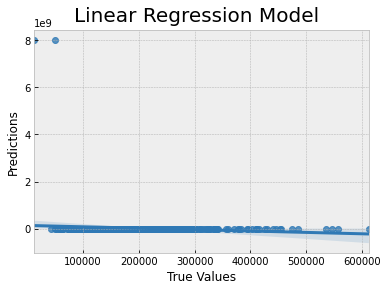

Training R2 (Basic LR) : 0.9231
Testing R2 (Basic LR) : -31888524.9677
Cross Val Score (Basic LR) : -6.674447198649704e+22
Adjusted R2 (Basic LR) :   -4.10472
RMSE (Basic LR) : 1.275714306143022e+16
Difference in R2 (Overfitting) : 3188852589.08%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 15.0
Training R2 (RR) : 0.9226
Testing R2 (RR) : 0.9072
Estimate of testing R2 (RR) is: 0.8967
RMSE (RR) : 25175.0964
Adjusted R2 (RR) :    0.88061


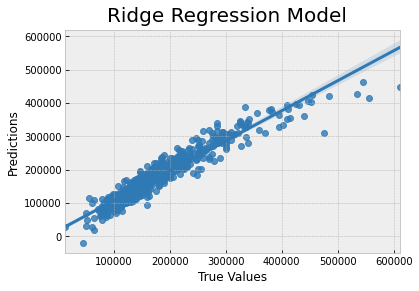

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 266.28244394072755
Training R2 (Lasso) : 0.9197
Testing R2 (Lasso) : 0.908
Estimate of testing R2 (Lasso) is: 0.899128
RMSE (Lasso) : 24878.1799
Adjusted R2 (Lasso) :    0.88153


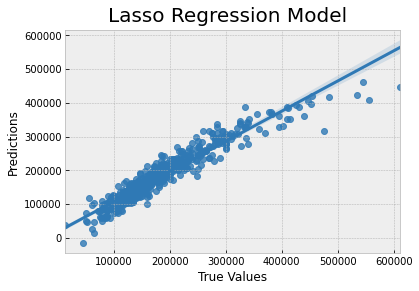

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.9104
Testing R2 (ENET) : 0.8981
Estimate of testing R2 (ENET) is: 0.893057
RMSE (ENET) : 25622.4757
Adjusted R2 (ENET) :    0.8689



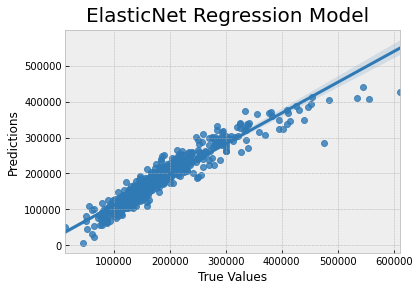

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 300*****************************************


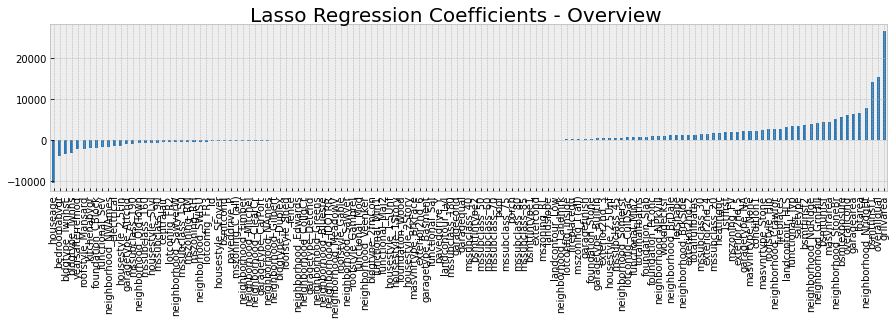

Adjusted R2            R2          RMSE
Linear         -4.1047 -6.674447e+22  1.275714e+16
Ridge           0.8806  8.967000e-01  2.517510e+04
Lasso           0.8815  8.991000e-01  2.487818e+04
ElasticNet      0.8689  8.931000e-01  2.562248e+04

Index(['landslope', 'extercond', 'bsmtfintype1', 'bsmtfintype2', 'garagequal',
       'garagecond', 'pool', 'porch', 'mssubclass_180', 'mssubclass_40',
       'mssubclass_50', 'mssubclass_60', 'mssubclass_70', 'mssubclass_75',
       'mssubclass_80', 'mssubclass_85', 'mszoning_RL', 'landcontour_Low',
       'landcontour_Lvl', 'neighborhood_Blueste', 'neighborhood_CollgCr',
       'neighborhood_Edwards', 'neighborhood_Greens', 'neighborhood_IDOTRR',
       'neighborhood_MeadowV', 'neighborhood_Sawyer', 'neighborhood_Veenker',
       'bldgtype_2fmCon', 'housestyle_1.5Unf', 'housestyle_1Story',
       'housestyle_2Story', 'roofstyle_Gable', 'roofstyle_Gambrel',
       'exterior2nd_6', 'masvnrtype_BrkFace', 'foundation_Wood',
       'functional_Maj2', 'functional_Min1', 'functional_Mod',
       'functional_Sal', 'garagetype_Basment', 'garagetype_Detchd',
       'paveddrive_Y'],
      dtype='object')
*************************************************OVERVIEW**********************************

In [21]:
final_overview(X,y,"Model 1: All Regressors",1,5,300)

**Model Evaluation**
- For Model 1, we can conclude that our model with all 137 columns does not work well with Linear Regression. However, as we introduce biasness into the model via. Ridge, Lasso and ElasticNet regressions, we observe a significant improvement in our R^2 and RMSE results. 
    - Linear Regression gave us an extremely negative R^2. This means that a base model by taking the mean of saleprice would perform much better than our current model. A key reason for this abnormal R^2 results could be due to two outlier predictions (as seen from the prediction/true values graph. This could be a result of insufficient data cleaning.
    - R^2 with all 137 columns amounted to about 0.89 for all other regression models. This essentially means that 89% of the variance of 'saleprice' is explained by our 137 regressors. 
    - However, a model with 137 regressors is not user-friendly for our clients and analysts to price their houses of interest. Hence, we will explore other models which has less variables, and a higher R^2/RMSE. 
    - Our lasso model returned a list of columns where coefficients are 0. We will create another model to observe the R2 and MSE for the new model where these terms are removed. We will remove "ID" as ID will not affect saleprice. 

### Model 2: Dropping columns that have been made zero by lasso regression in Model 1 (Top-down Filtering)

In [22]:
X.shape

(2047, 137)

In [23]:
model2_cols_to_drop = ['id','landslope', 'extercond', 'bsmtfintype1', 'bsmtfintype2', 'garagequal',
       'garagecond', 'pool', 'porch', 'mssubclass_180', 'mssubclass_40',
       'mssubclass_50', 'mssubclass_60', 'mssubclass_70', 'mssubclass_75',
       'mssubclass_80', 'mssubclass_85', 'mszoning_RL', 'landcontour_Low',
       'landcontour_Lvl', 'neighborhood_Blueste', 'neighborhood_CollgCr',
       'neighborhood_Edwards', 'neighborhood_Greens', 'neighborhood_IDOTRR',
       'neighborhood_MeadowV', 'neighborhood_Sawyer', 'neighborhood_Veenker',
       'bldgtype_2fmCon', 'housestyle_1.5Unf', 'housestyle_1Story',
       'housestyle_2Story', 'roofstyle_Gable', 'roofstyle_Gambrel',
       'exterior2nd_6', 'masvnrtype_BrkFace', 'foundation_Wood',
       'functional_Maj2', 'functional_Min1', 'functional_Mod',
       'functional_Sal', 'garagetype_Basment', 'garagetype_Detchd',
       'paveddrive_Y']
X_model2 = X.drop(columns = model2_cols_to_drop)

In [24]:
print(X_model2.shape)
print(y.shape)

(2047, 93)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 93)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


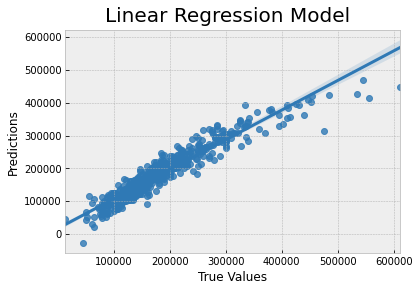

Training R2 (Basic LR) : 0.9211
Testing R2 (Basic LR) : 0.9059
Cross Val Score (Basic LR) : -1.5730613366826771e+22
Adjusted R2 (Basic LR) :    0.8892

RMSE (Basic LR) : 5197869119747028.0
Difference in R2 (Overfitting) : 1.51%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 15.0
Training R2 (RR) : 0.9209
Testing R2 (RR) : 0.906
Estimate of testing R2 (RR) is: 0.9011
RMSE (RR) : 24633.7274
Adjusted R2 (RR) :    0.88925


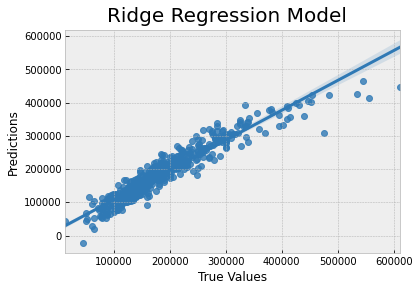

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 94.55784582756948
Training R2 (Lasso) : 0.9209
Testing R2 (Lasso) : 0.9071
Estimate of testing R2 (Lasso) is: 0.901286
RMSE (Lasso) : 24614.3901
Adjusted R2 (Lasso) :    0.89048


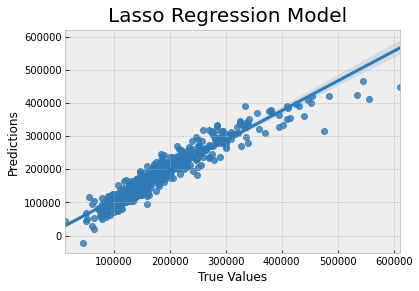

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.91
Testing R2 (ENET) : 0.8973
Estimate of testing R2 (ENET) is: 0.895948
RMSE (ENET) : 25273.8785
Adjusted R2 (ENET) :    0.87895


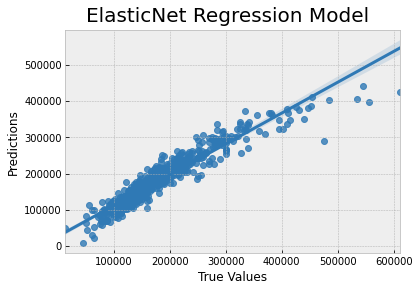

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 350*****************************************


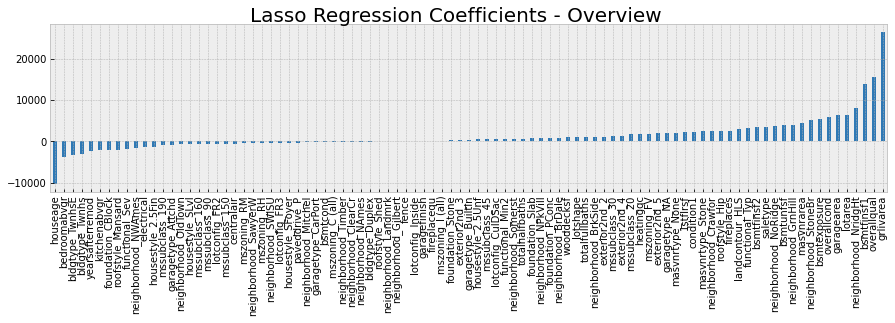

Index(['fence', 'neighborhood_Gilbert', 'neighborhood_Landmrk',
       'roofstyle_Shed'],
      dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2            R2          RMSE
Linear          0.8892 -1.573061e+22  5.197869e+15
Ridge           0.8892  9.011000e-01  2.463373e+04
Lasso           0.8904  9.013000e-01  2.461439e+04
ElasticNet      0.8789  8.959000e-01  2.527388e+04

In [25]:
final_overview(X_model2,y,"Model 2",1,5,350)

**A deeper dive into the Lasso coefficients. We want to filter out the variables that gives us the largest coefficients**

In [26]:
# Lasso Regression
lasso = Lasso(alpha=350)
lasso.fit(X_train_scaled,y_train)
lasso_cv_scores = cross_val_score(lasso,X_train_scaled,y_train,cv=5)
    
lasso_coef_series = pd.Series(lasso.coef_,index=X.columns)
lasso_coef_df = pd.Series.to_frame(lasso_coef_series)
lasso_coef_df.rename(columns={0:'coefficient'},inplace=True)
lasso_coef_df=lasso_coef_df.sort_values(by='coefficient',ascending=False)

In [27]:
lasso_coef_df.tail()

coefficient
yearsafterremod  -2343.948141
bldgtype_Twnhs   -3062.251387
bldgtype_TwnhsE  -3214.934478
bedroomabvgr     -3812.679628
houseage        -10375.435489

In [28]:
lasso_coef_df_modified = np.abs(lasso_coef_df['coefficient']).to_frame().sort_values(by='coefficient',ascending=False)
lasso_coef_df_modified.head()

coefficient
grlivarea             26501.634042
overallqual           15564.008477
bsmtfinsf1            13781.810166
houseage              10375.435489
neighborhood_NridgHt   7973.981278

**Model Evaluation**
- There are 93 regressors in Model 2. We have reduced the number of regressors (from model 1) by 44. 
    - However, 93 regressors is still a sizeable number and users of the 'survey' or 'form' to impute these data would find this process tedious. 
- There is a significant improvement in our Linear Regression model 2 as compared to model 1. Our Linear Regression model has returned a decent adjusted-R^2 of 0.89, however as indicated by RMSE and R^2 values, the model still returned a performance worse than base model. 
- Again, all other regression types were able to weed out the incoherence in the data by adding bias. Hence, R^2 and RMSE looked good. 
- We will further experiment with more models with this model's results in mind. Two models that I will be experimenting after Model 2:
    - Model 3: Top 40 Lasso coefficients generated by Model 2. (Absolute coefficients). 
    - Model 4: Top 20 Lasso coefficients generated by Model 2. (Absolute coefficients). 

### Model 3: Top 40 ranked Absolute Lasso Coefficients Based on Model 1 (Bottom-up)

In [29]:
print(lasso_coef_df_modified.head(40).index)

Index(['grlivarea', 'overallqual', 'bsmtfinsf1', 'houseage',
       'neighborhood_NridgHt', 'lotarea', 'garagearea', 'overallcond',
       'bsmtexposure', 'neighborhood_StoneBr', 'masvnrarea',
       'neighborhood_GrnHill', 'bsmtunfsf', 'neighborhood_NoRidge',
       'bedroomabvgr', 'saletype', 'bsmtfinsf2', 'bldgtype_TwnhsE',
       'functional_Typ', 'bldgtype_Twnhs', 'landcontour_HLS',
       'neighborhood_Crawfor', 'roofstyle_Hip', 'fireplaces',
       'yearsafterremod', 'condition1', '1stflrsf', 'masvnrtype_Stone',
       'kitchenabvgr', 'foundation_CBlock', 'roofstyle_Mansard',
       'garagetype_NA', 'exterior2nd_5', 'mszoning_FV', 'heatingqc',
       'functional_Sev', 'mssubclass_20', 'masvnrtype_None',
       'neighborhood_NWAmes', 'electrical'],
      dtype='object')


In [30]:
model3_cols_to_keep = lasso_coef_df_modified.head(40).index.tolist()
type(model3_cols_to_keep)

list

In [31]:
X_model3 = train_dummy[model3_cols_to_keep]
y = train_dummy[['saleprice']]

In [32]:
print(X_model3.shape)
print(y.shape)

(2047, 40)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 40)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


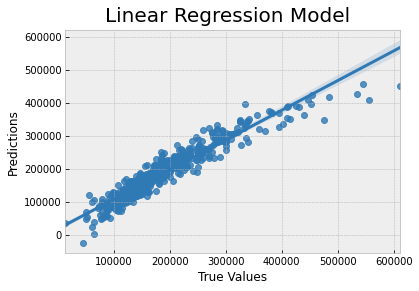

Training R2 (Basic LR) : 0.9145
Testing R2 (Basic LR) : 0.9073
Cross Val Score (Basic LR) : 0.9021
Adjusted R2 (Basic LR) :    0.9008

RMSE (Basic LR) : 24502.9258
Difference in R2 (Overfitting) : 0.72%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 14.02
Training R2 (RR) : 0.9144
Testing R2 (RR) : 0.9073
Estimate of testing R2 (RR) is: 0.9023
RMSE (RR) : 24475.5643
Adjusted R2 (RR) :    0.90083


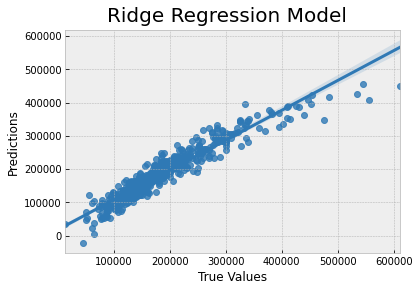

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 11.209983168048986
Training R2 (Lasso) : 0.9145
Testing R2 (Lasso) : 0.9073
Estimate of testing R2 (Lasso) is: 0.902115
RMSE (Lasso) : 24501.5774
Adjusted R2 (Lasso) :    0.90087


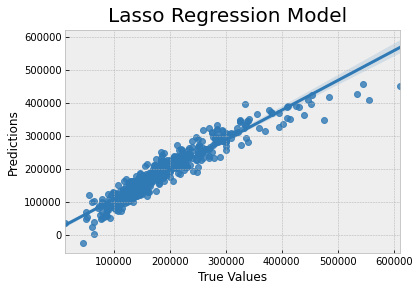

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.9042
Testing R2 (ENET) : 0.8976
Estimate of testing R2 (ENET) is: 0.895095
RMSE (ENET) : 25357.5482
Adjusted R2 (ENET) :    0.89048


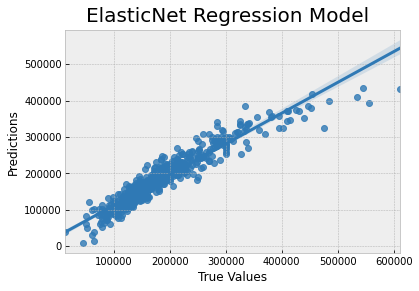

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 250*****************************************


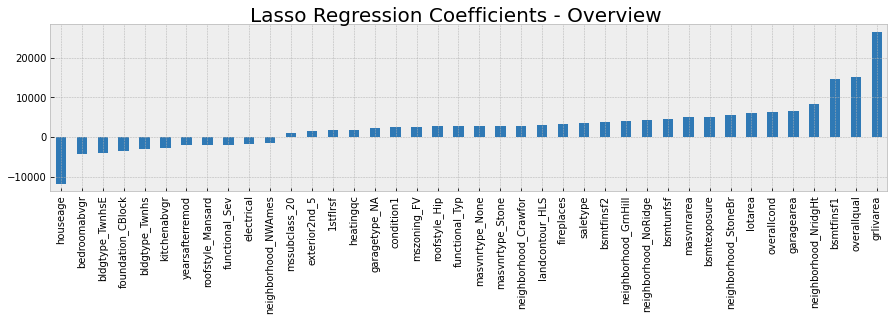

Index([], dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear          0.9008  0.9021  24502.9258
Ridge           0.9008  0.9023  24475.5643
Lasso           0.9008  0.9021  24501.5774
ElasticNet      0.8904  0.8951  25357.5482

In [33]:
final_overview(X_model3,y,"Model 3",1,5)

**Model Evaluation**
- As expected, Model 3 does not have any lasso coefficients that are equals to 0. This means that all regressors here were selected by Lasso as effective in explaining our variances in 'saleprice'. 
- Ridge regression performed best amongst all other regression models for Model 3, achieving higher R^2 and lower RMSE than other models, as well as Model 2. 
- The Linear Regression has 'normalised' in this model, ie. it does not have abnormally large R^2 and RMSE. 
    - This suggest that we have removed some of the variables that have previously severely skewed our regression model.
- Since Model 3 is comparatively the best model thus far. We will check against other models to see if this will be our final model. 

### Model 4: Top 20 ranked Absolute Lasso Coefficients Based on Model 1 (Bottom-up)

In [34]:
print(lasso_coef_df_modified.head(20).index)

Index(['grlivarea', 'overallqual', 'bsmtfinsf1', 'houseage',
       'neighborhood_NridgHt', 'lotarea', 'garagearea', 'overallcond',
       'bsmtexposure', 'neighborhood_StoneBr', 'masvnrarea',
       'neighborhood_GrnHill', 'bsmtunfsf', 'neighborhood_NoRidge',
       'bedroomabvgr', 'saletype', 'bsmtfinsf2', 'bldgtype_TwnhsE',
       'functional_Typ', 'bldgtype_Twnhs'],
      dtype='object')


In [35]:
model4_cols_to_keep = lasso_coef_df_modified.head(20).index.tolist()

In [36]:
X_model4 = train_dummy[model4_cols_to_keep]
y = train_dummy[['saleprice']]

In [37]:
print(X_model4.shape)
print(y.shape)

(2047, 20)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 20)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


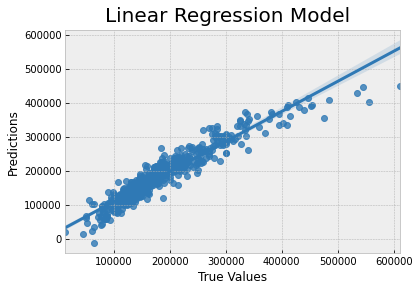

Training R2 (Basic LR) : 0.8941
Testing R2 (Basic LR) : 0.9019
Cross Val Score (Basic LR) : 0.8875
Adjusted R2 (Basic LR) :    0.8986

RMSE (Basic LR) : 26247.0914
Difference in R2 (Overfitting) : -0.77%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 10.33
Training R2 (RR) : 0.8941
Testing R2 (RR) : 0.9016
Estimate of testing R2 (RR) is: 0.8876
RMSE (RR) : 26237.4298
Adjusted R2 (RR) :    0.8983



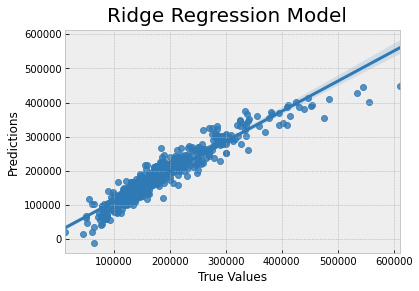

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 1.2589254117941673
Training R2 (Lasso) : 0.8941
Testing R2 (Lasso) : 0.9019
Estimate of testing R2 (Lasso) is: 0.887525
RMSE (Lasso) : 26247.1207
Adjusted R2 (Lasso) :    0.89857


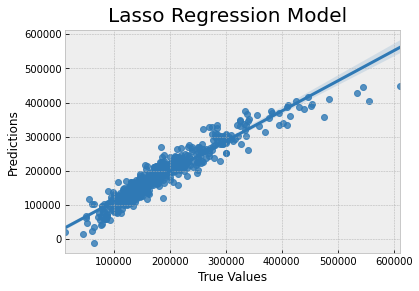

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.8832
Testing R2 (ENET) : 0.8863
Estimate of testing R2 (ENET) is: 0.878064
RMSE (ENET) : 27351.5387
Adjusted R2 (ENET) :    0.88246


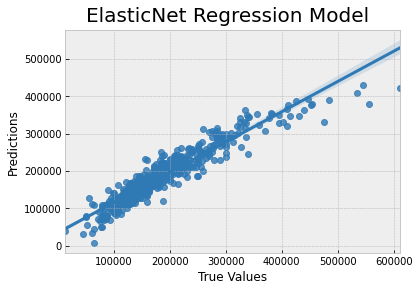

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 250*****************************************


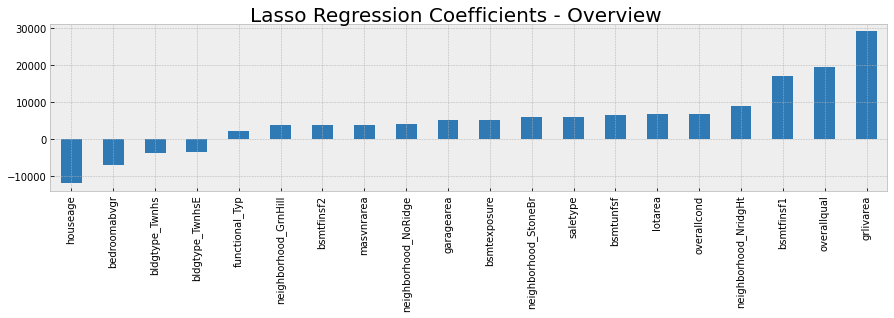

Index([], dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear          0.8986  0.8875  26247.0914
Ridge           0.8983  0.8876  26237.4298
Lasso           0.8985  0.8875  26247.1207
ElasticNet      0.8824  0.8781  27351.5387

In [38]:
final_overview(X_model4,y,"Model 4",0.1,1)

**Model Evaluation**
- As compared to Model 3, Model 4 experimented with top 20 regressors that provided the highest lasso coefficients (compared to top 40 in model 3). 
    - The reason behind this choice of experiment is because we hope to make our clients and analysts performing this price prediction, with a better user experience. Hence, having 20 variables is better than 40 variables. 
- However, Model 4 achieved a lower R^2 and higher RMSE than Model 3. This means that there were a few regressors that were removed from Model 3 to 4, that were very useful in explaining the variance in 'saleprice'. 
- Even though it is a model that only has 20 regressors, we will stick with Model 3 as that would be best for predicting saleprices, which is our main goal for this exercise.
    - As this is a consultancy business, we have no qualms about obtaining more information and would not trade-off model performance for user-friendliness. This is because our end users will primarily be our analysts and consultants, who will work closely with our end-clients to gather data essentially for our model. 

### Model 5: Tuning Model 2 to remove multi-collinear variables (Top-down Filtering)
#### For a top-down approach, we will continue to tweak model 2 to obtain other models, and compare with our bottom-up model (Model 3). 
Since Model 2, a top-down approach, has given us an abnormally huge RMSE and negative R^2, we hope to check if there are any regressors that are highly correlated with one another, and remove these highly correlated variables to see if our model will have an improvement from Model 2. 

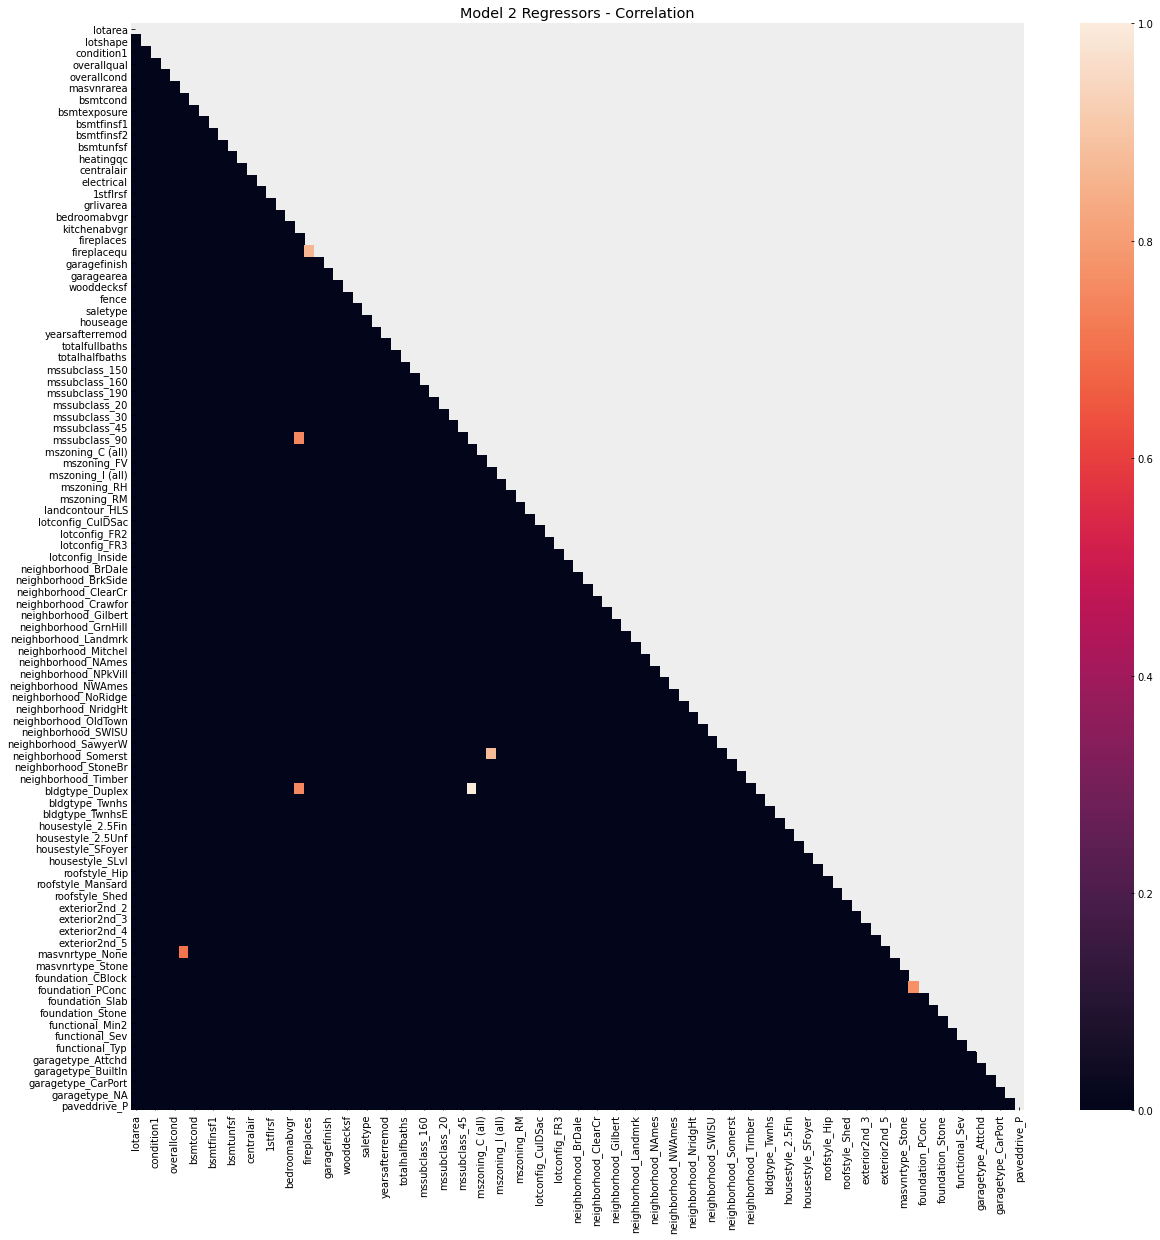

In [39]:
model2_corr= train_dummy[X_model2.columns].corr().abs()
model2_corr[((model2_corr)<0.7)]=0
custom_mask = np.zeros_like(model2_corr.corr())   
custom_mask[np.triu_indices_from(custom_mask)] = True  
plt.figure(figsize=(20,20))
sns.heatmap(model2_corr,mask=custom_mask)
plt.title("Model 2 Regressors - Correlation");

**Observations**
- Heatmap shows that there are only a few variables that are correlated to each other (correlation > 0.7). These pairs are highlighted in our correlation heatmap above. We will dive into the individual pairs to check the reasons why, and see if we can remove either of them. 
- We will now decide upon removing either of pairs by the following considerations:
    1. Comparison of correlation with Saleprice. If it is highly correlated, will prefer to keep the column.
    2. Logic - Will it make sense to drop the column based on conventional understanding?

In [40]:
X_model2_cols = X_model2.columns.tolist()
X_model2_cols.append('saleprice')

In [41]:
def model2_pairs(var1,var2):
    cols = [var1,var2,'saleprice']
    corr_df = round(train_dummy[cols].corr()[['saleprice']].sort_values(by='saleprice',ascending=True),3)
    return ('\n'+str(corr_df.iloc[0:2,:]))

In [42]:
model2_corr= train_dummy[X_model2.columns].corr().abs()
model2_highcorr = (model2_corr.where(np.triu(np.ones(model2_corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
round(model2_highcorr[model2_highcorr>0.7],2)

mssubclass_90      bldgtype_Duplex         1.00
mszoning_FV        neighborhood_Somerst    0.87
fireplaces         fireplacequ             0.86
foundation_CBlock  foundation_PConc        0.77
kitchenabvgr       bldgtype_Duplex         0.75
                   mssubclass_90           0.75
masvnrarea         masvnrtype_None         0.70
dtype: float64

In [43]:
print(model2_pairs('mssubclass_90','bldgtype_Duplex'))
print(model2_pairs('mszoning_FV','neighborhood_Somerst'))
print(model2_pairs('fireplaces','fireplacequ'))
print(model2_pairs('foundation_CBlock','foundation_PConc'))
print(model2_pairs('kitchenabvgr','bldgtype_Duplex'))
print(model2_pairs('kitchenabvgr','mssubclass_90'))
print(model2_pairs('garagetype_Attchd','garagetype_Detchd'))
print(model2_pairs('masvnrarea','masvnrtype_None'))


                 saleprice
mssubclass_90       -0.104
bldgtype_Duplex     -0.104

                      saleprice
mszoning_FV               0.107
neighborhood_Somerst      0.151

             saleprice
fireplaces       0.472
fireplacequ      0.539

                   saleprice
foundation_CBlock     -0.358
foundation_PConc       0.531

                 saleprice
kitchenabvgr        -0.125
bldgtype_Duplex     -0.104

               saleprice
kitchenabvgr      -0.125
mssubclass_90     -0.104

                   saleprice
garagetype_Detchd     -0.370
garagetype_Attchd      0.357

                 saleprice
masvnrtype_None     -0.411
masvnrarea           0.512


**Conclusions on Removal of Regressors**
- After analysing the correlations to saleprice of each regressor of interest, I have decided to remove the following from our regression on the basis that they have lower correlation than the other regressor in each pair.
    - mssubclass_90 (Also correlated with kitchenabvgr and has a lower correlation to saleprice.).
    - MSZoning_FV
    - Fireplaces
    - Foundation_CBlock
    - bldgtype_Duplex
    - garagetype_Attchd
    - masvnrtype_None

In [44]:
X_model2.shape

(2047, 93)

In [45]:
# Model 5 will have 7 less regressors than model 2:
model5_cols_to_drop = ['mssubclass_90','mszoning_FV','fireplaces',
                       'foundation_CBlock','bldgtype_Duplex',
                       'garagetype_Attchd','masvnrtype_None']
X_model5 = X_model2.drop(columns=model5_cols_to_drop)
X_model5.shape

(2047, 86)

In [46]:
X_model5 = train_dummy[X_model5.columns]
y = train_dummy[['saleprice']]

In [47]:
print(X_model5.shape)
print(y.shape)

(2047, 86)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 86)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


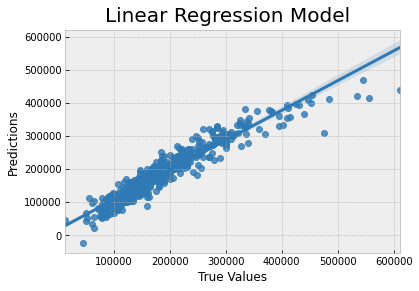

Training R2 (Basic LR) : 0.9195
Testing R2 (Basic LR) : 0.9048
Cross Val Score (Basic LR) : 0.896
Adjusted R2 (Basic LR) :    0.8893

RMSE (Basic LR) : 25249.7088
Difference in R2 (Overfitting) : 1.48%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 15.0
Training R2 (RR) : 0.9193
Testing R2 (RR) : 0.9046
Estimate of testing R2 (RR) is: 0.9007
RMSE (RR) : 24683.2596
Adjusted R2 (RR) :    0.88912


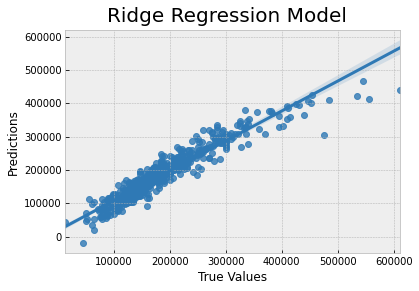

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 110.38353304926363
Training R2 (Lasso) : 0.9193
Testing R2 (Lasso) : 0.906
Estimate of testing R2 (Lasso) is: 0.900834
RMSE (Lasso) : 24670.2869
Adjusted R2 (Lasso) :    0.8907



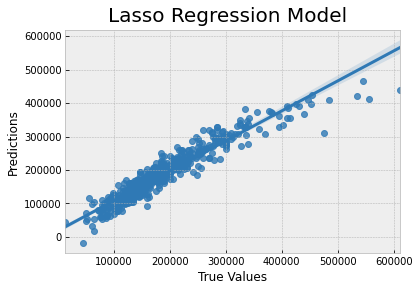

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.9088
Testing R2 (ENET) : 0.8956
Estimate of testing R2 (ENET) is: 0.895307
RMSE (ENET) : 25350.2437
Adjusted R2 (ENET) :    0.87864


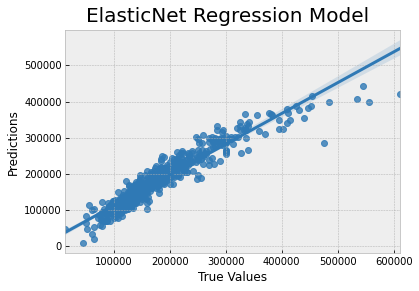

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 300*****************************************


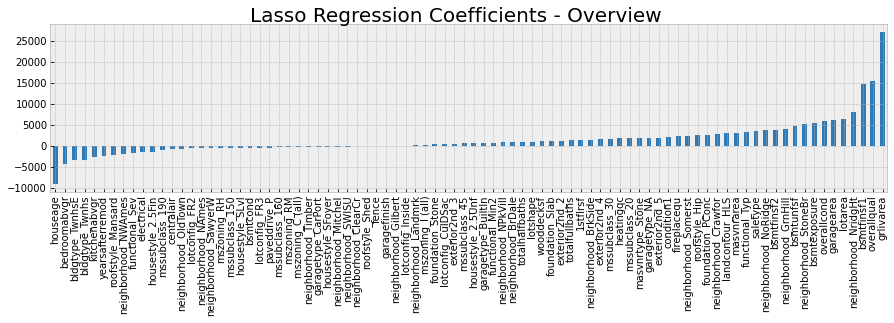

Index(['garagefinish', 'neighborhood_Gilbert'], dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear          0.8893  0.8960  25249.7088
Ridge           0.8891  0.9007  24683.2596
Lasso           0.8907  0.9008  24670.2869
ElasticNet      0.8786  0.8953  25350.2437

In [48]:
final_overview(X_model5,y,"Model 5",1,5,300)

**Model Evaluation**
- Model 5 performance is similar to Model 2, for Ridge/Lasso and ElasticNet regressions. However, Model 5 has significantly improved compared to Model 2, for Linear Regression.
    - This means that of the 7 regressors we have weeded out, at least one of them have severely skewed our data. 
- For a top-down feature selection approach, we will use Model 5 and tune it for better performance. Thereafter, we will compare it against bottom-up feature selection approach and select the model with best performance. 
- Note that ['extercond', 'garagefinish', 'neighborhood_CollgCr','neighborhood_Gilbert'] has been eliminated from our lasso regression (alpha=300). 

### Model 6: Picking Regressors with the Highest Correlation to Saleprice (Bottom-up)
This is a new approach, unrelated to previous models. This is an experiment for us to see if our model that selects features that are, itself, moderately-highly correlated to our dependent variable, would perform well. 

Hence, we are selecting all features that have correlation coefficient in excess of 0.5 with saleprice, and fit it into our model. 

In [49]:
train_dummy_corr = train_dummy.corr()[['saleprice']]
train_dummy_corr_filtered = train_dummy_corr[np.abs(train_dummy_corr['saleprice'])>0.5].index.tolist()

In [50]:
train_dummy_corr[np.abs(train_dummy_corr['saleprice'])>0.5].sort_values(by='saleprice',ascending=False)

saleprice
saleprice          1.000000
overallqual        0.803859
grlivarea          0.719230
garagearea         0.655678
1stflrsf           0.647680
totalfullbaths     0.589820
garagefinish       0.559204
fireplacequ        0.539191
foundation_PConc   0.531408
masvnrarea         0.512471
yearsafterremod   -0.551439
houseage          -0.572978

In [51]:
print(len(train_dummy_corr_filtered))
train_dummy_corr_filtered

12


['overallqual',
 'masvnrarea',
 '1stflrsf',
 'grlivarea',
 'fireplacequ',
 'garagefinish',
 'garagearea',
 'saleprice',
 'houseage',
 'yearsafterremod',
 'totalfullbaths',
 'foundation_PConc']

In [52]:
model6_cols = train_dummy_corr_filtered
model6_cols.remove('saleprice')

In [53]:
X_model6 = train_dummy[model6_cols]
y = train_dummy[['saleprice']]

In [54]:
print(X_model6.shape)
print(y.shape)

(2047, 11)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 11)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


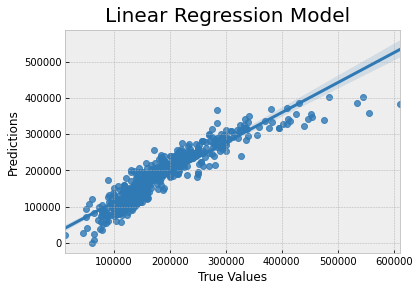

Training R2 (Basic LR) : 0.8327
Testing R2 (Basic LR) : 0.8466
Cross Val Score (Basic LR) : 0.8282
Adjusted R2 (Basic LR) :    0.8438

RMSE (Basic LR) : 32476.2198
Difference in R2 (Overfitting) : -1.39%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 15.0
Training R2 (RR) : 0.8327
Testing R2 (RR) : 0.8463
Estimate of testing R2 (RR) is: 0.8283
RMSE (RR) : 32461.2117
Adjusted R2 (RR) :    0.84352


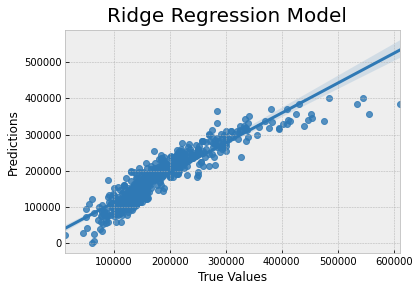

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 10.0
Training R2 (Lasso) : 0.8327
Testing R2 (Lasso) : 0.8466
Estimate of testing R2 (Lasso) is: 0.828191
RMSE (Lasso) : 32476.1876
Adjusted R2 (Lasso) :    0.84379


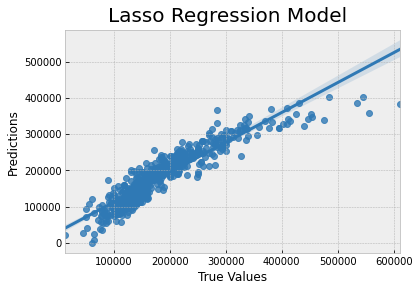

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.8278
Testing R2 (ENET) : 0.8373
Estimate of testing R2 (ENET) is: 0.825377
RMSE (ENET) : 32732.3213
Adjusted R2 (ENET) :    0.83429


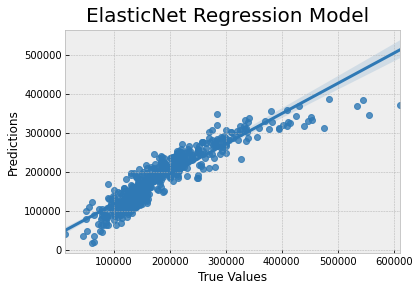

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 500*****************************************


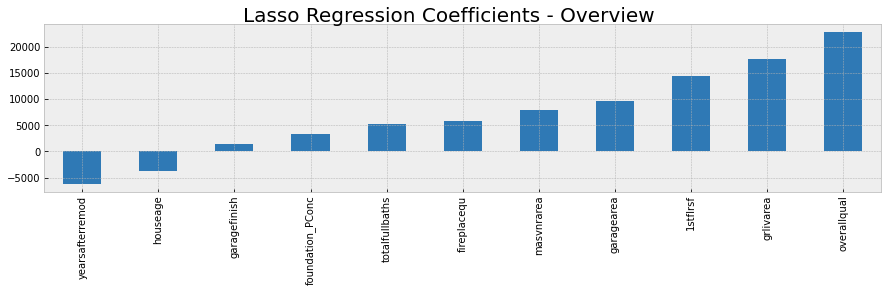

Index([], dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear          0.8438  0.8282  32476.2198
Ridge           0.8435  0.8283  32461.2117
Lasso           0.8437  0.8282  32476.1876
ElasticNet      0.8342  0.8254  32732.3213

In [55]:
final_overview(X_model6,y,"Model 6",1,5,L_alpha=500)

**Model Evalaluation**
- There are only 11 regressors that has correlation in excess of 0.5 to saleprices. 
    - From a consultancy's point of view, we can engineer a similar model with this number of regressors, to create an ultra-lite prediction model for our clients' use.
- However, it seems that this model with 11 regressors only explained 84% of our variances in saleprice (adjusted R^2), which means that there are still a sizeable 16% variance that are unexplained. 
- Hence, even though it might be a user-friendly prediction model, we do not want to compromise our quality provided to our clients by compromising on the R^2 and RMSE of our model.
- We will drop this model and not continue to build on it. 

### Model 7: Using Statistic Summary to Remove Regressors from Model 5 (Top-down Filtering)

In [56]:
# We have decided to improve on Model 5, due to its high R2 and lower RMSE (comparatively)
X_OLS = X_model5
X_OLS = sm.add_constant(X_model5,prepend=False)
y_OLS = train_dummy['saleprice']

In [57]:
modelOLS = sm.OLS(y_OLS,X_OLS).fit()
modelOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     254.0
Date:                Thu, 27 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:54:49   Log-Likelihood:                -23440.
No. Observations:                2047   AIC:                         4.705e+04
Df Residuals:                    1960   BIC:                         4.754e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
lotarea                  1.2448      0.139      8.983      0.000       0.973       1.517
lotshape              1382.8712   1105.177      1.251      0.211    -784.574    3550.316
condition1            1.541e+04   3912.967      3.937      0.000    7731.513    2.31e+04
overallqual           1.047e+04    722.492     14.489      0.000    9051.330    1.19e+04
overallcond           5677.3672    643.377      8.824      0.000    4415.593    6939.142
masvnrarea              22.3596      3.954      5.655      0.000      14.605      30.114
bsmtcond             -3393.7039   1418.699     -2.392      0.017   -6176.022    -611.386
bsmtexposure          4720.9526    660.627      7.146      0.000    3425.347    6016.559
bsmtfinsf1              41.4113      3.122     13.264      0.000      35.288      47.534
bsmtfinsf2              32.9379      4.388      7.507      0.000      24.333      41.543
bsmtunfsf               18.7556      2.950      6.359      0.000      12.971      24.540
heatingqc             2002.5746    737.554      2.715      0.007     556.101    3449.048
centralair           -4673.0086   2624.045     -1.781      0.075   -9819.220     473.202
electrical           -2899.2634   2078.792     -1.395      0.163   -6976.138    1177.611
1stflrsf                -3.7662      4.039     -0.932      0.351     -11.688       4.156
grlivarea               61.0744      3.235     18.880      0.000      54.730      67.419
bedroomabvgr         -5720.6788    938.296     -6.097      0.000   -7560.841   -3880.517
kitchenabvgr         -1.348e+04   3198.314     -4.215      0.000   -1.98e+04   -7208.348
fireplacequ           1139.8047    381.434      2.988      0.003     391.746    1887.863
garagefinish          1207.0134    921.634      1.310      0.190    -600.472    3014.498
garagearea              24.1081      4.116      5.857      0.000      16.036      32.180
wooddecksf               7.6738      4.542      1.689      0.091      -1.235      16.582
fence                  444.0994    466.036      0.953      0.341    -469.879    1358.077
saletype              1.782e+04   2269.566      7.853      0.000    1.34e+04    2.23e+04
houseage              -291.8194     47.273     -6.173      0.000    -384.530    -199.108
yearsafterremod       -113.5720     42.167     -2.693      0.007    -196.269     -30.875
totalfullbaths        1201.8515   1146.116      1.049      0.294   -1045.883    3449.586
totalhalfbaths        1148.3028   1321.757      0.869      0.385   -1443.894    3740.499
mssubclass_150       -2.218e+04   2.46e+04     -0.901      0.368   -7.05e+04    2.61e+04
mssubclass_160       -3195.5371   4284.354     -0.746      0.456   -1.16e+04    5206.831
mssubclass_190       -8769.5652   3885.836     -2.257      0.024   -1.64e+04   -1148.760
mssubclass_20         3733.1926   2420.266      1.542    

For reference to obtaining parameters for sm.OLS: 
https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLSResults.html#statsmodels.regression.linear_model.OLSResults

<blockquote>
    Regression analysis is a form of inferential statistics. The p-values help determine whether the relationships that you observe in your sample also exist in the larger population. The p-value for each independent variable tests the null hypothesis that the variable has no correlation with the dependent variable. If there is no correlation, there is no association between the changes in the independent variable and the shifts in the dependent variable. In other words, there is insufficient evidence to conclude that there is effect at the population level.
    
Source: https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/
    </blockquote>

In [58]:
# I will extract the coefficients, standard errors and p-values so that I can perform filtering, 
# and extract features that are relevant for my next model
coefficients = modelOLS.params
standard_errors = modelOLS.bse
p_values = modelOLS.pvalues

In [59]:
modelOLS_df = coefficients.to_frame(name='coefficients')
modelOLS_df['standard_errors'] = pd.Series(standard_errors)
modelOLS_df['p_values'] = pd.Series(p_values)

In [60]:
ten_percentile = modelOLS_df['coefficients'].mean()*0.1
small_coef = modelOLS_df[np.abs(modelOLS_df['coefficients'])< ten_percentile].index
large_se = modelOLS_df[modelOLS_df['standard_errors']>1000].index
large_p = modelOLS_df[modelOLS_df['p_values']>0.05].index

In [61]:
print(len(small_coef))
print(len(large_se))
print(len(large_p))

14
68
39


In [62]:
# I will not look into small coefficients as that is not a preferred way to look for insignificant regressors. 
# I will look into variables where p-values are higher than 5%. 
# I will also look for variables where standard errors are more than 1,000. This is an arbitrary number. 
large_se_p = list(set(large_se) & set(large_p))
large_se = list(large_se)
large_p = list(large_p)
large_se_or_p = list(set(large_se) | set(large_p))

print(len(large_se_p))
print(len(large_se))
print(len(large_p))
print(len(large_se_or_p))

large_se.remove('const')

35
68
39
72


In [63]:
X_large_se_p = X_model5.drop(columns=large_se_p)
X_large_se = X_model5.drop(columns=large_se)
X_large_p = X_model5.drop(columns=large_p)

print(X_large_se_p.shape)
print(X_large_se.shape)
print(X_large_p.shape)

(2047, 51)
(2047, 19)
(2047, 47)


#### Model 7A: Tuning Model 5 - Removal of Statistically Insignificant Variables (high p-values)

In [64]:
X_model7a = train_dummy[X_large_p.columns]
y = train_dummy[['saleprice']]

In [65]:
print(X_model7a.shape)
print(y.shape)

(2047, 47)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 47)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


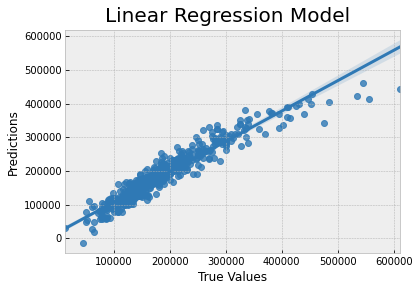

Training R2 (Basic LR) : 0.9153
Testing R2 (Basic LR) : 0.9117
Cross Val Score (Basic LR) : 0.9026
Adjusted R2 (Basic LR) :    0.9044

RMSE (Basic LR) : 24429.3261
Difference in R2 (Overfitting) : 0.36%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 15.0
Training R2 (RR) : 0.9152
Testing R2 (RR) : 0.9115
Estimate of testing R2 (RR) is: 0.9029
RMSE (RR) : 24398.5936
Adjusted R2 (RR) :    0.90413


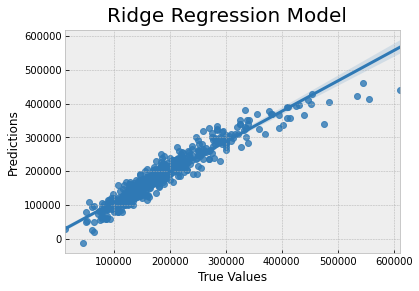

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 10.0
Training R2 (Lasso) : 0.9153
Testing R2 (Lasso) : 0.9117
Estimate of testing R2 (Lasso) is: 0.902623
RMSE (Lasso) : 24430.4462
Adjusted R2 (Lasso) :    0.9044



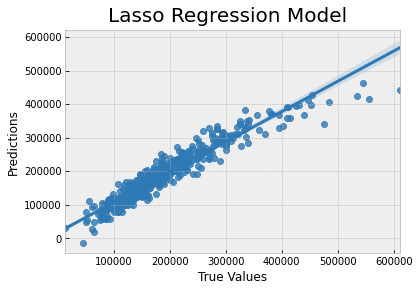

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.9035
Testing R2 (ENET) : 0.8977
Estimate of testing R2 (ENET) is: 0.893888
RMSE (ENET) : 25510.068
Adjusted R2 (ENET) :    0.8892



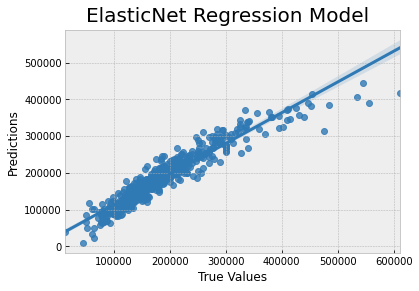

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 500*****************************************


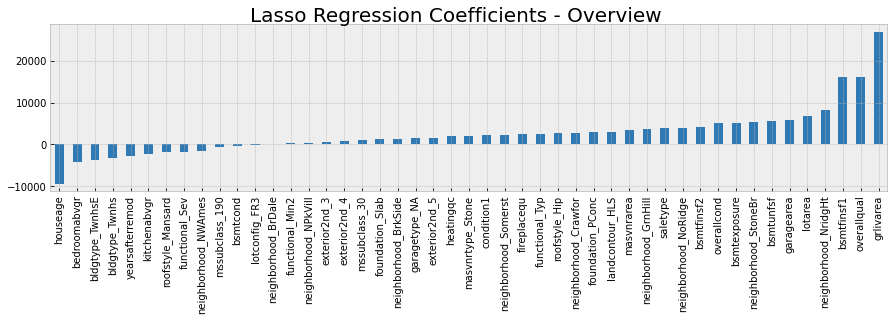

Index([], dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear          0.9044  0.9026  24429.3261
Ridge           0.9041  0.9029  24398.5936
Lasso           0.9044  0.9026  24430.4462
ElasticNet      0.8892  0.8939  25510.0680

In [66]:
final_overview(X_model7a,y,"Model 7A",1,5,500)

#### Model 7B: Tuning Model 5 - Removal of Variables with High Standard Errors

In [67]:
X_model7b = train_dummy[X_large_se.columns]
y = train_dummy[['saleprice']]

In [68]:
print(X_model7b.shape)
print(y.shape)

(2047, 19)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 19)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


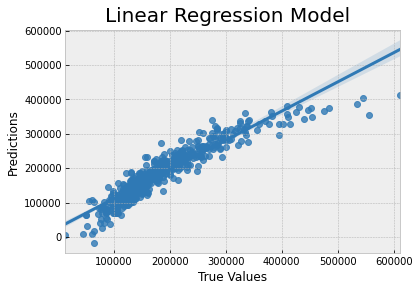

Training R2 (Basic LR) : 0.8741
Testing R2 (Basic LR) : 0.8691
Cross Val Score (Basic LR) : 0.8669
Adjusted R2 (Basic LR) :    0.865
d
RMSE (Basic LR) : 28545.8904
Difference in R2 (Overfitting) : 0.49%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 8.86
Training R2 (RR) : 0.874
Testing R2 (RR) : 0.8691
Estimate of testing R2 (RR) is: 0.8671
RMSE (RR) : 28525.9899
Adjusted R2 (RR) :    0.86487


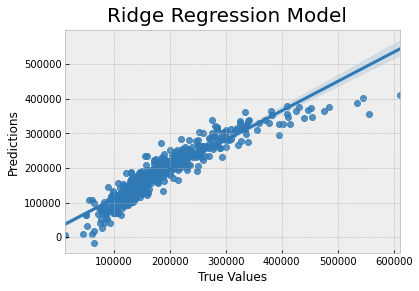

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 221.07236304470985
Training R2 (Lasso) : 0.8739
Testing R2 (Lasso) : 0.8697
Estimate of testing R2 (Lasso) is: 0.867227
RMSE (Lasso) : 28517.8986
Adjusted R2 (Lasso) :    0.86551


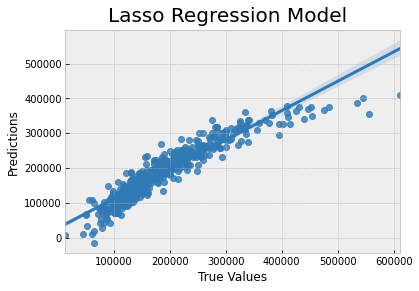

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.8638
Testing R2 (ENET) : 0.8573
Estimate of testing R2 (ENET) is: 0.85961
RMSE (ENET) : 29332.8883
Adjusted R2 (ENET) :    0.85272


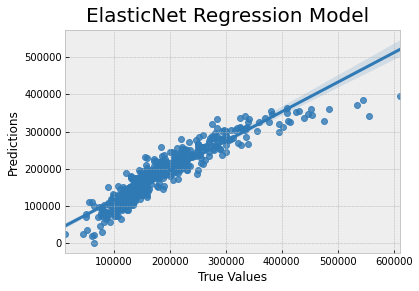

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 350*****************************************


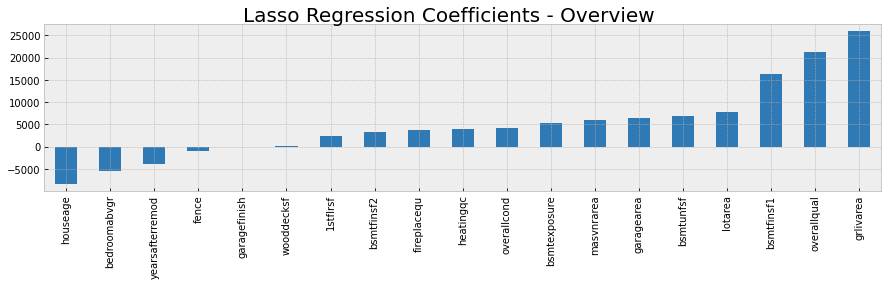

Index(['garagefinish'], dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear         0.865\n  0.8669  28545.8904
Ridge           0.8648  0.8671  28525.9899
Lasso           0.8655  0.8672  28517.8986
ElasticNet      0.8527  0.8596  29332.8883

In [69]:
final_overview(X_model7b,y,"Model 7B",1,5,350)

Note that 'garagefinish' has been eliminated from our lasso regression (alpha = 350)

#### Model 7C: Tuning Model 5 - Removal of Variables that are statistically insignificant or has high standard errors

In [70]:
X_model7c = train_dummy[X_large_se_p.columns]
y = train_dummy[['saleprice']]

In [71]:
print(X_model7c.shape)
print(y.shape)

(2047, 51)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 51)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


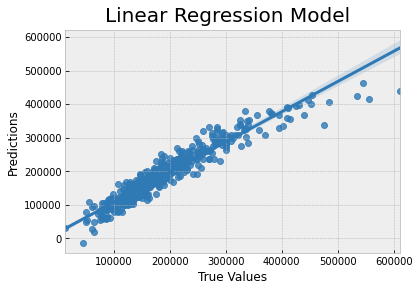

Training R2 (Basic LR) : 0.9155
Testing R2 (Basic LR) : 0.9121
Cross Val Score (Basic LR) : 0.9021
Adjusted R2 (Basic LR) :    0.9041

RMSE (Basic LR) : 24496.1859
Difference in R2 (Overfitting) : 0.35%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 10.19
Training R2 (RR) : 0.9155
Testing R2 (RR) : 0.9119
Estimate of testing R2 (RR) is: 0.9023
RMSE (RR) : 24473.1866
Adjusted R2 (RR) :    0.9039



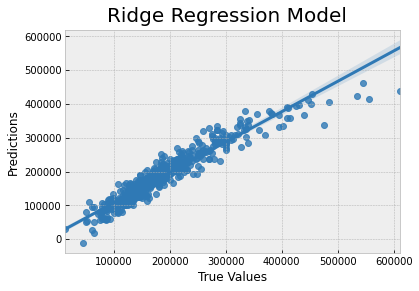

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 10.0
Training R2 (Lasso) : 0.9155
Testing R2 (Lasso) : 0.9121
Estimate of testing R2 (Lasso) is: 0.902142
RMSE (Lasso) : 24495.7589
Adjusted R2 (Lasso) :    0.90412


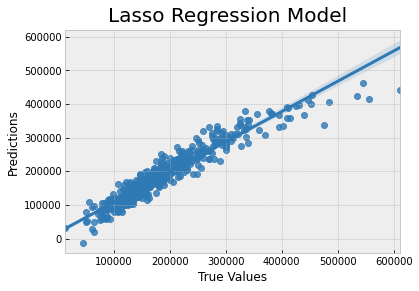

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.904
Testing R2 (ENET) : 0.8988
Estimate of testing R2 (ENET) is: 0.894015
RMSE (ENET) : 25496.1768
Adjusted R2 (ENET) :    0.88966


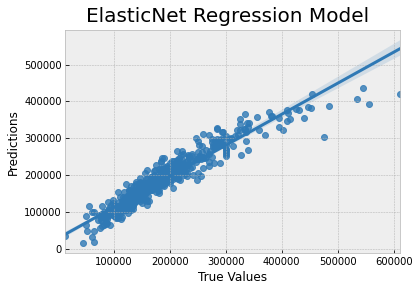

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 300*****************************************


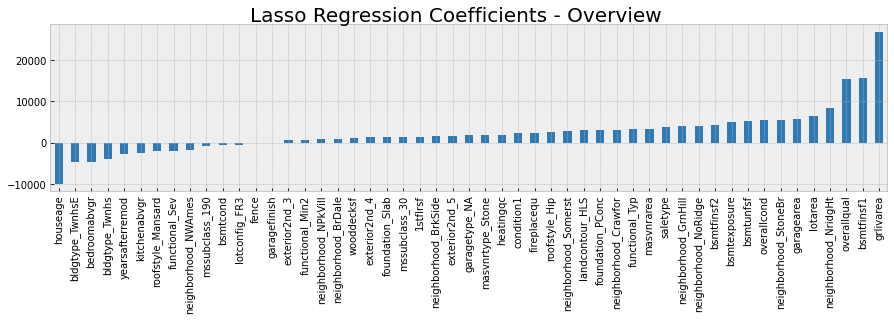

Index(['fence'], dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear          0.9041  0.9021  24496.1859
Ridge           0.9039  0.9023  24473.1866
Lasso           0.9041  0.9021  24495.7589
ElasticNet      0.8896  0.8940  25496.1768

In [72]:
final_overview(X_model7c,y,"Model 7C",1,5,300)

Out of all three models, 7A and 7C stood out as they have higher R^2 and lower RMSE than Model 2. 
Of the two models, I would choose to go with model 7A due to its' lower RMSE scores for its Ridge Regression model.
Note that "fence" has been eliminated from model 7C due to lasso regression (alpha = 300)

In [73]:
#Colummns for Model 7A
X_large_p.columns

Index(['lotarea', 'condition1', 'overallqual', 'overallcond', 'masvnrarea',
       'bsmtcond', 'bsmtexposure', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf',
       'heatingqc', 'grlivarea', 'bedroomabvgr', 'kitchenabvgr', 'fireplacequ',
       'garagearea', 'saletype', 'houseage', 'yearsafterremod',
       'mssubclass_190', 'mssubclass_30', 'landcontour_HLS', 'lotconfig_FR3',
       'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_Crawfor',
       'neighborhood_GrnHill', 'neighborhood_NPkVill', 'neighborhood_NWAmes',
       'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_Somerst',
       'neighborhood_StoneBr', 'bldgtype_Twnhs', 'bldgtype_TwnhsE',
       'roofstyle_Hip', 'roofstyle_Mansard', 'exterior2nd_3', 'exterior2nd_4',
       'exterior2nd_5', 'masvnrtype_Stone', 'foundation_PConc',
       'foundation_Slab', 'functional_Min2', 'functional_Sev',
       'functional_Typ', 'garagetype_NA'],
      dtype='object')

### Further Analysis of Model 7A
So far, we seem to be very fond of our Model 7A, as it gave us the best R^2 and lowest RMSE scores. However, we always strive to improve and fine-tune our model, hence we will be diving into this model to check if there are anything we can change to further improve the performance of our regression model.

#### A visual examination of our Model 7A regressors against saleprice.

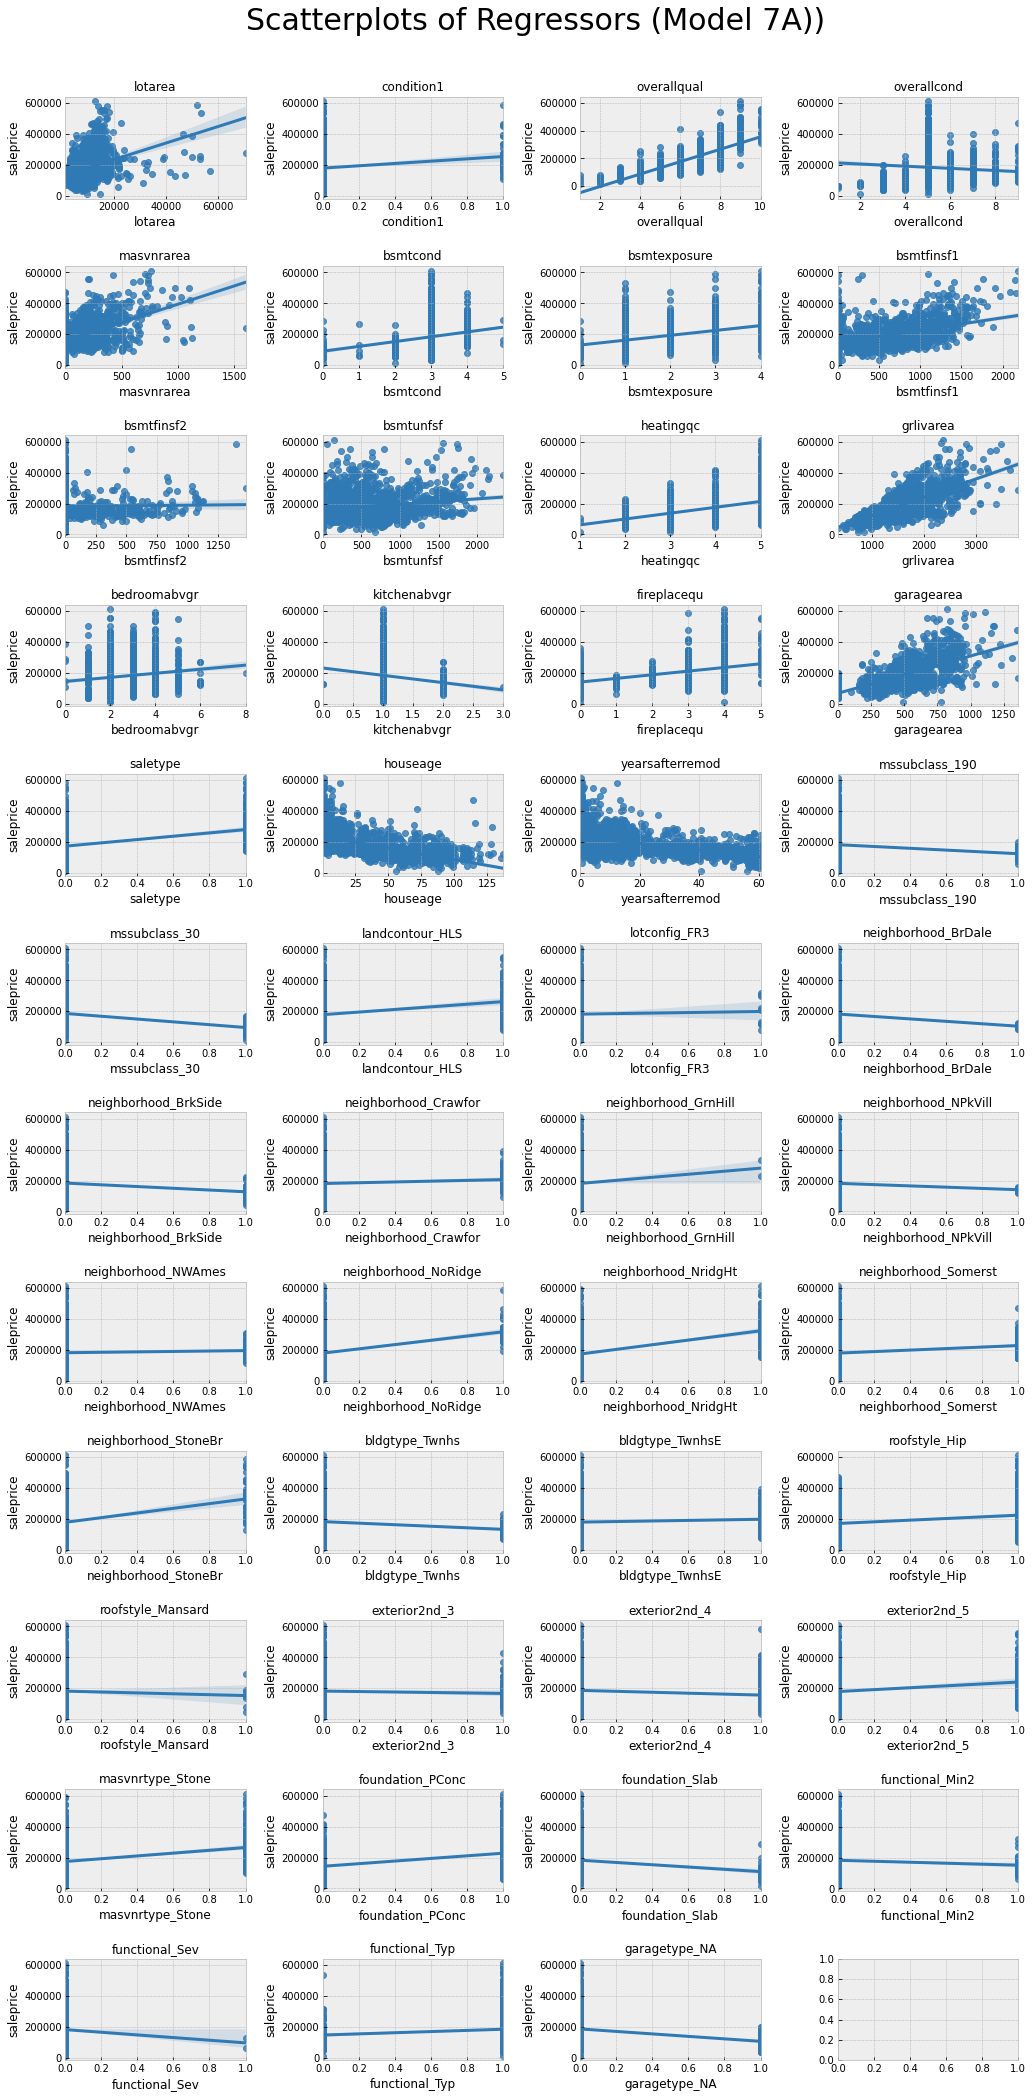

In [74]:
subplot_regplot(train_dummy, X_large_p.columns,'Scatterplots of Regressors (Model 7A))',X_large_p.columns,(15,30),yvariable='saleprice');

From the scatterplots, there are a few regressors that do not seem to indicate strong linear relationship to saleprice. 
   1. lotarea: Majority of the houses are cluttered at the lower range of lotarea. There may be other factors interacting with lotarea, which we can further analyse. 
   2. overallcond: From the chart, we observe a general upward sloping relationship of overallcond with saleprices.However, regression slope indicated a negative relationship. We should further analyse this.
   4. Masvnrarea: Majority are cluttered around the lower range of masvnrarea. There may be other factors interacting with masvnrarea, which we can further analyse. 
   5. Houseage: There is a slight hint that there the relationship might be curved than linear. We should check if polynomial term will positively impact our regression.
   
Note: There are a few regressors that diverge in its errors at the higher-range of its values. 
   - lotconfig_FR3, neighborhood_Grnhill, roofstyle_Mansard, functional_Sev. 
   - These are all dummy variables (0,1) and there may be a huge skew present, where information are concentrated in either 0 or 1. 
   - This is generally fine if our dummy variables show a strong relationship of a change in regression value (0 or 1) to the change in saleprice.

#### Analysis of lotarea:

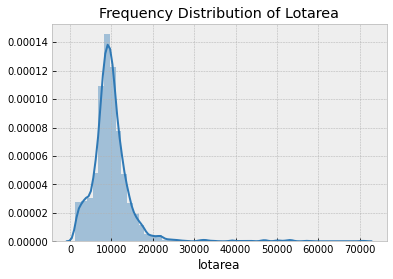

In [75]:
sns.distplot(train_dummy['lotarea'])
plt.title("Frequency Distribution of Lotarea");

In [76]:
def check_interactions(col,df,figsize):
    poly= PolynomialFeatures(include_bias=False)
    X_poly = poly.fit_transform(df)
    X_poly_df = pd.DataFrame(X_poly,columns=poly.get_feature_names(df.columns))
    filtered = X_poly_df.filter(like=col)
    filtered['saleprice'] = train['saleprice']
    corr_df = filtered.corr()[['saleprice']].sort_values(by='saleprice',ascending=False)
    corr_filtered = corr_df[np.abs(corr_df['saleprice'])>0.5]
    subplot_regplot(filtered, corr_filtered.index,f'Scatterplots - Interaction Terms of {col}'
                    ,corr_filtered.index,figsize,yvariable='saleprice');
    return corr_filtered, corr_filtered.index,X_poly_df

Index(['saleprice', 'lotarea overallqual', 'lotarea foundation_PConc',
       'lotarea garagearea', 'lotarea fireplacequ', 'lotarea grlivarea',
       'lotarea masvnrarea', 'lotarea heatingqc'],
      dtype='object')


saleprice
saleprice                  1.000000
lotarea overallqual        0.644322
lotarea foundation_PConc   0.625726
lotarea garagearea         0.577969
lotarea fireplacequ        0.575317
lotarea grlivarea          0.570237
lotarea masvnrarea         0.539603
lotarea heatingqc          0.512150

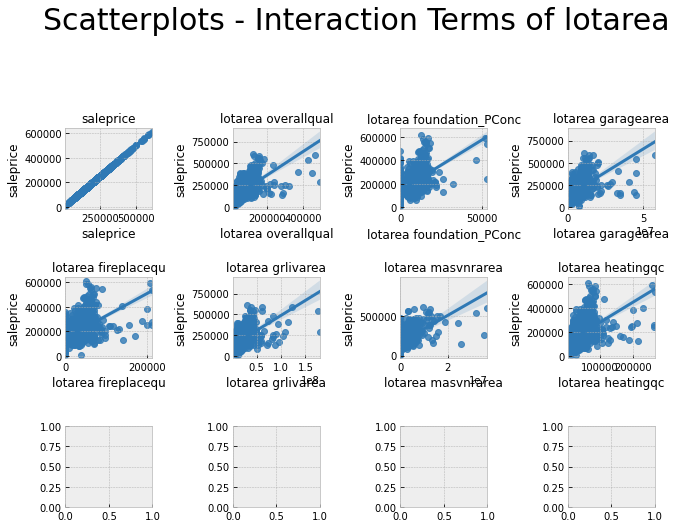

In [77]:
table_LA, cols_LA,df_LA = check_interactions('lotarea',X_large_p,(10,8))
print(cols_LA)
table_LA

- Histogram of lotarea shows a skew to the right, as expected. 
- Histogram shows that lotarea generally follows a normal distribution. 
- I will retain "lotarea overallqual" and "lotarea foundation_PConc" as potential regressors as they have rather high correlation with saleprice (more than 0.6).

#### Analysis of overallcond:

-0.0976


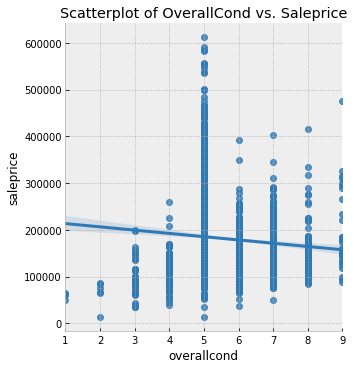

In [78]:
print(round((train['overallcond'].corr(train['saleprice'])),4))
sns.lmplot(y='saleprice',x='overallcond',data=train)
plt.title("Scatterplot of OverallCond vs. Saleprice");

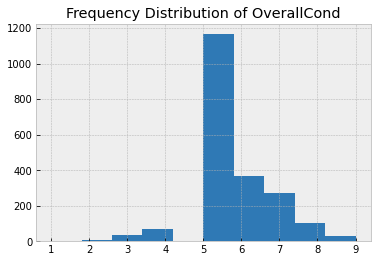

In [79]:
plt.hist(train['overallcond'])
plt.title("Frequency Distribution of OverallCond");

- Histograms indicate that majority of houses has at least a rating of 5 and above.
- Since there is a negative correlation with saleprice, this shows that houses with overallcond = 5 has a huge range of saleprice values, which hints to us that this might be interacting with another variable. 

Index(['saleprice', 'overallcond garagearea', 'overallcond grlivarea',
       'overallqual overallcond', 'overallcond yearsafterremod'],
      dtype='object')


saleprice
saleprice                     1.000000
overallcond garagearea        0.572781
overallcond grlivarea         0.572391
overallqual overallcond       0.566318
overallcond yearsafterremod  -0.506987

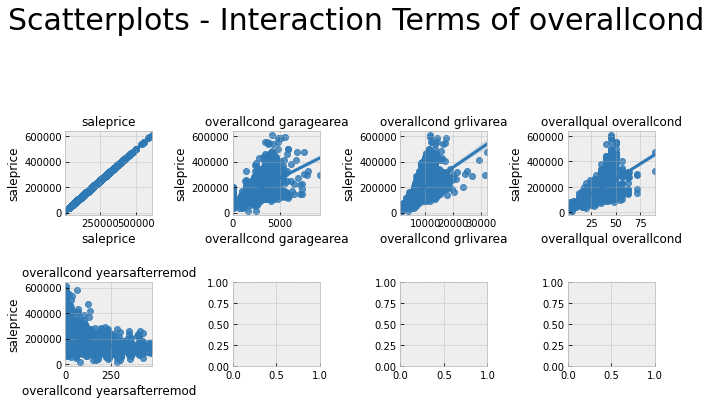

In [80]:
table_OC, cols_OC,df_OC = check_interactions('overallcond',X_large_p,(10,6))
print(cols_OC)
table_OC

- Scatterplots of 'overallcond yearsafterremod' indicates that there might be a non-linear relationship to the interaction term. 
- Similarly, 'overallqual overallcond' might have a non-linear relationship too. 
- Overall, none of the interaction terms indicate strong linear relationship nor positive correlation to saleprice. 

#### Analysis of masvnrarea:

Index(['saleprice', 'masvnrarea foundation_PConc', 'masvnrarea garagearea',
       'masvnrarea fireplacequ', 'masvnrarea grlivarea',
       'overallqual masvnrarea', 'masvnrarea bsmtexposure',
       'masvnrarea heatingqc', 'lotarea masvnrarea', 'masvnrarea bsmtfinsf1',
       'masvnrarea bsmtcond', 'masvnrarea', 'masvnrarea functional_Typ',
       'masvnrarea bedroomabvgr'],
      dtype='object')


saleprice
saleprice                     1.000000
masvnrarea foundation_PConc   0.630775
masvnrarea garagearea         0.614689
masvnrarea fireplacequ        0.599424
masvnrarea grlivarea          0.596109
overallqual masvnrarea        0.592869
masvnrarea bsmtexposure       0.571388
masvnrarea heatingqc          0.567284
lotarea masvnrarea            0.539603
masvnrarea bsmtfinsf1         0.526387
masvnrarea bsmtcond           0.518481
masvnrarea                    0.512471
masvnrarea functional_Typ     0.508994
masvnrarea bedroomabvgr       0.505877

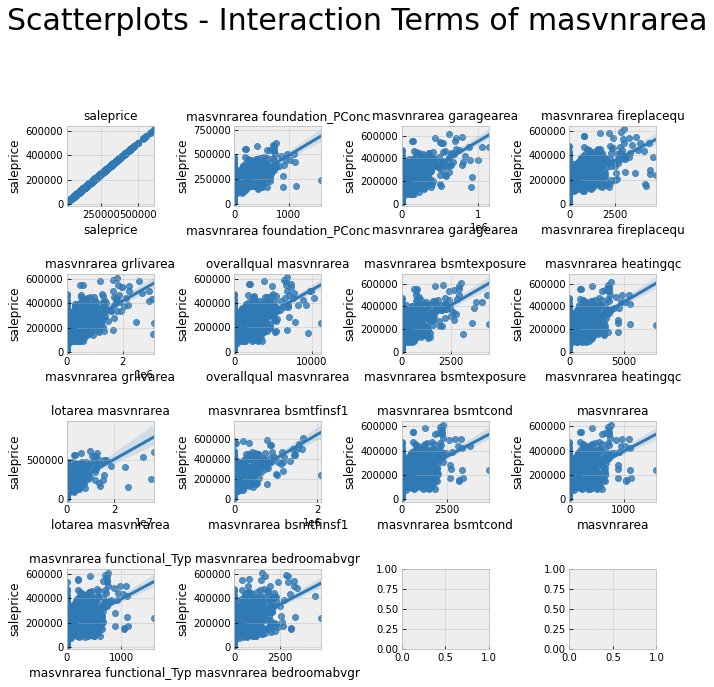

In [81]:
table_MVA, cols_MVA,df_MVA = check_interactions('masvnrarea',X_large_p,(10,10))
print(cols_MVA)
table_MVA

- I will retain "masvnrarea/garagearea" and "masvnrarea foundation_PConc" as potential regressors as they have rather high correlation with saleprice (more than 0.6).

#### Analysis of houseage:

Index(['saleprice', 'bsmtcond houseage', 'houseage yearsafterremod',
       'kitchenabvgr houseage', 'houseage'],
      dtype='object')


saleprice
saleprice                  1.000000
bsmtcond houseage         -0.502306
houseage yearsafterremod  -0.521939
kitchenabvgr houseage     -0.539043
houseage                  -0.572978

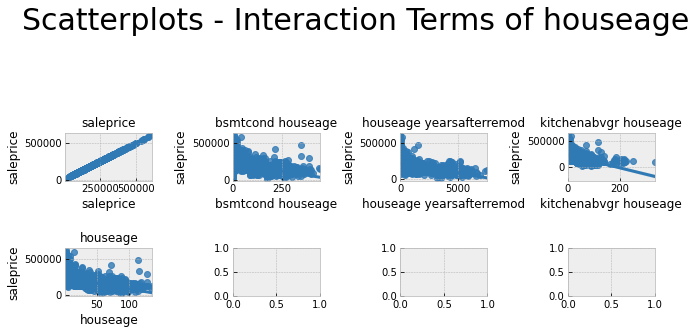

In [82]:
table_HA, cols_HA,df_HA = check_interactions('houseage',X_large_p,(10,5))
print(cols_HA)
table_HA

In [83]:
df_HA['saleprice']=train['saleprice']
df_HA['houseage^2'].corr(df_HA['saleprice'])

-0.4509940950569215

- Results have shown that, contrary to our expectation, houseage^2 does not have strong correlation with saleprice. 

# 5 Interaction and Polynomial Variables

From the previous section, there were a few interaction terms that I would like to explore.
- lotarea overallqual"
- "lotarea foundation_PConc"
- "masvnrarea/garagearea"
- "masvnrarea foundation_PConc"
- 'overallcond yearsafterremod' ^2
- 'overallqual overallcond'^2

### Interaction/Polynomial Variables from previous section
**Interaction terms for lotarea and masvnrarea**

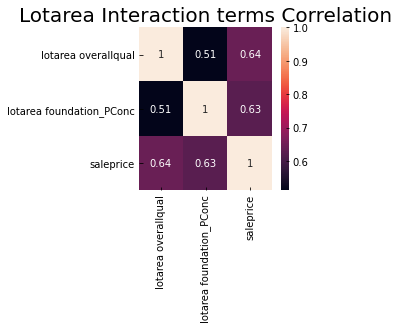

In [84]:
cols_LA_interaction = ['lotarea overallqual','lotarea foundation_PConc']
LA_interaction_df = df_LA[cols_LA_interaction]
LA_interaction_df['saleprice'] = train['saleprice']
plt.figure(figsize=(3,3))
sns.heatmap(LA_interaction_df.corr(),annot=True,annot_kws={"size":10})
plt.title("Lotarea Interaction terms Correlation",fontsize=20);

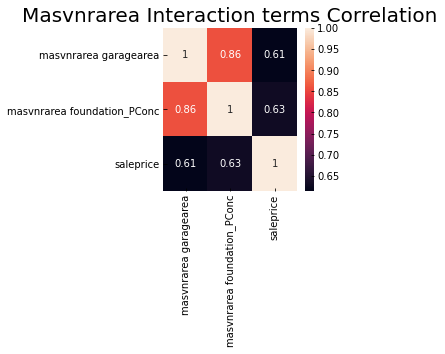

In [85]:
cols_MVA_interaction = ['masvnrarea garagearea','masvnrarea foundation_PConc']
MVA_interaction_df = df_MVA[cols_MVA_interaction]
MVA_interaction_df['saleprice'] = train['saleprice']
plt.figure(figsize=(3,3))
sns.heatmap(MVA_interaction_df.corr(),annot=True,annot_kws={"size":10})
plt.title("Masvnrarea Interaction terms Correlation",fontsize=20);

- Both interaction terms for lotarea have more than 0.6 correlation to saleprice. I will include these two interaction terms in our next model. Multi-collinearity is not evident.
- Similarly, the two interaction terms for masvnrarea are positively correlated to saleprice. However, since the two interaction terms have strong multi-collinearity (0.86), I will choose 'masvnrarea foundation_PConc' as my regressor due to its relatively higher correlation with saleprice.

**Overallcond-squared interaction terms**

In [86]:
cols_poly = ['overallcond yearsafterremod','overallqual overallcond']
X_transform_poly = df_OC[cols_poly]
X_transform_poly.head()

overallcond yearsafterremod  overallqual overallcond
0                    42.000000                     48.0
1                    61.666667                     35.0
2                    21.583333                     35.0
3                    16.666667                     25.0
4                   138.000000                     48.0

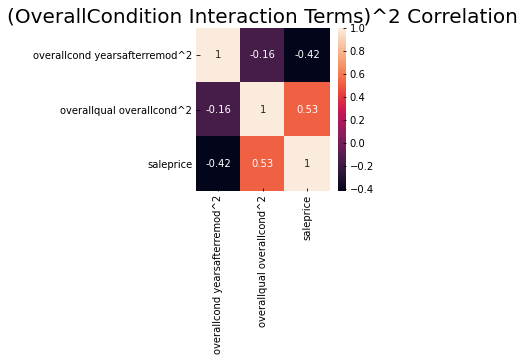

In [87]:
poly=PolynomialFeatures(include_bias = False)
X_poly_OC = poly.fit_transform(X_transform_poly)
X_poly_OC_df = pd.DataFrame(X_poly_OC, columns=poly.get_feature_names(X_transform_poly.columns))
OC_squared = X_poly_OC_df.filter(like='^2')
OC_squared['saleprice']=train['saleprice']
plt.figure(figsize=(3,3))
sns.heatmap(OC_squared.corr(),annot=True,annot_kws={"size":10})
plt.title("(OverallCondition Interaction Terms)^2 Correlation",fontsize=20);

- Unfortunately, our squared-interaction terms are not strongly correlated to saleprice. Hence, we will leave it out of our regression.

### Further Polynomial/Interaction Variables Analysis

In [88]:
train_dummy.shape

(2047, 138)

**Steps Taken**
- I will be creating polynomial/interaction terms for ALL variables included in our original train_dummy dataframe, before we excluded any regressors for our models.
- Thereafter, I will check the correlation against saleprice and filter for the highest correlated terms. 

##### Step 1: Creation of all interaction/polynomial terms

In [89]:
train_dummy_poly = train_dummy.drop(columns=['id','saleprice'])

In [90]:
poly = PolynomialFeatures(include_bias=False)
all_poly = poly.fit_transform(train_dummy_poly)

In [91]:
len(all_poly)

2047

In [92]:
all_poly_df = pd.DataFrame(all_poly,columns=poly.get_feature_names(train_dummy_poly.columns))
all_poly_df.shape

(2047, 9452)

In [93]:
all_poly_df['saleprice'] = train['saleprice']

##### Step 2: Filtering for Polynomial/Interaction terms that are highly correlated to saleprice

In [94]:
all_poly_corr = all_poly_df.corr()[['saleprice']]
all_poly_corr_filtered = all_poly_corr[all_poly_corr['saleprice']>0.8].index.tolist()
# all_poly_corr_filtered is a list of all the variables with correlation more than 0.8

In [95]:
all_poly_corr[all_poly_corr['saleprice']>0.8].sort_values(by='saleprice',ascending=False)

saleprice
saleprice                1.000000
overallqual grlivarea    0.873058
overallqual 1stflrsf     0.840803
overallqual^2            0.831113
overallqual garagearea   0.825775
grlivarea garagearea     0.808444
overallqual              0.803859

### Model 8A: Including the four interaction terms on top of Model 7A

In [96]:
cols_8a = ['lotarea overallqual','lotarea foundation_PConc','masvnrarea foundation_PConc']
X_model8a = X_model7a
X_model8a[cols_8a] = all_poly_df[cols_8a]
y = train_dummy[['saleprice']]
X_model8a.head()

lotarea  condition1  overallqual  overallcond  masvnrarea  bsmtcond  \
0    13517           0            6            8       289.0         3   
1    11492           0            7            5       132.0         3   
2     7922           0            5            7         0.0         3   
3     9802           0            5            5         0.0         3   
4    14235           0            6            8         0.0         4   

   bsmtexposure  bsmtfinsf1  bsmtfinsf2  bsmtunfsf  ...  masvnrtype_Stone  \
0             1       533.0         0.0      192.0  ...                 0   
1             1       637.0         0.0      276.0  ...                 0   
2             1       731.0         0.0      326.0  ...                 0   
3             1         0.0         0.0      384.0  ...                 0   
4             1         0.0         0.0      676.0  ...                 0   

   foundation_PConc  foundation_Slab  functional_Min2  functional_Sev  \
0                 0                0                0               0   
1                 1                0                0               0   
2                 0                0                0               0   
3                 1                0                0               0   
4                 1                0                0               0   

   functional_Typ  garagetype_NA  lotarea overallqual  \
0               1              0              81102.0   
1               1              0              80444.0   
2               1              0              39610.0   
3               1              0              49010.0   
4               1              0              85410.0   

   lotarea foundation_PConc  masvnrarea foundation_PConc  
0                       0.0                          0.0  
1                   11492.0                        132.0  
2                       0.0                          0.0  
3                    9802.0                          0.0  
4                   14235.0                          0.0  

[5 rows x 50 columns]

In [97]:
print(X_model8a.shape)
print(y.shape)

(2047, 50)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 50)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


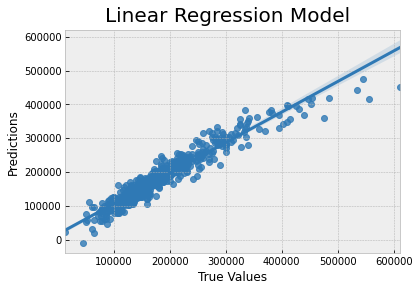

Training R2 (Basic LR) : 0.9227
Testing R2 (Basic LR) : 0.9191
Cross Val Score (Basic LR) : 0.9106
Adjusted R2 (Basic LR) :    0.9119

RMSE (Basic LR) : 23389.7234
Difference in R2 (Overfitting) : 0.36%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 12.46
Training R2 (RR) : 0.9226
Testing R2 (RR) : 0.9187
Estimate of testing R2 (RR) is: 0.911
RMSE (RR) : 23347.0194
Adjusted R2 (RR) :    0.91147


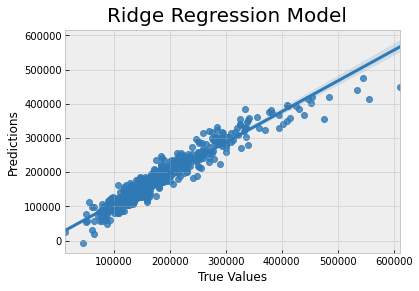

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 10.0
Training R2 (Lasso) : 0.9227
Testing R2 (Lasso) : 0.9191
Estimate of testing R2 (Lasso) is: 0.910621
RMSE (Lasso) : 23393.7442
Adjusted R2 (Lasso) :    0.91192


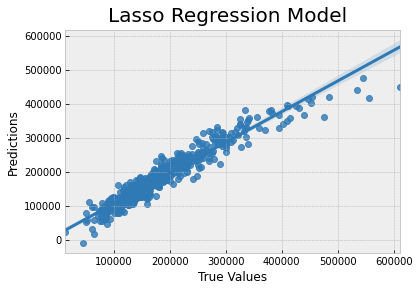

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.9092
Testing R2 (ENET) : 0.9037
Estimate of testing R2 (ENET) is: 0.899936
RMSE (ENET) : 24756.9082
Adjusted R2 (ENET) :    0.89521


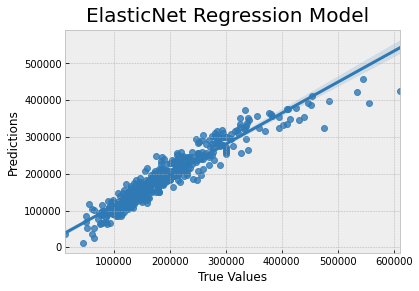

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 300*****************************************


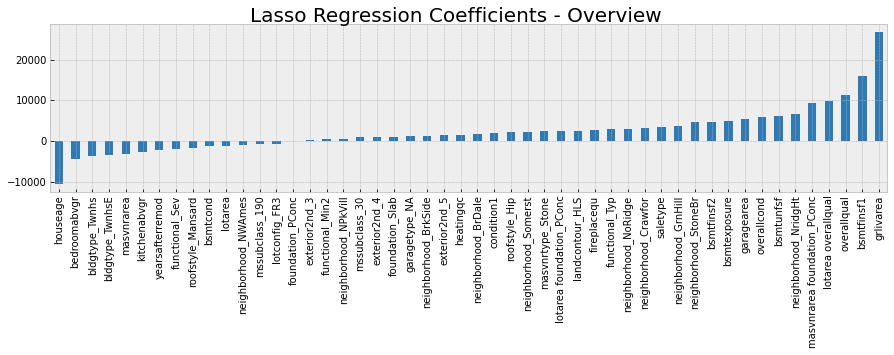

Index(['foundation_PConc'], dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear          0.9119  0.9106  23389.7234
Ridge           0.9114  0.9110  23347.0194
Lasso           0.9119  0.9106  23393.7442
ElasticNet      0.8952  0.8999  24756.9082

In [98]:
final_overview(X_model8a,y,"Model 8A",1,5,300)

**Model Evaluation**
- Model 8A has an improvement of R2 and RMSE score than Model 7A. 
- This shows that the four interaction terms we added are useful for explaining the variance.
- Note that ['lotarea', 'bsmtcond', 'grlivarea', 'mssubclass_30', 'foundation_PConc','overallqual^2'] has been eliminated by the lasso regression at alpha = 300. 

### Model 8B: Including the List of Filtered Interaction Terms on top of Model 8A

In [99]:
# Since correlation > 0.7 yielded >15 regressors, I have increased the correlation threshold to 0.8. 
# These are the interaction terms that we can include in our regression. 
all_poly_corr_filtered

['overallqual',
 'overallqual^2',
 'overallqual 1stflrsf',
 'overallqual grlivarea',
 'overallqual garagearea',
 'grlivarea garagearea',
 'saleprice']

In [100]:
cols_8b = ['overallqual^2', 'overallqual 1stflrsf', 'overallqual grlivarea', 
            'overallqual garagearea', 'grlivarea garagearea']
X_model8b = X_model8a
X_model8b[cols_8b] = all_poly_df[cols_8b]
y = train_dummy[['saleprice']]
X_model8b.head()

lotarea  condition1  overallqual  overallcond  masvnrarea  bsmtcond  \
0    13517           0            6            8       289.0         3   
1    11492           0            7            5       132.0         3   
2     7922           0            5            7         0.0         3   
3     9802           0            5            5         0.0         3   
4    14235           0            6            8         0.0         4   

   bsmtexposure  bsmtfinsf1  bsmtfinsf2  bsmtunfsf  ...  functional_Typ  \
0             1       533.0         0.0      192.0  ...               1   
1             1       637.0         0.0      276.0  ...               1   
2             1       731.0         0.0      326.0  ...               1   
3             1         0.0         0.0      384.0  ...               1   
4             1         0.0         0.0      676.0  ...               1   

   garagetype_NA  lotarea overallqual  lotarea foundation_PConc  \
0              0              81102.0                       0.0   
1              0              80444.0                   11492.0   
2              0              39610.0                       0.0   
3              0              49010.0                    9802.0   
4              0              85410.0                   14235.0   

   masvnrarea foundation_PConc  overallqual^2  overallqual 1stflrsf  \
0                          0.0           36.0                4350.0   
1                        132.0           49.0                6391.0   
2                          0.0           25.0                5285.0   
3                          0.0           25.0                3720.0   
4                          0.0           36.0                4986.0   

   overallqual grlivarea  overallqual garagearea  grlivarea garagearea  
0                 8874.0                  2850.0              702525.0  
1                14854.0                  3913.0             1186198.0  
2                 5285.0                  1230.0              260022.0  
3                 7220.0                  2000.0              577600.0  
4                 8670.0                  2904.0              699380.0  

[5 rows x 55 columns]

In [101]:
print(X_model8b.shape)
print(y.shape)

(2047, 55)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 55)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


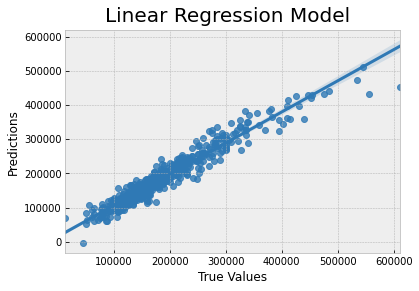

Training R2 (Basic LR) : 0.9343
Testing R2 (Basic LR) : 0.9335
Cross Val Score (Basic LR) : 0.9207
Adjusted R2 (Basic LR) :    0.9269

RMSE (Basic LR) : 22018.5163
Difference in R2 (Overfitting) : 0.08%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 5.55
Training R2 (RR) : 0.934
Testing R2 (RR) : 0.9329
Estimate of testing R2 (RR) is: 0.9212
RMSE (RR) : 21954.8384
Adjusted R2 (RR) :    0.92634


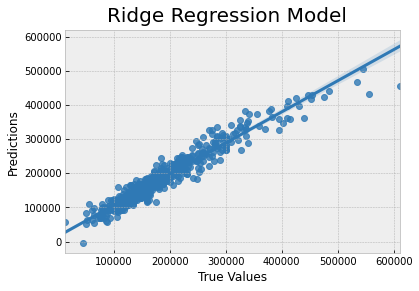

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 20.53199941072399
Training R2 (Lasso) : 0.9342
Testing R2 (Lasso) : 0.9336
Estimate of testing R2 (Lasso) is: 0.920814
RMSE (Lasso) : 22010.3537
Adjusted R2 (Lasso) :    0.92702


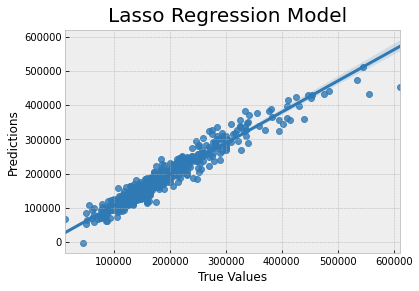

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.9223
Testing R2 (ENET) : 0.9209
Estimate of testing R2 (ENET) is: 0.913094
RMSE (ENET) : 23068.6452
Adjusted R2 (ENET) :    0.91309


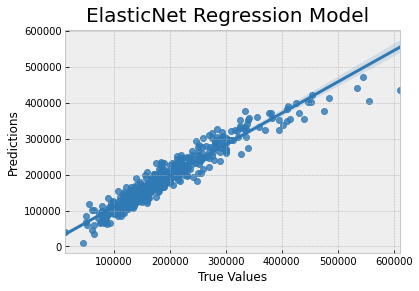

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 350*****************************************


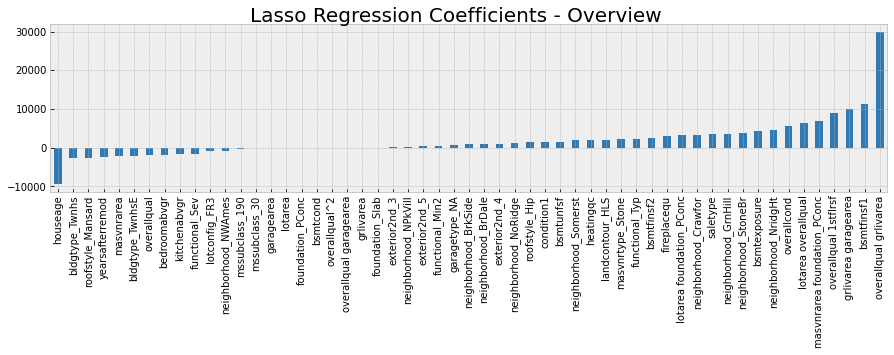

Index(['lotarea', 'bsmtcond', 'grlivarea', 'garagearea', 'mssubclass_30',
       'foundation_PConc', 'overallqual^2', 'overallqual garagearea'],
      dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear          0.9269  0.9207  22018.5163
Ridge           0.9263  0.9212  21954.8384
Lasso           0.9270  0.9208  22010.3537
ElasticNet      0.9130  0.9131  23068.6452

In [102]:
final_overview(X_model8b,y,"Model 8B",1,5,350)

**Model Evaluation**
- Model 8B has performed the best thus far, yielding an R^2 of 0.92 and RSME of 21.9K. 
- ['lotarea', 'bsmtcond', 'grlivarea', 'garagearea', 'mssubclass_30','foundation_PConc', 'overallqual^2', 'overallqual garagearea'] have been eliminated from our lasso regression.

### Model 9: Further fine-tuning of Model 8B using statistical evaluation

In [103]:
X_OLS = X_model8b
X_OLS = sm.add_constant(X_model8b,prepend=False)
y_OLS = train_dummy['saleprice']

In [104]:
modelOLS = sm.OLS(y_OLS,X_OLS).fit()
modelOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     522.7
Date:                Fri, 28 Aug 2020   Prob (F-statistic):               0.00
Time:                        00:01:22   Log-Likelihood:                -23194.
No. Observations:                2047   AIC:                         4.650e+04
Df Residuals:                    1991   BIC:                         4.681e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
lotarea                        -0.3024      0.439     -0.689      0.491      -1.163       0.558
condition1                   9595.7115   3445.777      2.785      0.005    2838.005    1.64e+04
overallqual                  -2.16e+04   2784.809     -7.757      0.000   -2.71e+04   -1.61e+04
overallcond                  6227.8301    562.091     11.080      0.000    5125.481    7330.179
masvnrarea                    -15.9316      5.328     -2.990      0.003     -26.381      -5.483
bsmtcond                     -872.4678   1236.799     -0.705      0.481   -3298.024    1553.088
bsmtexposure                 3713.8613    528.310      7.030      0.000    2677.764    4749.959
bsmtfinsf1                     34.0221      2.580     13.186      0.000      28.962      39.082
bsmtfinsf2                     25.8628      3.714      6.963      0.000      18.579      33.147
bsmtunfsf                      11.9681      2.508      4.773      0.000       7.050      16.886
heatingqc                    2438.1606    626.100      3.894      0.000    1210.280    3666.041
grlivarea                       1.7938      6.559      0.273      0.785     -11.070      14.658
bedroomabvgr                -2033.2541    814.661     -2.496      0.013   -3630.932    -435.576
kitchenabvgr                -9605.6956   2624.038     -3.661      0.000   -1.48e+04   -4459.548
fireplacequ                  1891.8648    324.421      5.832      0.000    1255.624    2528.106
garagearea                    -57.8852     13.386     -4.324      0.000     -84.138     -31.633
saletype                     1.466e+04   1980.567      7.404      0.000    1.08e+04    1.85e+04
houseage                     -362.3206     31.518    -11.495      0.000    -424.133    -300.508
yearsafterremod              -138.4184     35.776     -3.869      0.000    -208.581     -68.255
mssubclass_190              -5019.0032   3328.459     -1.508      0.132   -1.15e+04    1508.624
mssubclass_30               -3186.6916   2514.323     -1.267      0.205   -8117.671    1744.288
landcontour_HLS              6984.3609   2600.700      2.686      0.007    1883.981    1.21e+04
lotconfig_FR3               -2.238e+04   6975.664     -3.209      0.001   -3.61e+04   -8703.743
neighborhood_BrDale          2.155e+04   5893.914      3.657      0.000    9994.368    3.31e+04
neighborhood_BrkSide         6318.6912   2540.634      2.487      0.013    1336.112    1.13e+04
neighborhood_Crawfor          1.84e+04   2765.240      6.655      0.000     1.3e+04    2.38e+04
neighborhood_GrnHill         1.109e+05   1.48e+04      7.493      0.000    8.19e+04     1.4e+05
neighborhood_NPkVill         1.176e+04   6055.847      1.941      0.052    -120.792    2.36e+04
neighborhood_NWAmes         -3063.1391   2488.211     -1.231      0.218   -7942.910    1816.632
neighborhoo

In [105]:
standard_errors = modelOLS.bse
p_values = modelOLS.pvalues

In [106]:
modelOLS_df['standard_errors'] = pd.Series(standard_errors)
modelOLS_df['p_values'] = pd.Series(p_values)

In [107]:
large_se = modelOLS_df[modelOLS_df['standard_errors']>(standard_errors.mean())].index
large_p = modelOLS_df[modelOLS_df['p_values']>0.05].index

In [108]:
print(len(large_se))
print(len(large_p))

22
13


In [109]:
# I will not look into small coefficients as that is not a preferred way to look for insignificant regressors. 
# I will look into variables where p-values are higher than 5%. 
# I will also look for variables where standard errors are more than 1,000. This is an arbitrary number. 
large_se_p = list(set(large_se) & set(large_p))
large_se = list(large_se)
large_p = list(large_p)
large_se_or_p = list(set(large_se) | set(large_p))

print(len(large_se_p))
print(len(large_se))
print(len(large_p))
print(len(large_se_or_p))

large_se.remove('const')

7
22
13
28


In [110]:
X_large_se_p = X_model8b.drop(columns=large_se_p)
X_large_se = X_model8b.drop(columns=large_se)
X_large_p = X_model8b.drop(columns=large_p)

print(X_large_se_p.shape)
print(X_large_se.shape)
print(X_large_p.shape)

(2047, 48)
(2047, 34)
(2047, 42)


#### Model 9A: Tuning Model 8B - Removal of Statistically Insignificant Variables (high p-values)

In [111]:
X_model9a = all_poly_df[X_large_p.columns]
y = all_poly_df[['saleprice']]

In [112]:
print(X_model9a.shape)
print(y.shape)

(2047, 42)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 42)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


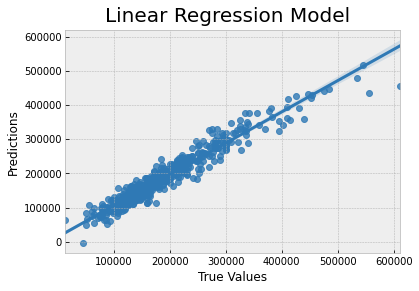

Training R2 (Basic LR) : 0.9334
Testing R2 (Basic LR) : 0.9329
Cross Val Score (Basic LR) : 0.9224
Adjusted R2 (Basic LR) :    0.9279

RMSE (Basic LR) : 21787.7642
Difference in R2 (Overfitting) : 0.05%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 3.59
Training R2 (RR) : 0.9333
Testing R2 (RR) : 0.9326
Estimate of testing R2 (RR) is: 0.9226
RMSE (RR) : 21762.3238
Adjusted R2 (RR) :    0.92766


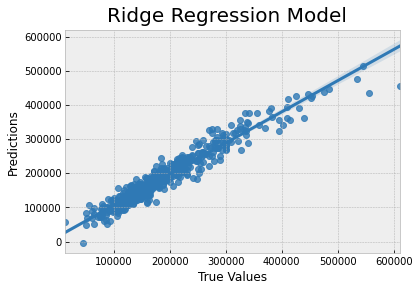

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 10.0
Training R2 (Lasso) : 0.9334
Testing R2 (Lasso) : 0.9329
Estimate of testing R2 (Lasso) is: 0.922411
RMSE (Lasso) : 21791.4933
Adjusted R2 (Lasso) :    0.92798


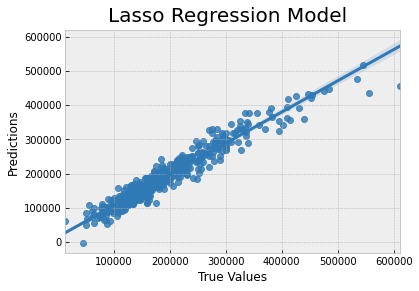

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.9178
Testing R2 (ENET) : 0.9171
Estimate of testing R2 (ENET) is: 0.909371
RMSE (ENET) : 23563.9809
Adjusted R2 (ENET) :    0.91096


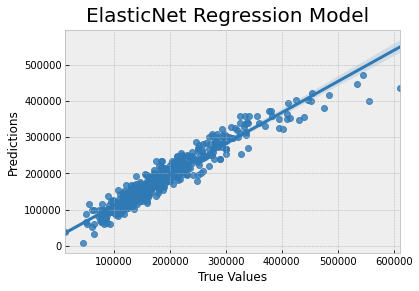

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 700*****************************************


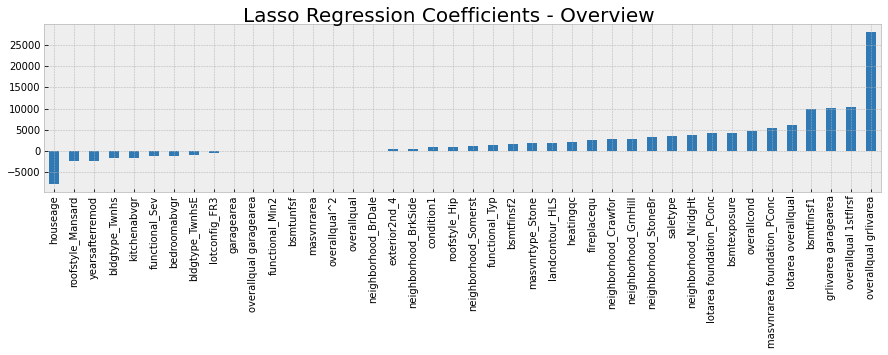

Index(['overallqual', 'masvnrarea', 'bsmtunfsf', 'garagearea',
       'neighborhood_BrDale', 'functional_Min2', 'overallqual^2',
       'overallqual garagearea'],
      dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear          0.9279  0.9224  21787.7642
Ridge           0.9276  0.9226  21762.3238
Lasso           0.9279  0.9224  21791.4933
ElasticNet      0.9109  0.9094  23563.9809

In [113]:
final_overview(X_model9a,y,"Model 9A",1,5,700)

#### Model 9B: Tuning Model 8B - Removal of Variables with High Standard Errors

In [114]:
X_model9b = all_poly_df[X_large_se.columns]
y = all_poly_df[['saleprice']]

In [115]:
print(X_model9b.shape)
print(y.shape)

(2047, 34)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 34)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


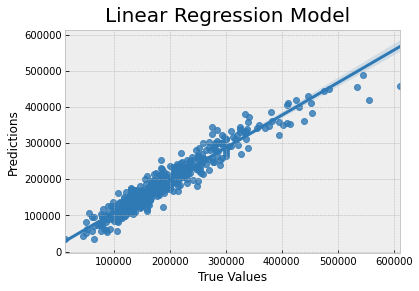

Training R2 (Basic LR) : 0.9186
Testing R2 (Basic LR) : 0.9262
Cross Val Score (Basic LR) : 0.9097
Adjusted R2 (Basic LR) :    0.9219

RMSE (Basic LR) : 23505.1009
Difference in R2 (Overfitting) : -0.76%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 3.23
Training R2 (RR) : 0.9185
Testing R2 (RR) : 0.9255
Estimate of testing R2 (RR) is: 0.91
RMSE (RR) : 23474.6179
Adjusted R2 (RR) :    0.92111


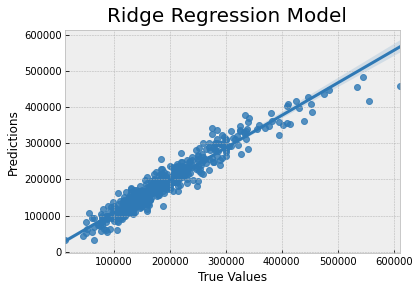

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 63.515582892056884
Training R2 (Lasso) : 0.9183
Testing R2 (Lasso) : 0.9251
Estimate of testing R2 (Lasso) is: 0.910018
RMSE (Lasso) : 23468.6784
Adjusted R2 (Lasso) :    0.9207



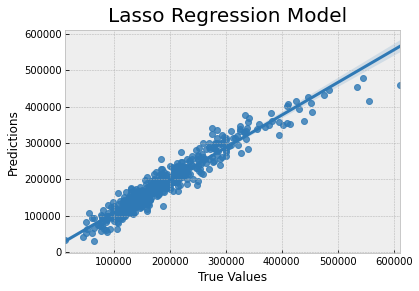

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.9094
Testing R2 (ENET) : 0.9153
Estimate of testing R2 (ENET) is: 0.903989
RMSE (ENET) : 24250.7495
Adjusted R2 (ENET) :    0.91037


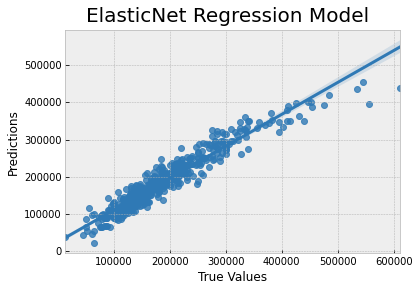

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 300*****************************************


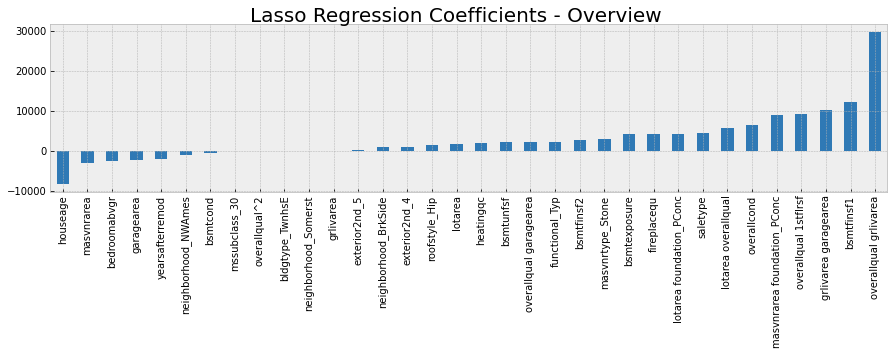

Index(['grlivarea', 'mssubclass_30', 'neighborhood_Somerst', 'bldgtype_TwnhsE',
       'overallqual^2'],
      dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear          0.9219  0.9097  23505.1009
Ridge           0.9211  0.9100  23474.6179
Lasso           0.9207  0.9100  23468.6784
ElasticNet      0.9103  0.9040  24250.7495

In [116]:
final_overview(X_model9b,y,"Model 9B",1,5,300)

#### Model 9C: Tuning Model 8B - Removal of Variables that are statistically insignificant or has high standard errors

In [117]:
X_model9c = all_poly_df[X_large_se_p.columns]
y = all_poly_df[['saleprice']]

In [118]:
print(X_model9c.shape)
print(y.shape)

(2047, 48)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 48)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


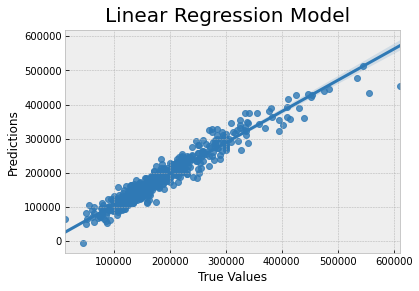

Training R2 (Basic LR) : 0.9336
Testing R2 (Basic LR) : 0.9328
Cross Val Score (Basic LR) : 0.9209
Adjusted R2 (Basic LR) :    0.9271

RMSE (Basic LR) : 22003.1707
Difference in R2 (Overfitting) : 0.08%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 5.12
Training R2 (RR) : 0.9334
Testing R2 (RR) : 0.9323
Estimate of testing R2 (RR) is: 0.9214
RMSE (RR) : 21940.6012
Adjusted R2 (RR) :    0.92657


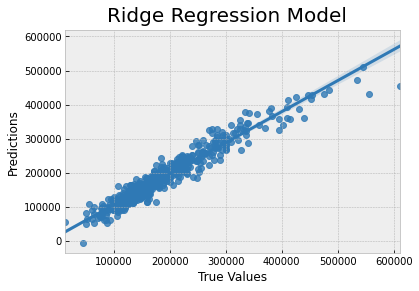

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 15.981603879793948
Training R2 (Lasso) : 0.9336
Testing R2 (Lasso) : 0.9329
Estimate of testing R2 (Lasso) is: 0.920935
RMSE (Lasso) : 21996.5605
Adjusted R2 (Lasso) :    0.92723


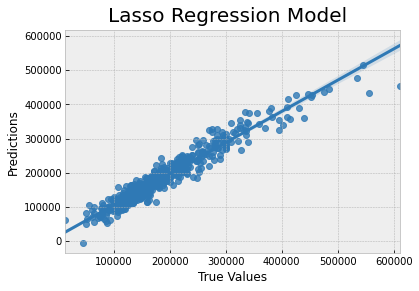

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.9211
Testing R2 (ENET) : 0.9205
Estimate of testing R2 (ENET) is: 0.912261
RMSE (ENET) : 23183.6134
Adjusted R2 (ENET) :    0.91375


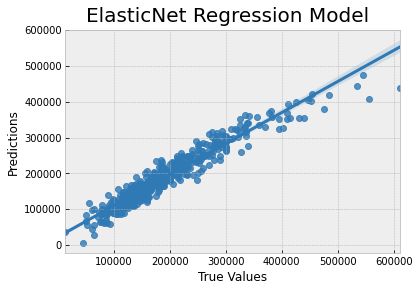

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 300*****************************************


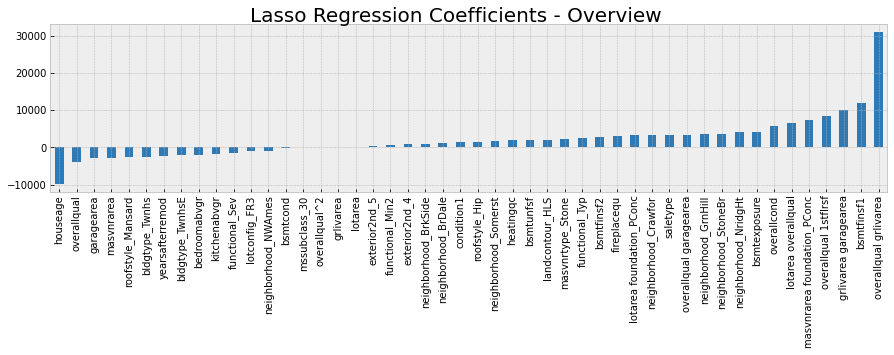

Index(['lotarea', 'grlivarea', 'mssubclass_30', 'overallqual^2'], dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear          0.9271  0.9209  22003.1707
Ridge           0.9265  0.9214  21940.6012
Lasso           0.9272  0.9209  21996.5605
ElasticNet      0.9137  0.9123  23183.6134

In [119]:
final_overview(X_model9c,y,"Model 9C",1,5,300)

**Model Evaluation**
- Model 9A brings the best result out of all models that we have tested so far.
    - Ridge Regression
    - R^2: 0.922634	
    - RMSE: 21,762
- There are 42 regressors altogether in this model.

# Model Evaluation

## Evaluation of Model 9A: Multiple Linear Regression (MLR) Assumptions

- **Linearity**: 
    - As seen from the scatterplots of all 10 regresors, we observe a distinct linear relationship between independent variable (saleprice) and its regressor. Condition is **fulfilled**.
- **Independence:** 
    - As seen from the heatmap of error terms against regressors, we see that there are nearly 0 correlation to the regressors. Condition is **fulfilled**.
- **Normality**: 
    - As we observe from the scatterplot of residuals against regressors(Xi), we see that all of the residual's means centres around 0. 
    - Condition is **fulfilled**.
- **Equality of Variances:** 
    - In the scatterplot of regressors (Xi) against residual, we observe that most have a uniform error term across all values of Xi, centred around 0. 
    - However, we see that at large values of x, residuals diverge for some of our Xi. This shows heteroskedasticity. Condition is **semi-fulfilled**.
    - This indicates that our model is really good at predicting houses with lower saleprice, and we will obtain high error when predicting houses with high saleprice.
- **Independence Part 2:** 
    - Based on the heatmap above, we can conclude that **none** of our regressors have significant correlation with each other. Condition is **fulfilled**.

### Assumption Evaluation with Ridge Model

In [120]:
X_9A = X_model9a
y = all_poly_df[['saleprice']]

In [121]:
ridge_findalpha=RidgeCV(alphas=np.linspace(1,15,1000), store_cv_values=True) 
ridge_findalpha.fit(X_9A,y)
ridge_alpha = round(ridge_findalpha.alpha_,2)
print(f'Best Alpha for Ridge Model: {ridge_alpha}')

Best Alpha for Ridge Model: 1.0


In [122]:
ridge_model = Ridge

In [123]:
all_poly_df_eval= all_poly_df.copy()

In [124]:
ridge = Ridge(alpha = ridge_alpha)
ridge_model = ridge.fit(X_9A,y)
ypredicted = ridge_model.predict(X_9A)

all_poly_df_eval['ypredicted'] = ypredicted
all_poly_df_eval['residuals'] = all_poly_df_eval['saleprice'] - all_poly_df_eval['ypredicted']

**Linearity Assumption**

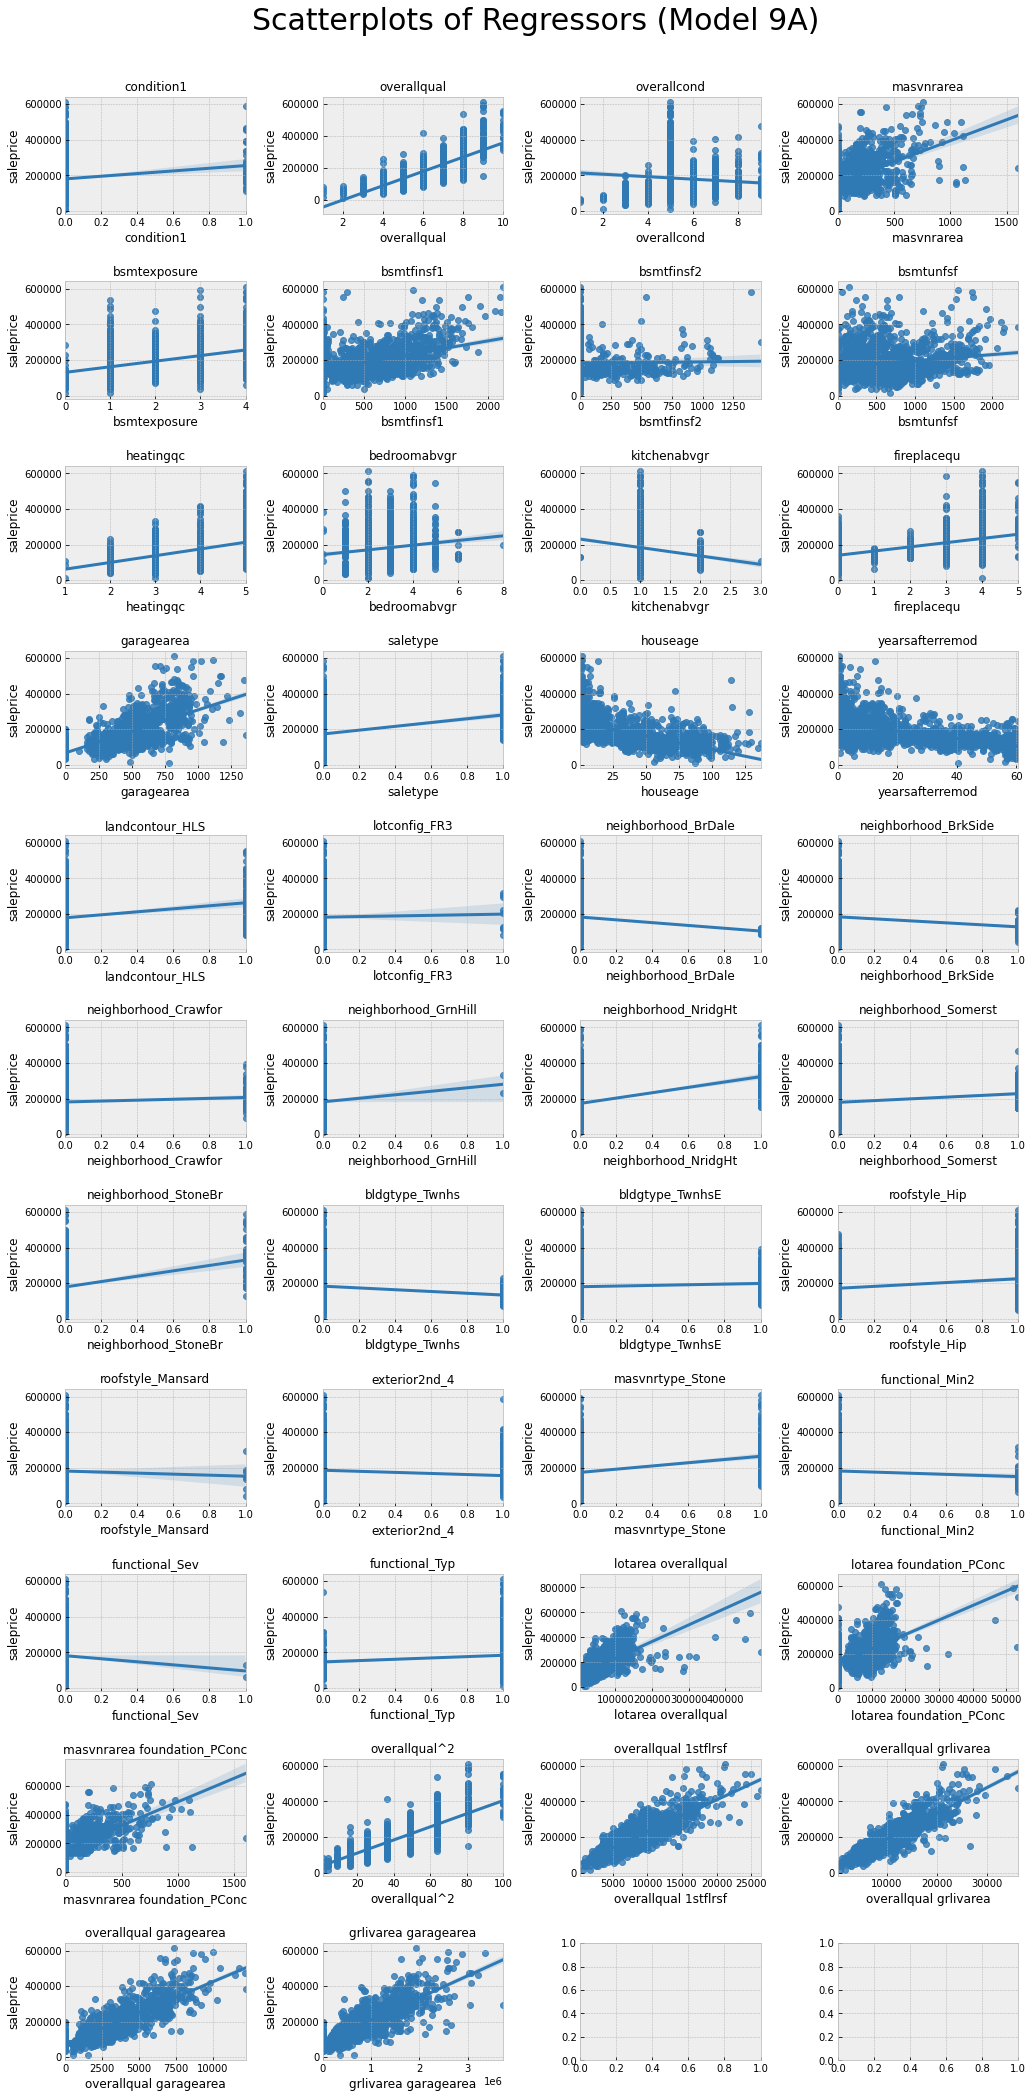

In [125]:
subplot_regplot(all_poly_df_eval, X_9A.columns,
                'Scatterplots of Regressors (Model 9A)',X_9A.columns,(15,30),
                yvariable='saleprice');

**Independence Assumption**

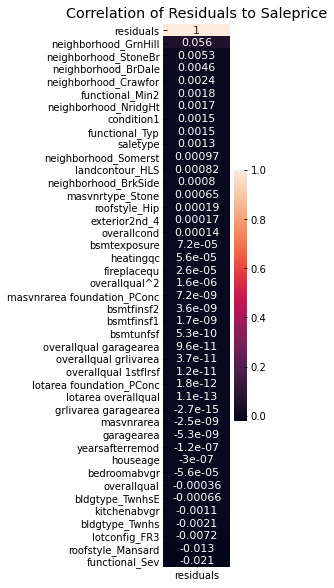

In [126]:
plt.figure(figsize=(1.5,10))
X_9a_corr = all_poly_df_eval[X_9A.columns]
X_9a_corr['residuals'] = all_poly_df_eval['residuals']
sns.heatmap(X_9a_corr.corr()[['residuals']].sort_values('residuals',ascending=False),annot=True,annot_kws={"size":11})
plt.title("Correlation of Residuals to Saleprice");

**Normality Assumption**

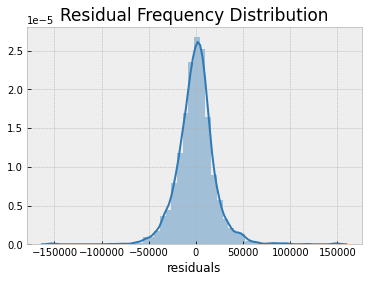

In [127]:
sns.distplot(all_poly_df_eval['residuals'])
plt.title("Residual Frequency Distribution",fontsize=17);

**Equality of Variances**

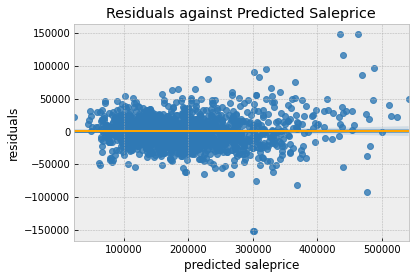

In [128]:
sns.regplot(ypredicted,all_poly_df_eval['residuals'])
plt.axhline(0,color='orange')
plt.xlabel("predicted saleprice")
plt.title("Residuals against Predicted Saleprice");

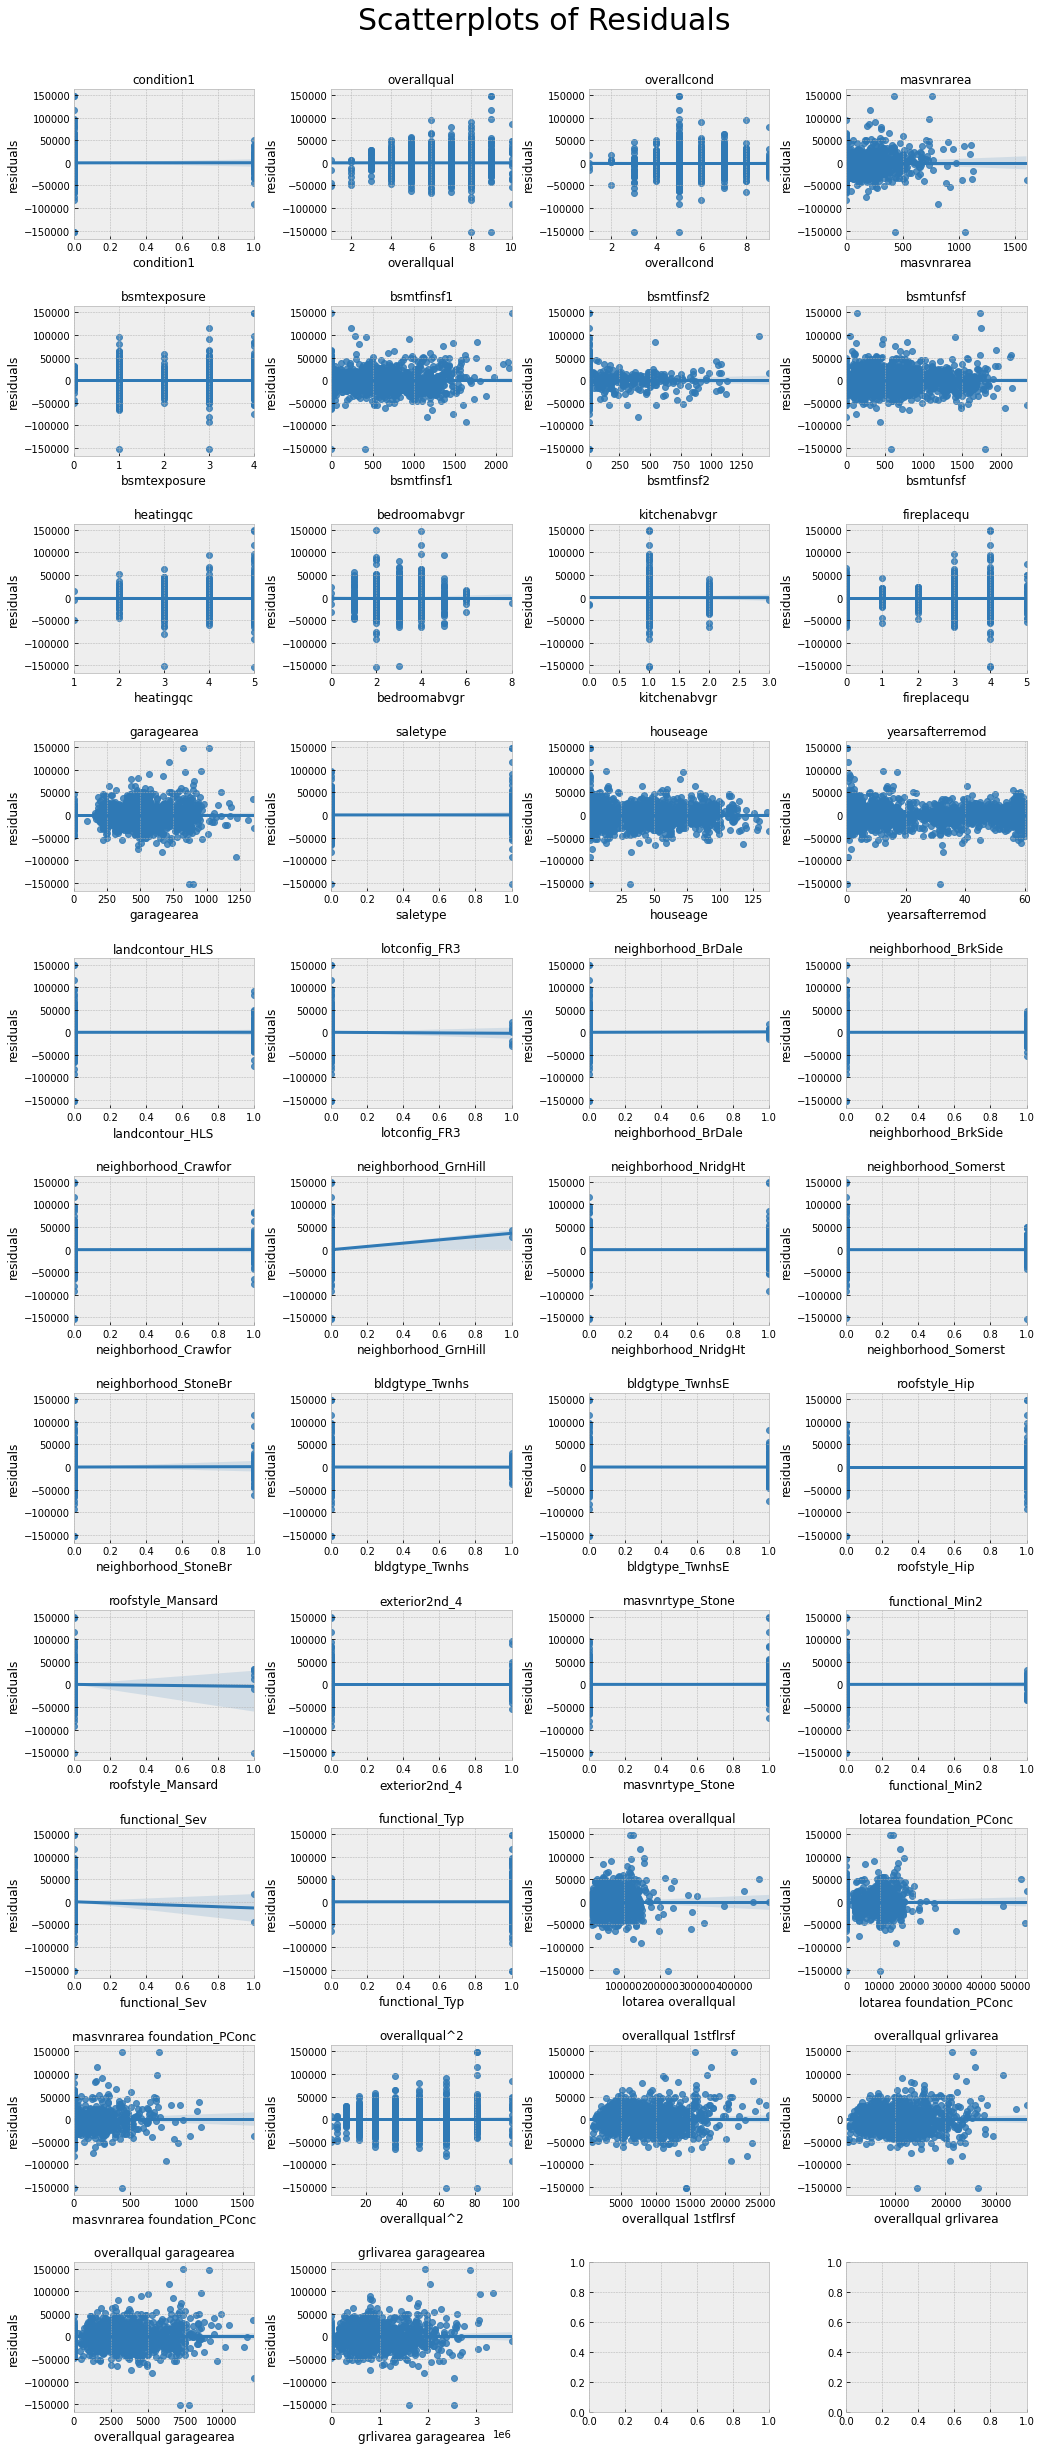

In [129]:
subplot_regplot(all_poly_df_eval, X_9A.columns,
                'Scatterplots of Residuals',
                X_9A.columns,(15,35),yvariable='residuals');

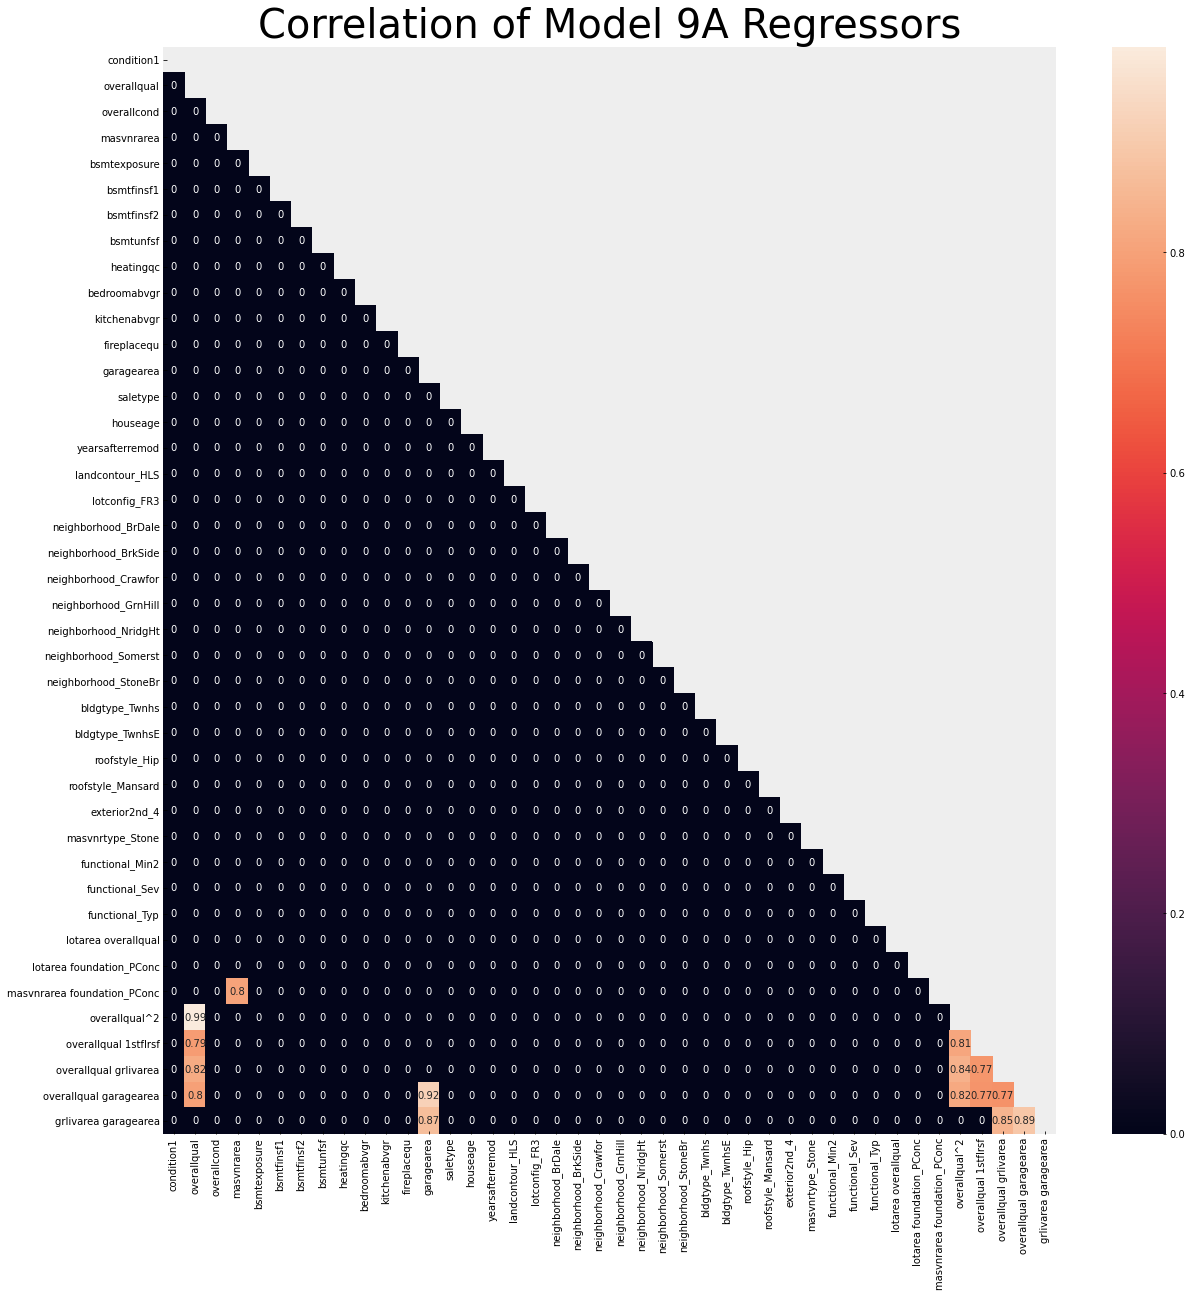

In [130]:
X_9a_corr_Xi= all_poly_df_eval[X_9A.columns].corr().abs()
X_9a_corr_Xi[((X_9a_corr_Xi)<0.7)]=0
custom_mask = np.zeros_like(X_9a_corr_Xi.corr())   
custom_mask[np.triu_indices_from(custom_mask)] = True  
plt.figure(figsize=(20,20))
sns.heatmap(X_9a_corr_Xi,mask=custom_mask,annot=True)
plt.title("Correlation of Model 9A Regressors",fontsize=40);

In [131]:
X_9a_corr_Xi= all_poly_df_eval[X_9A.columns].corr().abs()
X_9a_high_corr = (X_9a_corr_Xi.where(np.triu(np.ones(X_9a_corr_Xi.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
round(X_9a_high_corr[X_9a_high_corr>0.7],2)

overallqual             overallqual^2                  0.99
garagearea              overallqual garagearea         0.92
overallqual garagearea  grlivarea garagearea           0.89
garagearea              grlivarea garagearea           0.87
overallqual grlivarea   grlivarea garagearea           0.85
overallqual^2           overallqual grlivarea          0.84
overallqual             overallqual grlivarea          0.82
overallqual^2           overallqual garagearea         0.82
                        overallqual 1stflrsf           0.81
masvnrarea              masvnrarea foundation_PConc    0.80
overallqual             overallqual garagearea         0.80
                        overallqual 1stflrsf           0.79
overallqual 1stflrsf    overallqual grlivarea          0.77
                        overallqual garagearea         0.77
overallqual grlivarea   overallqual garagearea         0.77
dtype: float64

**Distribution of All Regressors** (Additional Evaluation)

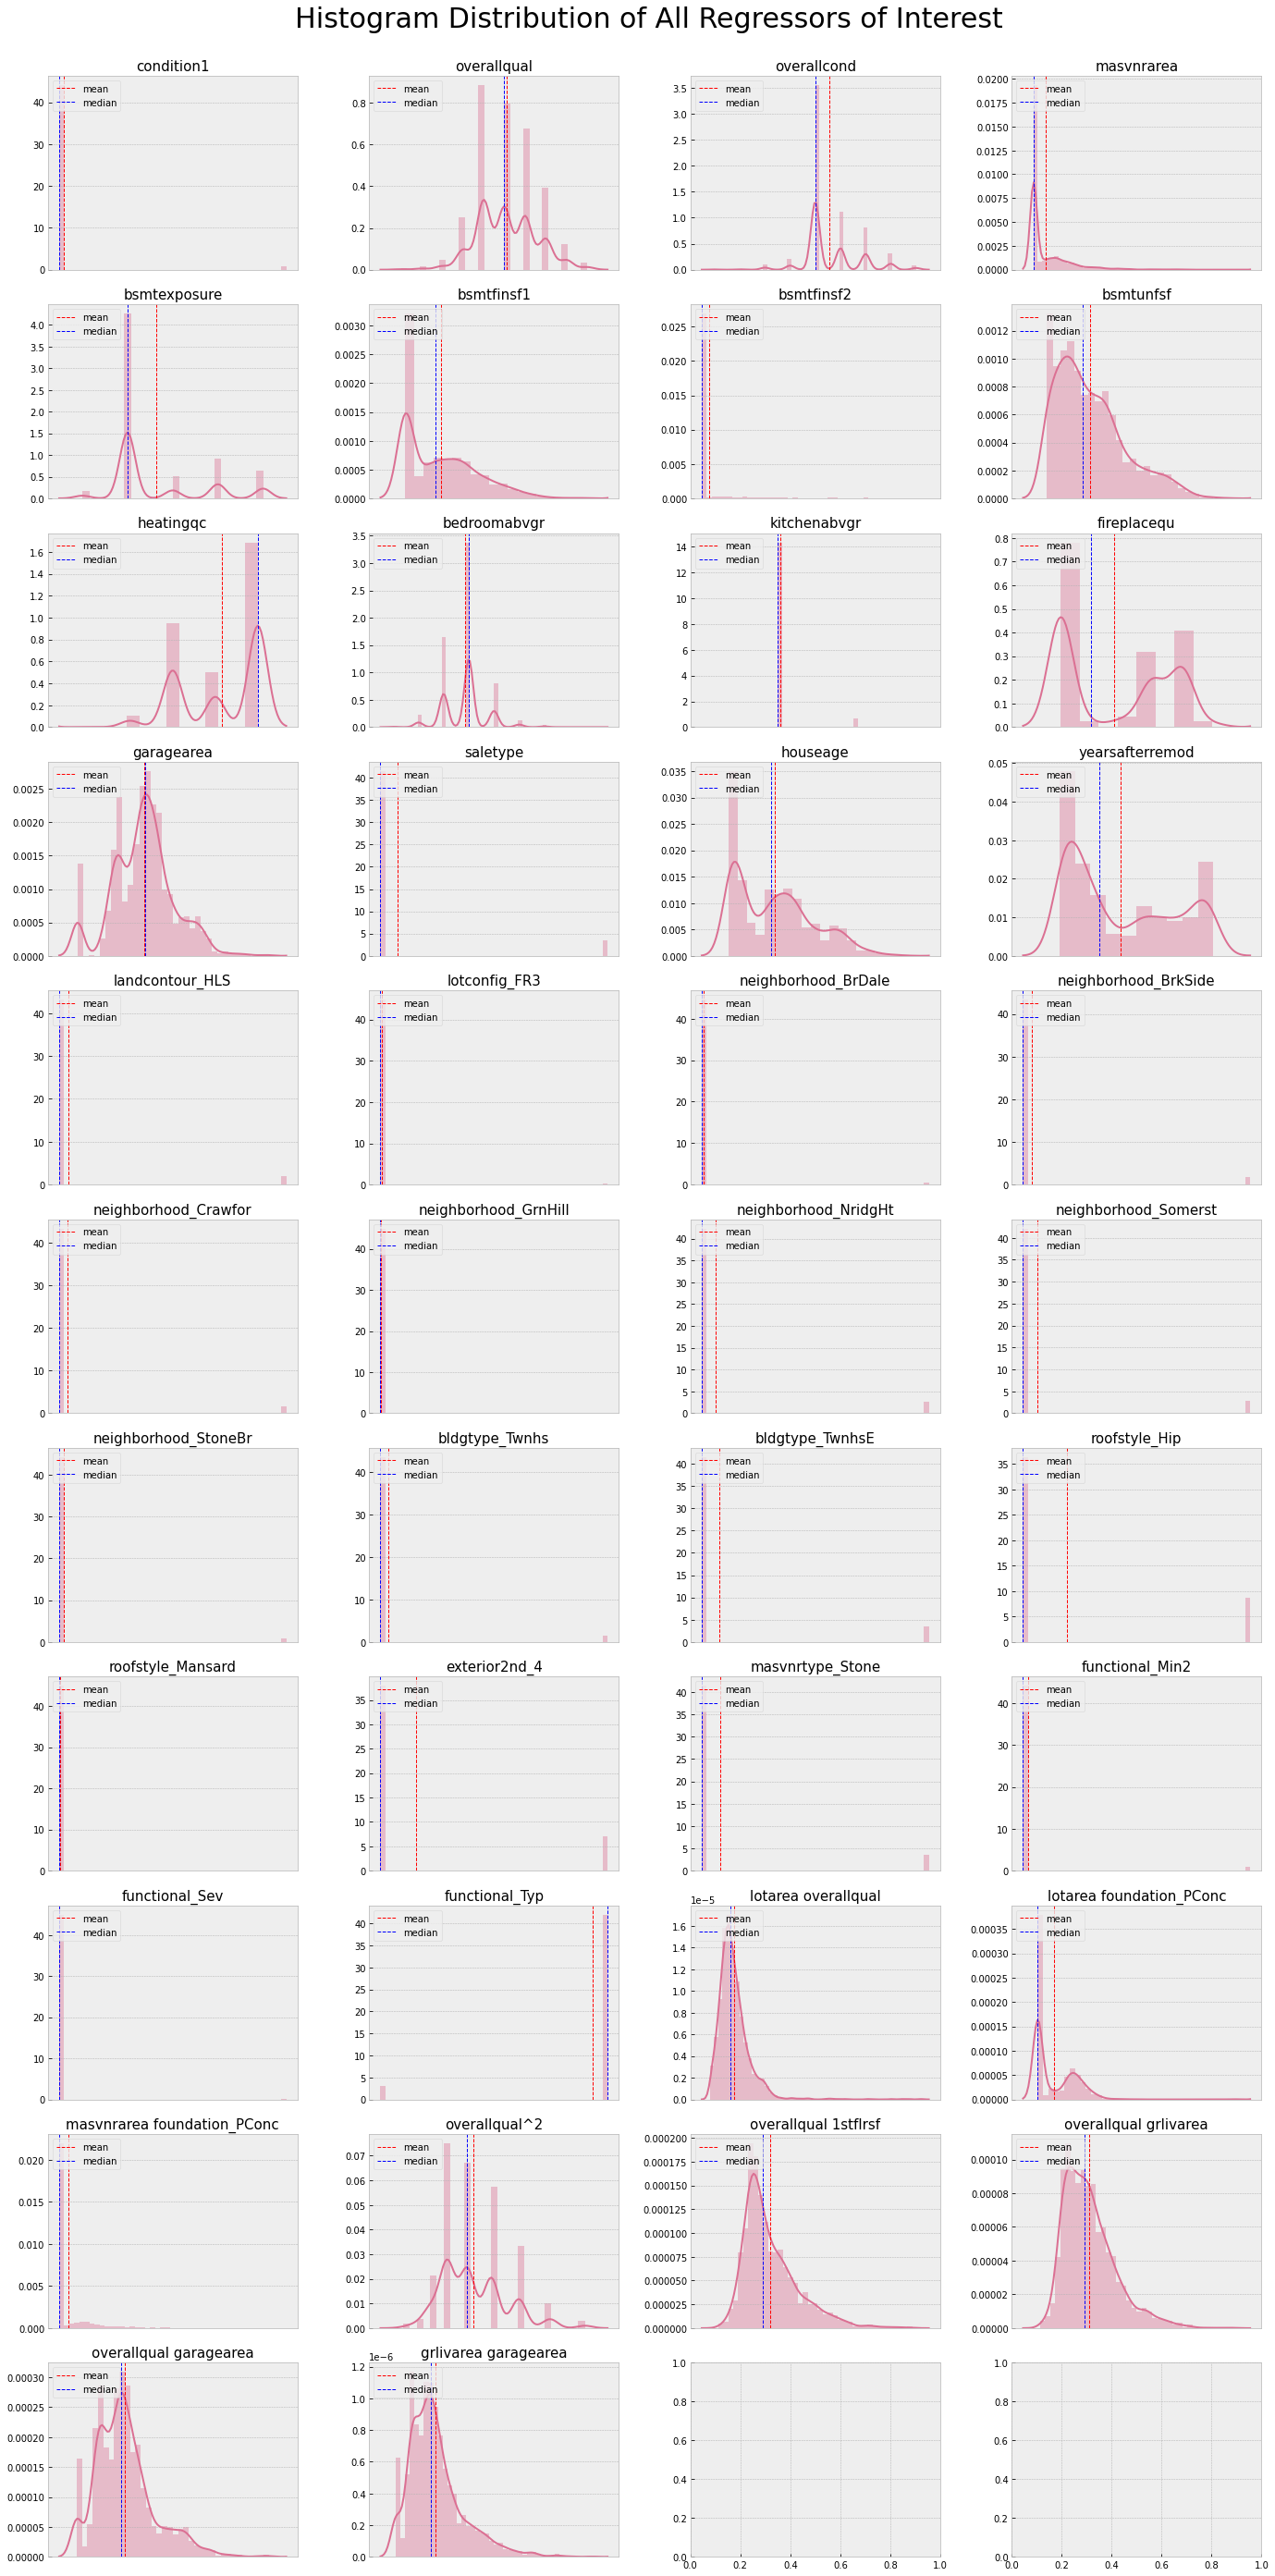

In [132]:
subplot_distplot(X_9A,X_9A.columns, 
            "Histogram Distribution of All Regressors of Interest", 
             X_9A.columns,(20,40));

**Regressors' Correlation to Saleprice**

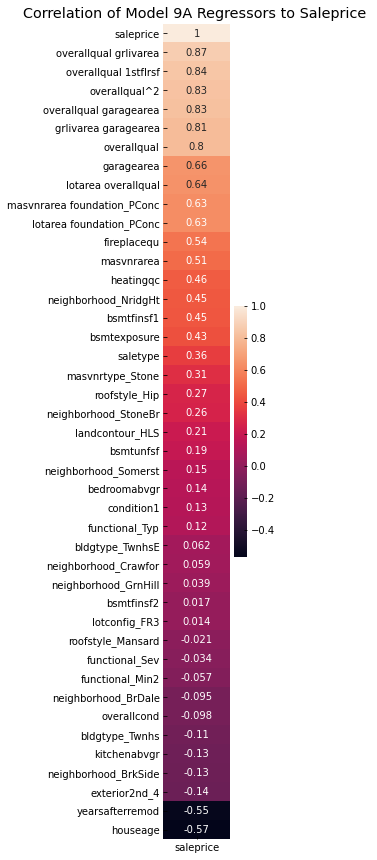

In [133]:
df = all_poly_df_eval[X_9A.columns]
df['saleprice'] = all_poly_df_eval['saleprice']
plt.figure(figsize=(1.5,15))
sns.heatmap(df.corr()[['saleprice']].sort_values(by='saleprice',ascending=False),annot=True)
plt.title("Correlation of Model 9A Regressors to Saleprice ");

In our final round of fine-tuning our model, we will look at removing regressors from model 9A from a few different perspectives:
1. Whether it reinforces the Multiple Linear Regression assumptions
2. Multi-collinearity
3. Correlation with Saleprice
4. Lasso coefficients (seen from our model performance from above)
5. Skew of our individual regressors (distribution hisogram analysis)

Regressors to remove:
- These three regressors area positively correlated to saleprice. However, lasso coefficient appears negative. This means that the interaction/polynomial terms have overcompensated for their presence, and hence we should remove them to prevent skewing of data. Moreover, these three regressors have high correlation with other regressors in our model. 
    - overallqual 
    - garagearea 
    - masvnrarea
- These regressors have an extremely skewed frequency distribution. Moreover, most of them are weakly correlated to saleprice. Hence, I will remove them from our model:
    - 'saletype', 'landcontour_HLS', 'lotconfig_FR3','neighborhood_BrDale','neighborhood_BrkSide', 'neighborhood_Crawfor','neighborhood_NridgHt', 'neighborhood_Somerst', 'neighborhood_StoneBr','bldgtype_Twnhs','bldgtype_TwnhsE', 'roofstyle_Mansard','functional_Min2', 'functional_Typ'.

### Model 10: Fine Tuning Model 9A

#### Model 10A: Removal of regressors that were 'eliminated' by lasso regression

In [134]:
cols_to_drop_10A = ['overallqual', 'masvnrarea', 'bsmtunfsf', 'garagearea',
       'neighborhood_BrDale', 'functional_Min2', 'overallqual^2',
       'overallqual garagearea']

In [135]:
X_model9a.shape
print(len(cols_to_drop_10A))

8


In [136]:
X_model10a = X_model9a.drop(columns = cols_to_drop_10A )

In [137]:
X_model10a.shape

(2047, 34)

In [138]:
X_model10a = all_poly_df[X_model10a.columns]
y = all_poly_df[['saleprice']]

In [139]:
print(X_model10a.shape)
print(y.shape)

(2047, 34)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 34)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


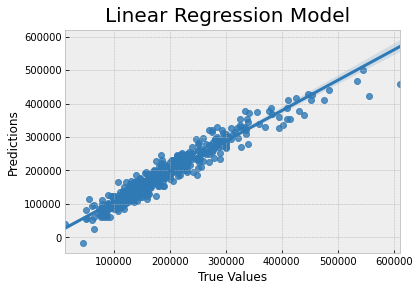

Training R2 (Basic LR) : 0.9267
Testing R2 (Basic LR) : 0.9288
Cross Val Score (Basic LR) : 0.9158
Adjusted R2 (Basic LR) :    0.9246

RMSE (Basic LR) : 22717.4838
Difference in R2 (Overfitting) : -0.21%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 15.0
Training R2 (RR) : 0.9266
Testing R2 (RR) : 0.9285
Estimate of testing R2 (RR) is: 0.916
RMSE (RR) : 22682.785
Adjusted R2 (RR) :    0.92432


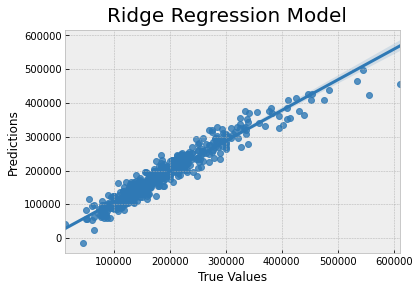

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 71.26647670360106
Training R2 (Lasso) : 0.9267
Testing R2 (Lasso) : 0.9289
Estimate of testing R2 (Lasso) is: 0.915803
RMSE (Lasso) : 22713.0446
Adjusted R2 (Lasso) :    0.92472


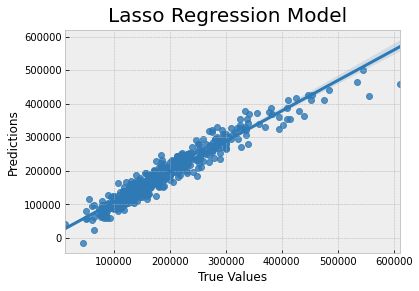

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.9201
Testing R2 (ENET) : 0.9198
Estimate of testing R2 (ENET) is: 0.912426
RMSE (ENET) : 23172.2776
Adjusted R2 (ENET) :    0.91506


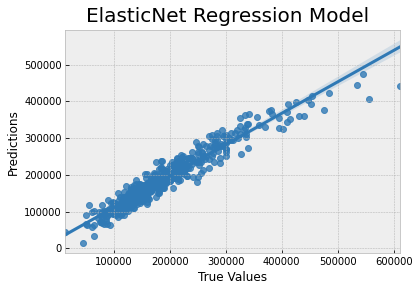

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 300*****************************************


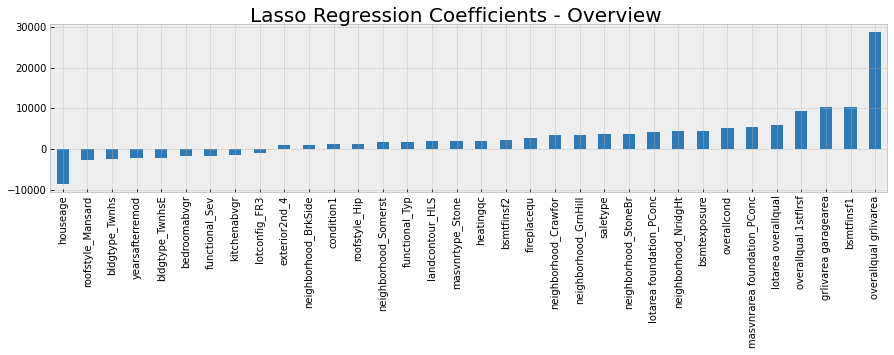

Index([], dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear          0.9246  0.9158  22717.4838
Ridge           0.9243  0.9160  22682.7850
Lasso           0.9247  0.9158  22713.0446
ElasticNet      0.9150  0.9124  23172.2776

In [140]:
final_overview(X_model10a,y,"Model 10a",1,5,300)

#### Model 10B: Removal of regressors due to MLR assumption evaluation

In [141]:
cols_to_drop_10B = ['saletype', 'landcontour_HLS', 'lotconfig_FR3',
                    'neighborhood_BrDale','neighborhood_BrkSide', 
                    'neighborhood_Crawfor','neighborhood_NridgHt', 
                    'neighborhood_Somerst', 'neighborhood_StoneBr',
                    'bldgtype_Twnhs','bldgtype_TwnhsE', 'roofstyle_Mansard',
                    'functional_Min2', 'functional_Typ','overallqual','garagearea','masvnrarea']
print(X_model9a.shape)
print(len(cols_to_drop_10B))

(2047, 42)
17


In [142]:
X_model10b = X_9A.drop(columns=cols_to_drop_10B)
X_model10b.shape

(2047, 25)

In [143]:
X_model10b.columns

Index(['condition1', 'overallcond', 'bsmtexposure', 'bsmtfinsf1', 'bsmtfinsf2',
       'bsmtunfsf', 'heatingqc', 'bedroomabvgr', 'kitchenabvgr', 'fireplacequ',
       'houseage', 'yearsafterremod', 'neighborhood_GrnHill', 'roofstyle_Hip',
       'exterior2nd_4', 'masvnrtype_Stone', 'functional_Sev',
       'lotarea overallqual', 'lotarea foundation_PConc',
       'masvnrarea foundation_PConc', 'overallqual^2', 'overallqual 1stflrsf',
       'overallqual grlivarea', 'overallqual garagearea',
       'grlivarea garagearea'],
      dtype='object')

In [144]:
X_model10b = all_poly_df[X_model10b.columns]
y = all_poly_df[['saleprice']]

In [145]:
print(X_model10b.shape)
print(y.shape)

(2047, 25)
(2047, 1)


**************************************************TRAIN-TEST-SPLIT**************************************************
Shape of X_train: (1432, 25)
Shape of y_train: (1432, 1)
********************************************LINEAR REGRESSION EVALUATION********************************************


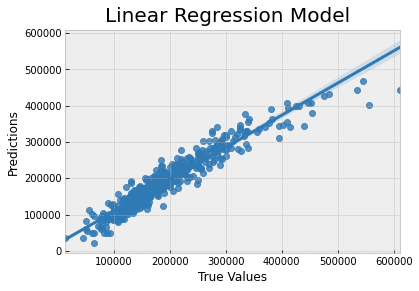

Training R2 (Basic LR) : 0.9141
Testing R2 (Basic LR) : 0.9166
Cross Val Score (Basic LR) : 0.9066
Adjusted R2 (Basic LR) :    0.913
d
RMSE (Basic LR) : 23923.1989
Difference in R2 (Overfitting) : -0.25%
********************************************RIDGE REGRESSION EVALUATION********************************************
Best Alpha for Ridge Model: 4.35
Training R2 (RR) : 0.914
Testing R2 (RR) : 0.9163
Estimate of testing R2 (RR) is: 0.9067
RMSE (RR) : 23908.8658
Adjusted R2 (RR) :    0.91278


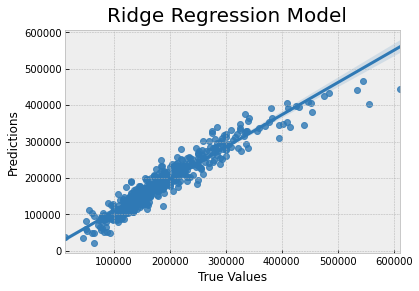

********************************************LASSO REGRESSION EVALUATION********************************************
Best Alpha for Lasso Model: 58.35480305342445
Training R2 (Lasso) : 0.914
Testing R2 (Lasso) : 0.9165
Estimate of testing R2 (Lasso) is: 0.906614
RMSE (Lasso) : 23919.2153
Adjusted R2 (Lasso) :    0.91294


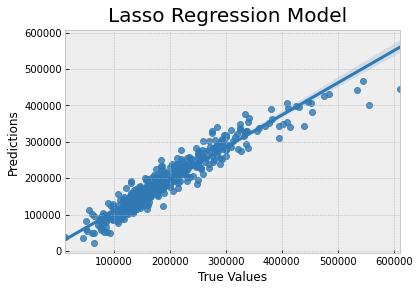

*****************************************ELASTICNET REGRESSION EVALUATION*****************************************
Best Alpha for ElasticNet Model: 0.5
Training R2 (ENET) : 0.9061
Testing R2 (ENET) : 0.9042
Estimate of testing R2 (ENET) is: 0.900708
RMSE (ENET) : 24671.2704
Adjusted R2 (ENET) :    0.90008


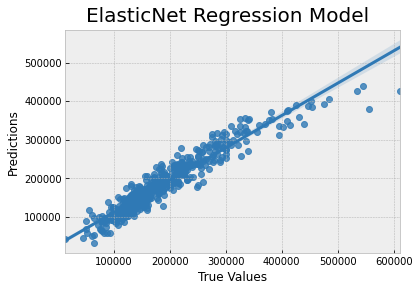

*****************************************LASSO COEFFICIENTS*****************************************
*****************************************LASSO ALPHA = 300*****************************************


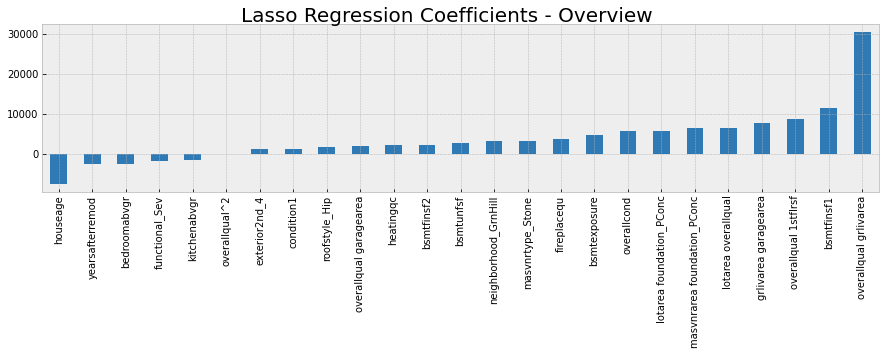

Index(['overallqual^2'], dtype='object')
*************************************************OVERVIEW*************************************************


Adjusted R2      R2        RMSE
Linear         0.913\n  0.9066  23923.1989
Ridge           0.9127  0.9067  23908.8658
Lasso           0.9129  0.9066  23919.2153
ElasticNet      0.9000  0.9007  24671.2704

In [146]:
final_overview(X_model10b,y,"Model 10B",1,5,300)

**Evaluation of Model 10A/10B:**
- Model 10A has a lower RMSE and higher R2 score than Model 10B. 
- We will proceed to submit Model 10A for our Kaggle Submission #2
- We will also submit Model 9A as a Kaggle Submission #1

In [147]:
# Submission 1: Model 9A
regressors_9A = X_model9a   #dataframe
regressors_9A.shape

(2047, 42)

In [148]:
# Submission 1: Model 10A
regressors_10 = X_model10a  #dataframe
regressors_10.shape

(2047, 34)

**Final Submission for Kaggle:** 
- Submission 1: Model 9A
    - Best prediction model in terms of R^2 score and RMSE results. 
    - There are 42 regressors. 
- Submission 2: Model 10A
    - Best performing model with a good number of regressors.

# 6 Preparing Test Data for Price Prediction

Before we predict saleprice for test data, we need to modify the test dataframe to include 'dummies' and 'interaction/polynomial' terms. Then, we will proceed to scaling the data before predicting with our Ridge Model 9A. 

#### One-hot encoding Test dataset

In [149]:
test.shape

(879, 52)

In [150]:
# We have previously done one-hot-encoding for the test dataset.
test_dummy.shape

(879, 132)

#### Creating Polynomial / Interaction terms for Test dataset:

In [151]:
test_dummy_poly = test_dummy.drop(columns=['id'])

In [152]:
poly = PolynomialFeatures(include_bias=False)
all_poly_test = poly.fit_transform(test_dummy_poly)

In [153]:
len(all_poly_test)

879

In [154]:
all_poly_test_df = pd.DataFrame(all_poly_test,columns=poly.get_feature_names(test_dummy_poly.columns))
all_poly_test_df.shape

(879, 8777)

#### Preparation of Train/Test datasets:

In [155]:
all_poly_df['saleprice'] = train['saleprice']

In [156]:
# all_poly_test_df[regressors_9A.columns] 
# all_poly_test_df[regressors_10.columns] 
    # --> This brought us error of which :['functional_Sev', 'neighborhood_GrnHill'] are identified to not be in the all_poly_test_df.
    # We will remove these two regressors.

print(all_poly_df['functional_Sev'].corr(train['saleprice']))
print(all_poly_df['neighborhood_GrnHill'].corr(train['saleprice']))

# Both regressors do not have a strong correlation with saleprice.

-0.03379122110569313
0.038922860198030665


In [157]:
print(regressors_9A.shape)
print(regressors_10.shape)

(2047, 42)
(2047, 34)


In [158]:
cols_to_drop = ['functional_Sev', 'neighborhood_GrnHill']
regressors_9A.drop(columns=cols_to_drop,inplace=True)
regressors_9A.shape

(2047, 40)

In [159]:
regressors_10.drop(columns=cols_to_drop,inplace=True)
regressors_10.shape

(2047, 32)

In [160]:
# Model 9A:
test_final_9A= all_poly_test_df[regressors_9A.columns] 
print(test_final_9A.shape)

# Model 9A:
test_final_10= all_poly_test_df[regressors_10.columns] 
print(test_final_10.shape)

(879, 40)
(879, 32)


Model 9A: Both train and test final models have 40 regressors. 

Model 10: Both train and test models have 32 regressors. 

In [161]:
X_train_9A = all_poly_df[regressors_9A.columns]
X_test_9A = all_poly_test_df[regressors_9A.columns] 

X_train_10 = all_poly_df[regressors_10.columns]
X_test_10 = all_poly_test_df[regressors_10.columns] 

y = all_poly_df[['saleprice']]

#### Scaling Dataframes:

In [162]:
# Scaling Train Data:
ss_9A=StandardScaler()
ss_10=StandardScaler()
train_scaled_9A = ss_9A.fit_transform(X_train_9A)
train_scaled_10 = ss_10.fit_transform(X_train_10)

# Scaling Test Data:
test_scaled_9A = ss_9A.transform(X_test_9A)
test_scaled_10 = ss_10.transform(X_test_10)

# 7 Model Predictions

### Ridge Model 9A: Fitting Test Data

In [163]:
ridge_findalpha=RidgeCV(alphas=np.linspace(1,15,1000), store_cv_values=True) 
ridge_findalpha.fit(train_scaled_9A,y)
ridge_alpha = round(ridge_findalpha.alpha_,2)
print(f'Best Alpha for Ridge Model: {ridge_alpha}')

Best Alpha for Ridge Model: 2.56


In [164]:
ridge = Ridge(alpha = ridge_alpha)
ridge_model_9A = ridge.fit(train_scaled_9A,y)
ypredicted_9A = ridge_model_9A.predict(test_scaled_9A)

In [165]:
print('Ridge Model 9A Test R2: ', round(ridge_model_9A.score(train_scaled_9A, y),4))
print('Ridge Model 9A Test Predicted Saleprice:' ,round(ypredicted_9A.mean(),2) )

Ridge Model 9A Test R2:  0.9322
Ridge Model 9A Test Predicted Saleprice: 180814.23


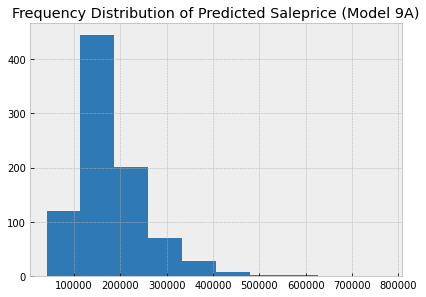

In [166]:
# This is our distribution of our predicted saleprice for test dataset. Skewed to the right.
plt.hist(ypredicted_9A)
plt.tight_layout()
plt.title('Frequency Distribution of Predicted Saleprice (Model 9A)');

#### Histogram of train dataset saleprice

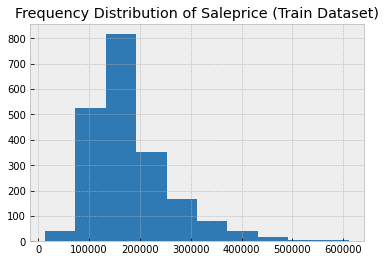

In [167]:
# This is the train dataset saleprice distribution. Skewed to the right. 
# Test prediction shows a very similar histogram distribution of saleprice. This indicates that our model worked. 
plt.hist(all_poly_df['saleprice'])
plt.title('Frequency Distribution of Saleprice (Train Dataset)');

### Ridge Model 10: Fitting Test Data

In [168]:
ridge_findalpha=RidgeCV(alphas=np.linspace(1,15,1000), store_cv_values=True) 
ridge_findalpha.fit(train_scaled_10,y)
ridge_alpha = round(ridge_findalpha.alpha_,2)
print(f'Best Alpha for Ridge Model: {ridge_alpha}')

Best Alpha for Ridge Model: 13.32


In [169]:
ridge = Ridge(alpha = ridge_alpha)
ridge_model_10 = ridge.fit(train_scaled_10,y)
ypredicted_10 = ridge_model_10.predict(test_scaled_10)

In [170]:
print('Ridge Model 10A Test R2: ', round(ridge_model_10.score(train_scaled_10, y),4))
print('Ridge Model 10A Test Predicted Saleprice:' ,round(ypredicted_10.mean(),2) )

Ridge Model 10A Test R2:  0.9263
Ridge Model 10A Test Predicted Saleprice: 180891.58


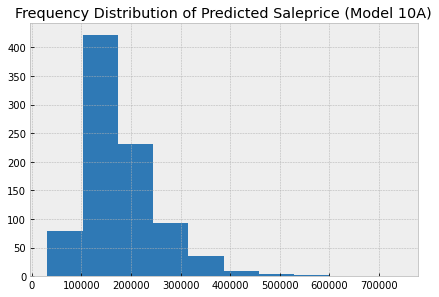

In [171]:
# This is our distribution of our predicted saleprice for test dataset. Skewed to the right.
plt.hist(ypredicted_10)
plt.tight_layout()
plt.title('Frequency Distribution of Predicted Saleprice (Model 10A)');

# 8 Kaggle Submissions & Results

In [172]:
kaggle_sub_9A = pd.DataFrame(pd.DataFrame(ypredicted_9A, columns=['SalePrice']))
kaggle_sub_9A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SalePrice  879 non-null    float64
dtypes: float64(1)
memory usage: 7.0 KB


In [173]:
kaggle_sub_10 = pd.DataFrame(pd.DataFrame(ypredicted_10, columns=['SalePrice']))
kaggle_sub_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SalePrice  879 non-null    float64
dtypes: float64(1)
memory usage: 7.0 KB


In [174]:
kaggle_sub_9A.describe()

SalePrice
count     879.000000
mean   180814.232158
std     80057.500909
min     40402.183889
25%    128269.055302
50%    158943.522412
75%    214273.721422
max    772111.579406

In [175]:
kaggle_sub_10.describe()

SalePrice
count     879.000000
mean   180891.583685
std     79295.282363
min     31030.865191
25%    127749.610979
50%    160990.182895
75%    217550.641951
max    743184.297603

In [176]:
test['id']

0      2658
1      2718
2      2414
3      1989
4       625
       ... 
874    1662
875    1234
876    1373
877    1672
878    1939
Name: id, Length: 879, dtype: int64

In [177]:
kaggle_sub_9A['Id'] = test['id']
kaggle_sub_9A = kaggle_sub_9A[['Id', 'SalePrice']]

kaggle_sub_10['Id'] = test['id']
kaggle_sub_10 = kaggle_sub_10[['Id', 'SalePrice']]

In [178]:
kaggle_sub_9A.head()

Id      SalePrice
0  2658  143057.084738
1  2718  150491.787034
2  2414  222587.843771
3  1989   99217.012138
4   625  157091.071287

In [179]:
kaggle_sub_10.head()

Id      SalePrice
0  2658  145118.845297
1  2718  145212.489157
2  2414  227505.430770
3  1989  102176.176857
4   625  162276.827305

In [180]:
kaggle_sub_9A.to_csv('kaggle_submission_9A', index=False)
kaggle_sub_10.to_csv('kaggle_submission_10', index=False)

## Results for Kaggle Challenge:

**Final Kaggle Score:** 
- Model 9A: 
    - Public: 23,686
    - Private: 32,508
- Model 10A: 
    - Public: 24,844
    - Private: 32,036

### Kaggle Submission
![my_image](images/Kaggle_Submission.png)

# 9 Conclusion and Summary

## Business Model to Utilise: Model 10

We have chosen to recommend Model 10 to our Managing Director of our Company because of the following reasons:

1. Less number of regressors.
2. RMSE of Model 10 is similar to Model 9A
3. Even though R^2 is higher for 9A, the lower number of regressors make up for the slight loss in performance.

### Visualising Model 10 Coefficients

In [181]:
model_10_coef= pd.Series(np.ravel(ridge_model_10.coef_),index=X_train_10.columns)
model_10_coef = pd.DataFrame(model_10_coef,columns=['coefficient'])
model_10_coef.head()

coefficient
condition1     1501.075972
overallcond    5186.046680
bsmtexposure   3645.139329
bsmtfinsf1    10472.284801
bsmtfinsf2     2599.816987

In [182]:
model_10_coef.index

Index(['condition1', 'overallcond', 'bsmtexposure', 'bsmtfinsf1', 'bsmtfinsf2',
       'heatingqc', 'bedroomabvgr', 'kitchenabvgr', 'fireplacequ', 'saletype',
       'houseage', 'yearsafterremod', 'landcontour_HLS', 'lotconfig_FR3',
       'neighborhood_BrkSide', 'neighborhood_Crawfor', 'neighborhood_NridgHt',
       'neighborhood_Somerst', 'neighborhood_StoneBr', 'bldgtype_Twnhs',
       'bldgtype_TwnhsE', 'roofstyle_Hip', 'roofstyle_Mansard',
       'exterior2nd_4', 'masvnrtype_Stone', 'functional_Typ',
       'lotarea overallqual', 'lotarea foundation_PConc',
       'masvnrarea foundation_PConc', 'overallqual 1stflrsf',
       'overallqual grlivarea', 'grlivarea garagearea'],
      dtype='object')

In [183]:
coef_class = {'quality':['overallcond','fireplacequ','heatingqc','functional_Typ','houseage', 'yearsafterremod'],
    
              'area': ['bsmtexposure', 'bsmtfinsf1', 'bsmtfinsf2', 'bedroomabvgr', 'kitchenabvgr'],
    
              'stylistic': ['masvnrtype_Stone','exterior2nd_4','roofstyle_Hip', 'roofstyle_Mansard'],
     
              'others': ['condition1','saletype','neighborhood_BrkSide', 'neighborhood_Crawfor', 
                         'neighborhood_NridgHt' , 'neighborhood_Somerst', 'neighborhood_StoneBr',
                         'bldgtype_Twnhs','bldgtype_TwnhsE','landcontour_HLS', 'lotconfig_FR3'],                         
             'quality + area':['lotarea overallqual', 'lotarea foundation_PConc','masvnrarea foundation_PConc',
                         'overallqual 1stflrsf','overallqual grlivarea', 'grlivarea garagearea']}
color_dict = {}

for key,value in coef_class.items():
    if key =='quality':
        color_dict['lightsalmon'] = value
    elif key =='area':
        color_dict['gold'] = value
    elif key =='stylistic':
        color_dict['firebrick'] = value
    elif key =='quality + area':
        color_dict['orangered'] = value
    else:
        color_dict['dimgrey'] = value
color_dict_new = {}
for key, values in color_dict.items():
    for i in values:
        color_dict_new[i] = key

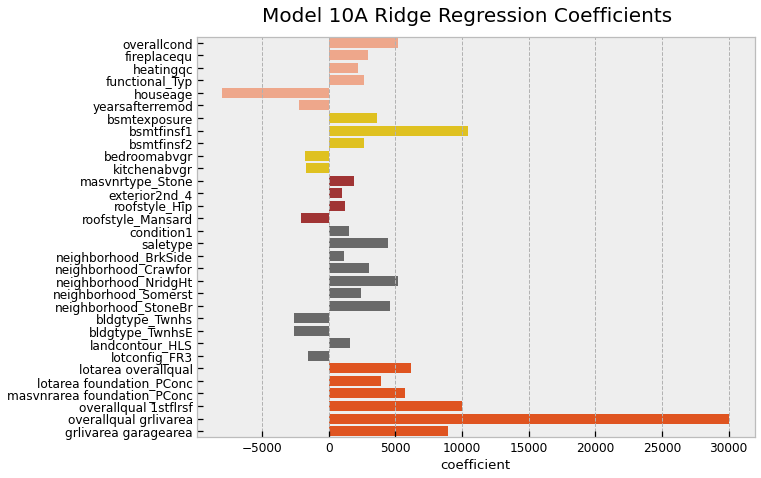

In [184]:
plt.figure(figsize=(10,7))
plt.tight_layout()

coef_order = model_10_coef.sort_values(by=('coefficient'),ascending=False).index
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2.0})
sns.barplot(x='coefficient',y=model_10_coef.index,data=model_10_coef,order=color_dict_new,
            palette=color_dict_new)
plt.suptitle("Model 10A Ridge Regression Coefficients", size=20)
plt.subplots_adjust(top=0.92)
plt.show();

### Evaluation

1. Out of all regressors, the factors that affect salesprice the most is the the size/quality factor.
    - ie. Big and quality houses will fetch a disproportionally higher premiums than small/poor-quality houses.
    - This also means that individually, having a big house or a good quality house itself will not bring in the premiums.
    - Business Evaluation: This shows us that if we purchase a big house of poor quality, and renovate it such that the quality improves, this will fetch us a much higher profit from the house.
2. Second to the size/quality factor is the quality factor of the house. 
    - Houseage, which is indicative of the quality of the house, is highly correlated to the saleprice of the house. 
    - However, it is possible to offset this negative factor by introducing more positive factors to our house, ie. renovations, material changes, quality improvements etc.
3. Neighbourhood and Building types of houses moderately impact the saleprice of houses. 
    - Prime neighbourhoods appear to be NridgeHt, StoneBr, Crawfor and Somerst in descending order (NridgeHt is the most premium). 
    - Townhouses are generally less demanded and fetch a lower price in the market. 
4. There are a few materials that are preferred over others. However, tweaking other factors (mentioned above) will bring a higher saleprice.
    - Masvnrtype = Stone is preferred. 
    - Roofstyle = "Hip" is preferred over Roofstyle = "Mansard"

### Conclusion:

Recommendations to our clients are on a case-by-case basis. There is no one-size-fits-all solution to a dynamic problem like house flipping and investing exercises. However, these are some generic recommendations suitable for different kinds of clients:

**For retail investors:** Buy-and-Hold strategy
1. To invest in a house that is generally situated around the prime neighbourhoods (NridgeHt, StoneBr, Crawfor and Somerst).
2. Ideally, purchase a bigger house and renovate towards the end of your investment to improve quality of the house. This will bring a disproportionally bigger premium in the market. This will also help with the 'years after renovation" considerations that buyers have. 
3. A downside to the buy-and-hold strategy is that the houseprices also decrease disproportionally due to the increased age of house. To buffer the decrease in premiums, we should be mindful of the materials we choose when renovating the house near full-term.
    - A foundation material of Poured Contrete alongside a large houses (masonry/lotarea) is highly preferred by buyers.
    - General preference hip-styled roof than mansard-styled roof. However, renovations for rooftops often come with a heavy price tag, hence we need to weigh the trade-offs and see if it is still worth it.

**For house-flippers:** Buy-Flip-Sell strategy
1. Location will not be a big concern for an ultra-short term investment, as location-based premiums generally rises in the long-run due to changes in demographic, amenenities etc. 
2. The same goes to "Houseage" as a factor in price determination, as an ultra-short term investment will not affect the 'houseage' factor which is predicted to depress prices. 
    - Contrary, renovations done within the investment holdings period will set 'years after renovations" to be 0. This also lift prices. 
2. The key to a successful flipping strategy is to buy-low and sell-high. Hence, finding a good house at a low price is essential in this strategy.
3. A key to success is also the size of the house. 
    - Our model suggest that houses that are big and extremely poor in quality will depress prices by a significant amount. Hence, buying them at a low price is plausible. This also suggest that the strategy of renovations will work well based on our model prediction.
    - Preferably, find a house that has a garage and basement. These are elements of houses that lift prices. 
4. Similar to the buy-and-hold strategy, we should be really mindful in the materials chosen for our renovation work. Suggestions for desirable materials are listed above (in the buy-and-hold strategy). 
5. Purchase house in April (due to lowest mean saleprices) and sell house in June-July (due to highest sales activities).

### How to improve our model

1. House transaction data were collected over four years, from 2006 to 2010, based on 'yrsold' data from our train model. 
    - As we are working towards expanding our presence in the Ames, Iowa region in year 2020, the data collected is deemed to be outdated for present day modelling. Many factors would have changed post-2010, including neighbourhood amenities changes, demographic changes, taste & preferences of consumers etc. 
    - Data showed that 2010 house sales have dipped in numbers compared to all other years. However, we do not have data for 2010-onwards. A systematic shock to the economy may cause house prices to be depressed for a long time, and we do not know how it has affected current sale prices as a result of this crisis. 
2. Data Requests - Some other details that would be helpful for our analysis would be:
    - Transportation facilities nearby: Number of Buses in 500m vicinity, Distance to nearest train station
    - At least 10 years of transaction data
    - Demographic group of each neighbourhood and each building type (in a seperate dataframe)